# Capstone 2 Project: Customer Churn
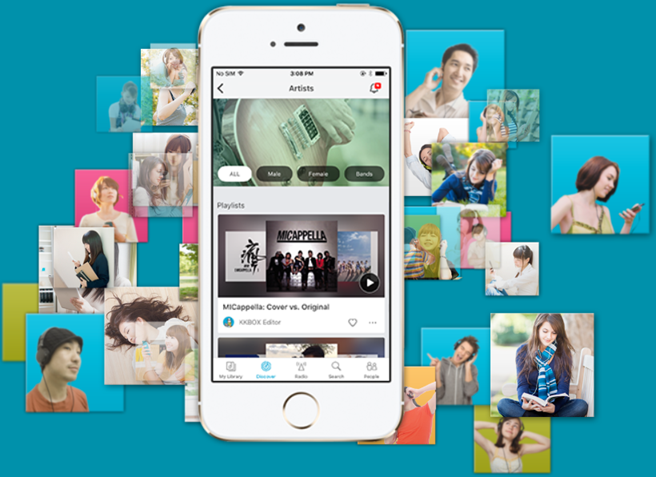

## 1. Problem Identification
### 1.1 Context
<a href="https://www.kkbox.com/">KKBOX</a> is Asia’s leading music streaming service, holding the world’s most comprehensive Asia-Pop music library with over 30 million tracks. They offer a generous, unlimited version of their service to millions of people, supported by advertising and paid subscriptions. This delicate model is dependent on accurately predicting churn of their paid users.<br>
When users sign up for the service, they can choose to either manual renew or auto-renew the service, and they can cancel their membership at any time.

Build an algorithm that predicts whether a user will churn after their subscription expires. Specifically, we want to forecast if a user will make a new service subscription transaction within 30 days after the current membership expiration date.

### 1.2 Criteria for success
Prediction accuracy of the trained machine learning model should not deteriorate when applied to new, more recent data. Decision criteria are simple and interpretable. If using a decision tree, no more than 10 questions asked before making a prediction.

### 1.3 Scope of solution space
Since the majority of KKBox's subscription length is 30 days, a lot of users re-subscribe every month. The key fields to determine churn/renewal are `transaction date`, `membership expiration date`, and `is_cancel`.
The `is_cancel` field indicates whether a user actively cancels a subscription. Subscription cancellation does not imply the user has churned. A user may cancel service subscription due to change of service plans or other reasons. The criteria of <b>"churn"</b> is no new valid service subscription within 30 days after the current membership expires.<br>
Supervised learning methods will be used to handle this binary classification problem. Some of the records with missing and erroneous data will be placed in a separate category.

### 1.4 Constraints within solution space
The data may reveal incorrect and missing values. Such problems will be treated individually for different features and depending on the number of problems of specific kind.

The data have a shape that is incompatible with machine learning algorithms, which expect one record per prediction label. Thus, there is in general several transactions and several usage statistics records per member, which have to be aggregated into one row.

SAMPLE:<br>
A warmer or very snowy season can lead to an unpredictable decrease in the number of operating days and additional costs of making or removing excess snow. Large differences in the physical abilities of group members can lead to long waiting times on zip lines and thus to underutilization of facilities. Accidents can lead to the temporary closure of runs.

### 1.5 Stakeholders to provide key insight
There are two key stakeholders that need to be involved in this project: 1) My mentor Rahul Sagrolikar, and 2) Addison Howard, Head of Competition Program Management at Kaggle.

### 1.6 Key data sources
Data were compiled by Ann and Arden from KKBox, and are available at Kaggle
https://www.kaggle.com/c/kkbox-churn-prediction-challenge

Data are provided in 3 CSV files containing basic information about KKBOX customers, transaction details, and listening statistics.
* `members.csv`: city, age, gender, registration channel, initial registration time. 6658 records.
* `transactions.csv`: payment method, duration of subscription plan, listed price, paid price, auto renewal indicator, transaction date, membership expiration date, and the churn label. 22940 records.
* `logs.csv`: date, number of songs listened below 25%, 50%, 75%, 98.5%, and 100% of their duration, number of unique songs listened, and total duration of listening. 424254 records.

In [1]:
# Import data
import os
#os.chdir('C:/Sereda/Lectures/Springboard/16.Feature_Engineering/')
os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')

# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
#import warnings
#warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 600)

## 2.  Data Wrangling: Collect, organize, define, and clean a relevant dataset.
### 2.1 Collect Data

In [2]:
# Data science helpers
from pathlib import Path
#!pip install featuretools==0.4.0 dask==0.19.4 distributed==1.23.3 tornado==5.0.0
import featuretools as ft

# Useful for showing multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# make some folders we will need if they do not exist
Path("./data/churn").mkdir(parents=True, exist_ok=True)

In [4]:
# Read in all data
members = pd.read_csv('https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/members.csv', 
                      parse_dates=['registration_init_time'], 
                      infer_datetime_format = True, index_col=False)

trans = pd.read_csv('https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/transactions.csv',
                   parse_dates=['transaction_date', 'membership_expire_date'], 
                    infer_datetime_format = True, index_col=False)

logs = pd.read_csv(f'https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/logs.csv', parse_dates = ['date'], index_col=False)

cutoff_times = pd.read_csv(f'https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/MS-31_labels.csv', parse_dates = ['cutoff_time'], index_col=False)

In [5]:
#members.reset_index(drop=True)

In [5]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,8hW4+CV3D1oNM0CIsA39YljsF8M3m7g1LAX6AQd3C8I=,4,24,male,3,2014-11-04
1,yhcODfebyTYezE6KAPklcV1us9zdOYJ+7eHS7f/xgoU=,8,37,male,9,2007-02-11
2,sBlgSL0AIq49XsmBQ2KceKZNUyIxT1BwSkN/xYQLGMc=,15,21,male,3,2013-02-08
3,Xy3Au8sZKlEeHBQ+C7ro8Ni3X/dxgrtmx0Tt+jqM1zY=,1,0,NaN,9,2015-02-01
4,NiCu2GVWgT5QZbI85oYRBEDqHUZbzz2azS48jvM+khg=,12,21,male,3,2015-02-12


### 2.2 Data summary

* `members.csv`:
    * `msno` - unique ID (1 record per members), 6658 members;
    * `city` (categorical, 20 levels: 1, 3-18, 20-22);
    * `bd` - age. Has outlier values ranging from -7000 to 2015, please use your judgement (categorical, 65 levels from 0 to 827);
    * `gender` (categorical: male, female, and 64.9% missing),
    * `registered_via` (categorical, 14 levels are 1-9, 11, 13, 16, 17, 19).
    * `registration_init_time` (date: 2004-03-27 to 2017-04-29)
* `transactions.csv`: 22940 transactions.
    * `msno`: 2434 unique member IDs (transaction information is available for 36.6% of all registered members);
    * `payment_method_id` (categorical, 31 levels: 8, 12-41);
    * `payment_plan_days` (numeric, 26 levels: 0 to 450);
    * `plan_list_price` (numeric, 31 levels: 0 to 2000);
    * `actual_amount_paid` (numeric, 31 levels: 0 to 2000);
    * `is_auto_renew` (binary 0/1, it is 1 for 85.1% of all transactions);
    * `transaction_date` (date from 2015-01-01 to 2017-03-31);
    * `membership_expire_date` (date from invalid 1970-01-01 to 2018-06-10, 1022 levels);
    * `is_cancel` (binary 0/1: 0 - no churn, 1 - churn; 3.95% of transactions are cancellations).
* `logs.csv`:
    * `date` (date: 2015-01-01 to 2017-03-31);
    * `num_25` (288 integers within 0 to 937);
    * `num_50` (137 integers within 0 to 257);
    * `num_75` (83 integers within 0 to 204);
    * `num_985` (109 integers within 0 to 201);
    * `num_100` (734 integers within 0 to 4376);
    * `num_unq` (386 integers within 1 to 2944);
    * `total_secs` (floating-point: 89 missing values encoded as `-9.223372e+15`, 134 small values below 1s, maximum 2.763295e+06 s).

All tables have `msno` customer ID column.

### 2.3 Missing values

In [6]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6658 entries, 0 to 6657
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    6658 non-null   object        
 1   city                    6658 non-null   int64         
 2   bd                      6658 non-null   int64         
 3   gender                  2337 non-null   object        
 4   registered_via          6658 non-null   int64         
 5   registration_init_time  6658 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 312.2+ KB


In [7]:
print("Proportion of non-missing gender values:", members.gender.notnull().sum()/members.gender.shape[0])
print(members.gender.unique())

Proportion of non-missing gender values: 0.35100630820066087
['male' nan 'female']


In [8]:
members.gender[members.gender.isnull()] = 'unknown' # Replace missing values with 'unknown'
print(members.gender.unique())

['male' 'unknown' 'female']


No missing values in `trans.csv` and `logs.csv`:

In [9]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22940 entries, 0 to 22939
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    22940 non-null  object        
 1   payment_method_id       22940 non-null  int64         
 2   payment_plan_days       22940 non-null  int64         
 3   plan_list_price         22940 non-null  int64         
 4   actual_amount_paid      22940 non-null  int64         
 5   is_auto_renew           22940 non-null  int64         
 6   transaction_date        22940 non-null  datetime64[ns]
 7   membership_expire_date  22940 non-null  datetime64[ns]
 8   is_cancel               22940 non-null  int64         
dtypes: datetime64[ns](2), int64(6), object(1)
memory usage: 1.6+ MB


In [10]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424252 entries, 0 to 424251
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   msno        424252 non-null  object        
 1   date        424252 non-null  datetime64[ns]
 2   num_25      424252 non-null  int64         
 3   num_50      424252 non-null  int64         
 4   num_75      424252 non-null  int64         
 5   num_985     424252 non-null  int64         
 6   num_100     424252 non-null  int64         
 7   num_unq     424252 non-null  int64         
 8   total_secs  424252 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 29.1+ MB


In [11]:
logs[logs.total_secs < 0].total_secs.unique() # missing values

array([-9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -

<font color=red><b>Q1 Replace all large negative numbers of seconds with 0?</b></font>

In [12]:
logs.loc[logs['total_secs'] < 0, 'total_secs'] = 0 # replace with 0

In [13]:
logs = logs.sort_values(by=['msno','date']) # ID and chronological sorting
logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
117822,+/H81sPGdk9Q+Ieghr1zCSjjDa4wQZ9e/cHiJkpaDsU=,2016-02-18,0,0,0,1,7,8,1863.523
127014,+/H81sPGdk9Q+Ieghr1zCSjjDa4wQZ9e/cHiJkpaDsU=,2016-03-05,0,0,0,0,3,3,779.860
294909,+/YVsAKHl+zz+knoN7tD/304ryI518FHS8u4zY+7cDA=,2016-03-20,0,0,0,1,0,1,174.480
216885,+02DseTE8j9jvqiPO20x+v71zdIe90IekJT1I7Bzmx8=,2015-12-23,51,9,2,0,0,57,2446.634
311867,+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2016-01-14,19,6,6,1,42,61,11779.952


In [14]:
if not Path("data/logs.csv").is_file():
    logs.to_csv("data/logs.csv", index=False)

### 2.4 Detailed data exploration

In [22]:
# Auxiliary functions
def nu(a):
    '''No. of unique values'''
    return len(np.unique(a))
def top5(d,a):
    '''Count and percentage of the top 5 values of feature `a` in dataframe `d`.'''
    print(f"{a}\tcount\t%")
    vc = pd.DataFrame(d[a].value_counts())
    n = len(d)
    for i in range(5):
        cnt = vc.iloc[i] #.index[i]
        print(f"{cnt.name}\t{cnt[a]}\t{round(cnt[a]/n*100,1)}")

#### 2.4.1 members.csv

In [16]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,8hW4+CV3D1oNM0CIsA39YljsF8M3m7g1LAX6AQd3C8I=,4,24,male,3,2014-11-04
1,yhcODfebyTYezE6KAPklcV1us9zdOYJ+7eHS7f/xgoU=,8,37,male,9,2007-02-11
2,sBlgSL0AIq49XsmBQ2KceKZNUyIxT1BwSkN/xYQLGMc=,15,21,male,3,2013-02-08
3,Xy3Au8sZKlEeHBQ+C7ro8Ni3X/dxgrtmx0Tt+jqM1zY=,1,0,unknown,9,2015-02-01
4,NiCu2GVWgT5QZbI85oYRBEDqHUZbzz2azS48jvM+khg=,12,21,male,3,2015-02-12


#### members.msno

In [17]:
Nm = nu(members.msno)
print("No. of members:", Nm)

No. of members: 6658


#### members.city

In [38]:
print(f"There are {nu(members.city)} cities")
print("Sorted cities:", np.sort(members.city.unique()))

There are 20 cities
Sorted cities: [ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22]


Most members are from city 1:

In [86]:
#members.city.value_counts()
top5(members,'city')

city	count	%
1	4735	71.1
5	384	5.8
13	285	4.3
4	227	3.4
22	208	3.1


#### members.bd

In [87]:
print(f"No. of unique ages `bd`: {len(members.bd.unique())}")
print("Sorted bd:", np.sort(members.bd.unique()))

No. of unique ages `bd`: 65
Sorted bd: [  0   6  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  63  65  66  67
  69  70  72  90  97 103 106 112 117 132 827]


In [88]:
#members.bd.value_counts()
top5(members,'bd')

bd	count	%
0	4456	66.9
21	126	1.9
24	108	1.6
20	105	1.6
26	104	1.6


In [89]:
members.loc[members.bd > 150] # Outlier

,msno,city,bd,gender,registered_via,registration_init_time
1119,zzWbNfxs2hJmRe82uVTk+0rIhuu8MqQngjdgmc5Oerk=,5,827,female,9,2014-07-08


In [90]:
print("All combinations of `city` and `bd`:")
test= members.groupby(['city','bd'])
test.size()

All combinations of `city` and `bd`:


city  bd 
1     0      4295
      15        2
      16       11
      17       13
      18       25
      19       28
      20       25
      21       24
      22       18
      23       11
      24       25
      25       21
      26       12
      27       19
      28       12
      29       15
      30       11
      31        8
      32       12
      33        7
      34        9
      35        7
      36        8
      37        9
      38        6
      39        6
      40       10
      41        7
      42        3
      43        9
      44        8
      45        4
      46        6
      47        5
      48        6
      49        3
      50        2
      51        5
      52        6
      53        2
      54        2
      55        2
      56        1
      57        4
      59        3
      60        3
      61        1
      66        2
      67        1
      112       1
3     0         1
      17        1
      19        3
      21        1
      22        1


#### members.gender

In [91]:
print("Unknown gender and bd=0 count:", members.gender[(members.gender=='unknown') & (members.bd == 0)].count())
print("Unknown gender and bd>0 count:", members.gender[(members.gender=='unknown') & (members.bd  > 0)].count())

Unknown gender and bd=0 count: 4283
Unknown gender and bd>0 count: 38


A small proportion 0.887% of `bd > 0` among customers with unknown gender suggests that `0` could be used to encode a missing value of `bd`. Let us inspect this small group.

In [93]:
members.loc[(members.gender=='unknown') & (members.bd > 0)].drop(columns=['msno','gender']) # nothing special

,city,bd,registered_via,registration_init_time
269,1,16,9,2016-05-23
278,5,28,9,2014-03-12
333,1,28,4,2016-10-02
634,13,22,3,2013-01-08
766,1,36,3,2014-04-28
824,3,27,9,2014-05-30
984,5,27,9,2010-12-13
1133,1,26,4,2017-01-28
1403,12,23,3,2013-02-06
1598,15,26,7,2012-12-23


There is nothing special in this group. Most of the missing genders are from city '1':

In [94]:
members.loc[members.gender=='unknown'].city.value_counts()

1     4206
13      23
5       17
15      15
22      11
4       11
14       8
6        5
11       5
8        4
12       4
18       4
9        3
21       2
3        2
10       1
Name: city, dtype: int64

In [95]:
members.loc[(members.gender=='unknown') & (members.bd > 0) ].city.value_counts()

1     19
13     6
5      4
15     4
3      1
12     1
4      1
14     1
11     1
Name: city, dtype: int64

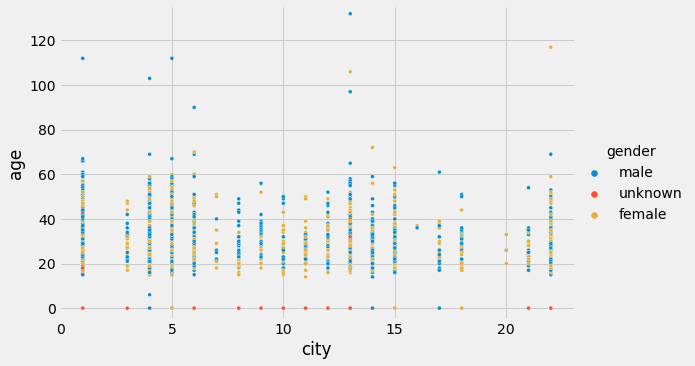

In [96]:
import seaborn as sns
sns.relplot(data=members, x='city', y='bd', hue='gender', aspect=1.6, s=15)
plt.ylim(-5, 135)
plt.ylabel('age')
plt.show();

#### members.registered_via

In [98]:
print(f"`registered_via` has {nu(members['registered_via'])} levels:")
pd.crosstab(index=members['registered_via'], columns='count')

`registered_via` has 14 levels:


col_0,count
registered_via,
1,1
2,2
3,1648
4,2710
5,2
6,1
7,798
8,3
9,1451


In [99]:
top5(members,'registered_via')

registered_via	count	%
4	2710	40.7
3	1648	24.8
9	1451	21.8
7	798	12.0
11	31	0.5


#### members.registration_init_time

Earliest member registration:	 2004-03-27
Latest member registration:	 2017-04-29


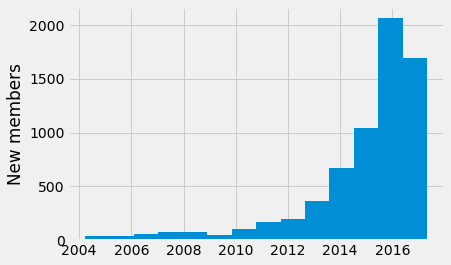

In [100]:
print("Earliest member registration:\t", np.min(members.registration_init_time).strftime('%Y-%m-%d'))
print("Latest member registration:\t", np.max(members.registration_init_time).strftime('%Y-%m-%d'))
plt.hist(members.registration_init_time, bins=2017-2004+1)
plt.ylabel('New members');

#### 2.4.2 transactions.csv

In [103]:
print(trans.shape)
trans.head()

(22940, 9)


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2017-02-10,2017-03-10,0
1,DQMPoCSc6EB39ytgnKCRsUIZnR6ZWSrHeDmX7nbxAKs=,41,30,149,149,1,2016-02-01,2016-03-02,0
2,Lrais3nsgqYwpfpSoyK3fHuPutf6cloTI5T5dQfs4lA=,38,30,149,149,0,2016-02-23,2016-04-23,0
3,ZPOjgxQw1/J7v5xgBJTCLXWuwq5Xmk33nO6AoUO1+mY=,41,30,149,119,1,2015-09-06,2016-08-01,0
4,MvR23u4bIiWM+U+VE1Mvw3qqdj/0Ixs1sf7avavjhRs=,38,30,149,149,0,2016-10-28,2016-11-27,0


#### trans.msno

In [104]:
Ntm = nu(trans.msno)
print("No. of members with available transaction data:", Ntm)
print(f"Proportion of members with available transaction data: {round(len(trans.msno.unique())/Nm*100,1)}%")

No. of members with available transaction data: 2434
Proportion of members with available transaction data: 36.6%


<font color=red><b>Q2 Discard all members with no transaction and churn information?</b></font>

#### trans.payment_method_id

In [105]:
trans.payment_method_id.describe()

count    22940.000000
mean        38.903575
std          3.548366
min          8.000000
25%         38.000000
50%         41.000000
75%         41.000000
max         41.000000
Name: payment_method_id, dtype: float64

In [106]:
print("Levels of payment method:", np.sort(trans.payment_method_id.unique()))

Levels of payment method: [ 8 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41]


In [110]:
Nt = trans.shape[0]
print("No. of transactions:", Nt)
top5(trans,'payment_method_id')

No. of transactions: 22940
payment_method_id	count	%
41	11983	52.2
40	2508	10.9
38	1851	8.1
39	1659	7.2
37	1193	5.2


Looking at one of the member's data, we see only one payment method:

In [112]:
trans.loc[trans.msno=='5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=', 'payment_method_id']

0        41
1020     41
4151     41
4735     41
7267     41
8705     41
9597     41
10303    41
10909    41
11228    41
15174    41
15889    41
17815    41
18034    41
20735    41
20929    41
20952    41
21608    41
Name: payment_method_id, dtype: int64

Does each member use only one payment method? No, from 1 to 5 payment methods were used by a member.

In [113]:
uv_pm = pd.pivot_table(trans, index='msno', values='payment_method_id', aggfunc=nu) # how many payment methods were used by each member
uv_pm.rename(columns = {'payment_method_id':'n_payment_methods'}, inplace = True)
uv_pm.head()

,n_payment_methods
msno,
++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,1
+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2
+8BSu/tg0Y7DIY+q1S1mgHnFSQkRvb+/QVdwE7KMFU0=,1
+95t/v4J6t8a3D3ZhpsUDCL7reDGJKsDPPkRPVlGOZ4=,1
+9Q0UzM+XCIzH1BNZPFbFzvwt6QdIYd/DLn6nMt0TIU=,1


In [114]:
uv_pm.n_payment_methods.sort_values(ascending=False)

msno
Tq1aYXKTql7jPtgRCiyQ6xuMTiluycrRKG7HFl5hnSs=    5
XDvqZ7KtY0J80pbyJnqVRpI7ZFgYu9D6zYWKQImrXjA=    5
fH1Zz4lUeEsxX30G/V76NqBoHOS0vuGSFN9HjKWnCpU=    4
zfwHJ6LRTVfIhmwU6dm18f4nQhNJklA1dc/YM6tYmJE=    4
PwLdVzv98EqPz0uKoeFEKGh05Dsgldov3wlozEtN+SM=    4
                                               ..
LIzQJvG7np60EDFEiZ7FDueKgMTATASdfBhBfi1Kx1o=    1
LHjrZBjEa174FOZ4M7OirVlL8yvazN/609+xK4LjDp8=    1
LH9NrH31zn/i6p8Wihu9yO5gd0ZMLptskYYqFvXoR+o=    1
LFa6kalNBTzKg8ixv+yIC1m3KDJSXKOXxuxhhSPgcDI=    1
V91x6HpYEohG5ZdV7sk26ko2NcE/EWQ6vwI9YCGfr0k=    1
Name: n_payment_methods, Length: 2434, dtype: int64

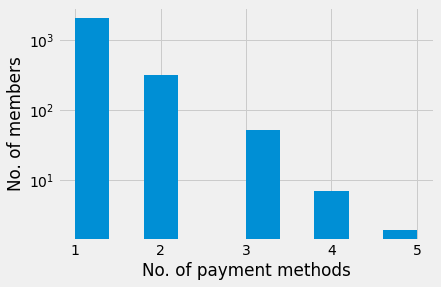

In [115]:
plt.semilogy();
uv_pm.n_payment_methods.hist();
plt.xlabel('No. of payment methods');
plt.ylabel('No. of members');

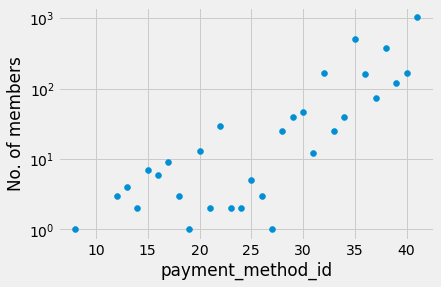

In [116]:
uv_mem = pd.pivot_table(trans, index='payment_method_id', values='msno', aggfunc=nu) # how many members used each payment method
uv_mem.rename(columns = {'msno':'n_members'}, inplace = True)
plt.semilogy()
plt.scatter(uv_mem.index, uv_mem.n_members);
plt.xlabel("payment_method_id");
plt.ylabel("No. of members");

In [117]:
print(np.sort(trans.payment_plan_days.unique()))

[  0   1   2   7  10  14  30  31  35  60  80  90 100 120 180 195 200 240
 270 360 365 395 400 410 415 450]


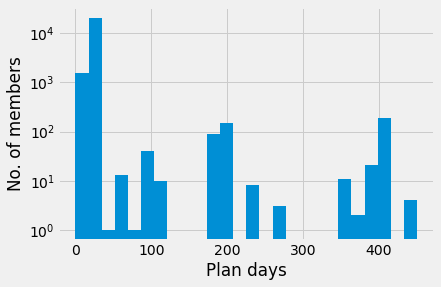

In [119]:
plt.semilogy();
trans.payment_plan_days.hist(bins=nu(trans.payment_plan_days));
plt.xlabel('Plan days');
plt.ylabel("No. of members");

In [120]:
print(f"Of payment_plan_days == 0, only {round(100*trans.loc[trans.payment_plan_days == 0].is_cancel.sum()/trans.loc[trans.payment_plan_days == 0].is_cancel.shape[0],2)}% transactions were cancellations.")

Of payment_plan_days == 0, only 3.25% transactions were cancellations.


In [122]:
# how many different plan days each member had
uv_pd = pd.pivot_table(trans, index='msno', values='payment_plan_days', aggfunc=nu)
uv_pd.rename(columns = {'payment_plan_days':'n_payment_plan_days'}, inplace = True)
uv_pd.head()

,n_payment_plan_days
msno,
++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,1
+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2
+8BSu/tg0Y7DIY+q1S1mgHnFSQkRvb+/QVdwE7KMFU0=,2
+95t/v4J6t8a3D3ZhpsUDCL7reDGJKsDPPkRPVlGOZ4=,1
+9Q0UzM+XCIzH1BNZPFbFzvwt6QdIYd/DLn6nMt0TIU=,2


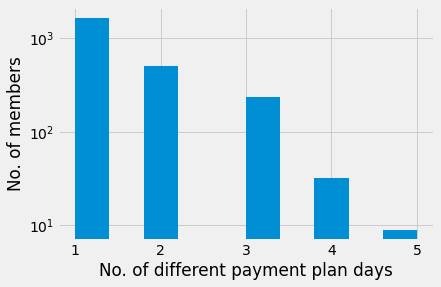

In [124]:
plt.semilogy();
uv_pd.n_payment_plan_days.hist();
plt.xlabel('No. of different payment plan days');
plt.ylabel('No. of members');

#### trans.plan_list_price

In [125]:
print(f"{nu(trans.plan_list_price)} levels of plan list price:", np.sort(trans.plan_list_price.unique()))

31 levels of plan list price: [   0   10   35   50   99  100  119  120  129  134  149  150  180  298
  300  400  447  477  480  500  536  600  699  799  894  930 1200 1299
 1599 1788 2000]


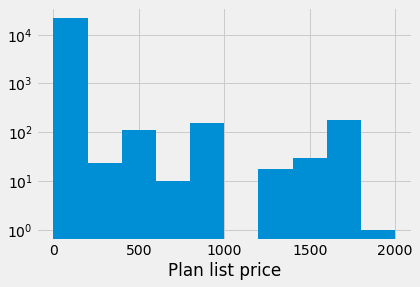

In [126]:
plt.semilogy();
trans.plan_list_price.hist();
plt.xlabel('Plan list price');

#### trans.actual_amount_paid -> discount

In [127]:
print(f"{nu(trans.actual_amount_paid)} levels of plan list price:", np.sort(trans.actual_amount_paid.unique()))

31 levels of plan list price: [   0   10   35   50   99  100  119  120  129  134  149  150  180  298
  300  400  447  477  480  500  536  600  699  799  894  930 1200 1299
 1599 1788 2000]


In [128]:
print(f"`actual_amount_paid > plan_list_price` only when `plan_list_price` == {trans.loc[trans.actual_amount_paid > trans.plan_list_price].plan_list_price.unique()}")

`actual_amount_paid > plan_list_price` only when `plan_list_price` == [0]


In [129]:
trans['discount'] = trans.plan_list_price - trans.actual_amount_paid
print(f"Discount levels: {np.sort(trans.loc[trans.discount > 0].discount.unique())}")

Discount levels: [ 20  30 120 149 180]


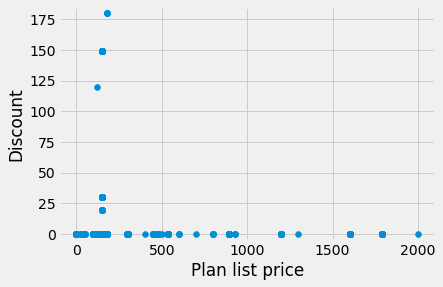

In [130]:
plt.scatter(trans.plan_list_price, trans.discount);
plt.ylim([-5,185]);
plt.xlabel('Plan list price');
plt.ylabel('Discount');

Expensive plans do not have discounts.

#### is_auto_renew

In [131]:
print(f"Proportion of auto renew transactions: {round(100*trans.is_auto_renew.sum()/Nt,1)}%")

Proportion of auto renew transactions: 85.1%


#### transaction_date

In [133]:
print("Earliest transaction:\t",np.min(trans.transaction_date).strftime('%Y-%m-%d'))
print("Latest transaction:\t",np.max(trans.transaction_date).strftime('%Y-%m-%d'))

Earliest transaction:	 2015-01-01
Latest transaction:	 2017-03-31


There is an overall growth in the number of transactions with time.

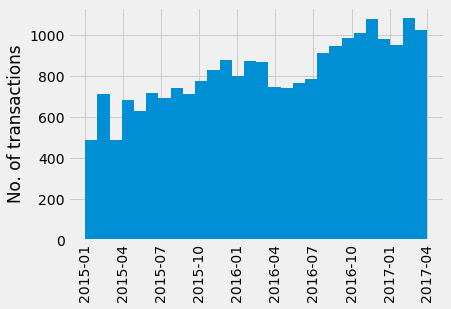

In [136]:
plt.xticks(rotation=90)
trans.transaction_date.hist(bins=2*12+4);
plt.ylabel('No. of transactions');

#### membership_expire_date

In [137]:
print(f"{nu(trans.membership_expire_date)} levels of membership_expire_date")

1022 levels of membership_expire_date


Some values are invalid, since they are before earliest membership subscription:

In [138]:
np.min(trans.membership_expire_date).strftime('%Y-%m-%d')

'1970-01-01'

some other are in the future, but this is OK

In [139]:
np.max(trans.membership_expire_date).strftime('%Y-%m-%d')

'2018-06-10'

In [140]:
def md(tn):
    '''Membership duration (days) for transaction number tn'''
    return trans.membership_expire_date[tn] - members.loc[members.msno == trans.msno[tn]].registration_init_time

In [141]:
md(0)

1421   2360 days
Name: registration_init_time, dtype: timedelta64[ns]

#### is_cancel

In [142]:
print(f"Proportion of cancellation transactions: {round(100*trans.is_cancel.sum()/Nt,2)}%")

Proportion of cancellation transactions: 3.95%


#### 2.4.3 logs.csv

In [143]:
logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
117822,+/H81sPGdk9Q+Ieghr1zCSjjDa4wQZ9e/cHiJkpaDsU=,2016-02-18,0,0,0,1,7,8,1863.523
127014,+/H81sPGdk9Q+Ieghr1zCSjjDa4wQZ9e/cHiJkpaDsU=,2016-03-05,0,0,0,0,3,3,779.860
294909,+/YVsAKHl+zz+knoN7tD/304ryI518FHS8u4zY+7cDA=,2016-03-20,0,0,0,1,0,1,174.480
216885,+02DseTE8j9jvqiPO20x+v71zdIe90IekJT1I7Bzmx8=,2015-12-23,51,9,2,0,0,57,2446.634
311867,+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2016-01-14,19,6,6,1,42,61,11779.952


#### logs.msno

In [146]:
Nlm = nu(logs.msno)
print("No. of members with available logs data:", Nlm)
print(f"Proportion of members with available logs data: {round(Nlm/Nm*100,1)}%")

No. of members with available logs data: 5214
Proportion of members with available logs data: 78.3%


#### logs.date

In [147]:
print("Earliest usage log:",np.min(logs.date).strftime('%Y-%m-%d'))
print("Latest usage log:",np.max(logs.date).strftime('%Y-%m-%d'))

Earliest usage log: 2015-01-01
Latest usage log: 2017-03-31


In [148]:
logs.describe()

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,424252.000000,424252.000000,424252.000000,424252.000000,424252.000000,424252.000000,4.242520e+05
mean,6.276480,1.571901,0.978503,1.044558,31.394426,29.348618,8.110696e+03
std,12.853579,3.900916,2.064198,2.459123,46.805506,33.006411,1.166276e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,6.000000,8.000000,1.862119e+03
50%,2.000000,1.000000,0.000000,0.000000,16.000000,18.000000,4.546765e+03
75%,7.000000,2.000000,1.000000,1.000000,38.000000,39.000000,1.006348e+04
max,937.000000,257.000000,204.000000,201.000000,4376.000000,2944.000000,2.763295e+06


#### logs.num_25
Number of songs listened upto 25% of their duration.

In [156]:
print("Unique values for the no. of songs listened <25%:",nu(logs.num_25))

Unique values for the no. of songs listened <25%: 288


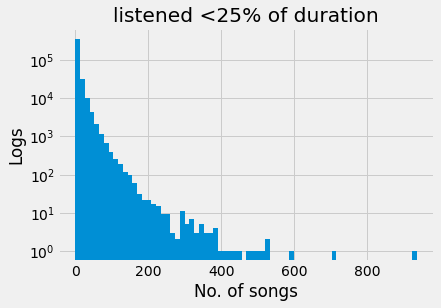

In [150]:
plt.semilogy();
logs.num_25.hist(bins=nu(logs.num_25)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('listened <25% of duration');

#### logs.num_50
Number of songs listened 25-50% of their duration.

In [157]:
print("Unique values for the no. of songs listened 25-50%:",nu(logs.num_50))

Unique values for the no. of songs listened 25-50%: 137


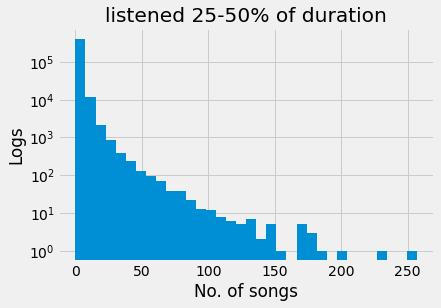

In [158]:
plt.semilogy();
logs.num_50.hist(bins=nu(logs.num_50)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('listened 25-50% of duration');

#### logs.num_75
Number of songs listened 50-75% of their duration.

In [159]:
print("Unique values for the no. of songs listened 50-75%:",nu(logs.num_75))

Unique values for the no. of songs listened 50-75%: 83


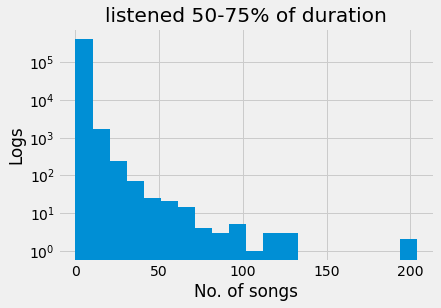

In [160]:
plt.semilogy();
logs.num_75.hist(bins=nu(logs.num_75)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('listened 50-75% of duration');

#### logs.num_985
Number of songs listened 75-98.5% of their duration.

In [161]:
print("Unique values for the no. of songs listened 75-98.5%:",nu(logs.num_985))

Unique values for the no. of songs listened 75-98.5%: 109


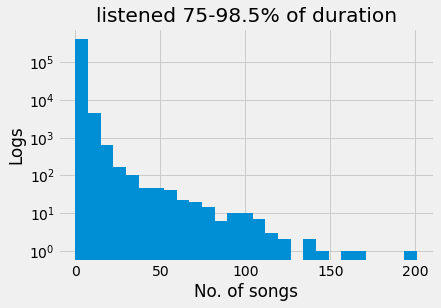

In [162]:
plt.semilogy();
logs.num_985.hist(bins=nu(logs.num_985)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('listened 75-98.5% of duration');

#### logs.num_100
Number of songs listened 98.5-100% of their duration.

In [163]:
print("Unique values for the no. of songs listened 98.5-100%:",nu(logs.num_100))

Unique values for the no. of songs listened 98.5-100%: 734


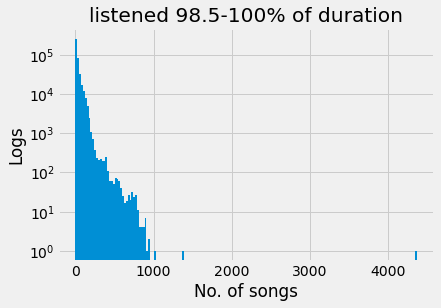

In [164]:
plt.semilogy();
logs.num_100.hist(bins=nu(logs.num_100)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('listened 98.5-100% of duration');

Distributions of the number of logs with listening percentage are similar upto 75% of the duration of a song.

#### logs.num_unq

In [165]:
print("Unique values for the no. of unique songs:",nu(logs.num_unq))

Unique values for the no. of unique songs: 386


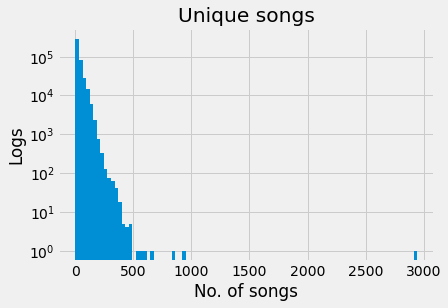

In [166]:
plt.semilogy();
logs.num_unq.hist(bins=nu(logs.num_unq)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('Unique songs');

#### logs.total_secs

In [171]:
print(f"No. of missing `total_secs`: {logs[logs.total_secs == 0].shape[0]}")
logs[logs.total_secs == 0] # missing values

No. of missing `total_secs`: 89


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
312852,12fE0BR5VYvkIiRkN8hA7krd5PL5U3YF/XMxv7dr8cQ=,2015-09-02,15,2,2,0,55,44,0.0
52445,5CInFKkcBo/UxkObN6mzrj/KOKPXiJ6Rg2SmVCI9T3k=,2015-06-23,5,1,0,1,72,69,0.0
30733,5o/oARKZiImsG8fsFYTBV34WB5l54Mn1Rof6Ci8OB7Q=,2015-05-04,6,1,3,2,28,25,0.0
62286,5o/oARKZiImsG8fsFYTBV34WB5l54Mn1Rof6Ci8OB7Q=,2015-05-08,3,2,6,1,41,35,0.0
370852,5o/oARKZiImsG8fsFYTBV34WB5l54Mn1Rof6Ci8OB7Q=,2015-06-15,12,2,1,0,62,42,0.0
288001,5o/oARKZiImsG8fsFYTBV34WB5l54Mn1Rof6Ci8OB7Q=,2015-09-14,5,2,1,0,14,21,0.0
151914,69tihm91roH4FY30zSO0IQarnOoKwVxgFss1wurgooo=,2015-08-21,27,4,2,4,30,63,0.0
247635,72A6mKXzEFxPH+5nBE5cDVFtEqHLznBpfP3QztmfLI4=,2015-05-30,1,0,1,0,20,22,0.0
382096,7Tr/5vPknSWXUU3T6+s7sB3ov/RbYFO7A5x4zPRmOFg=,2015-03-03,15,4,3,2,147,106,0.0
408955,7Tr/5vPknSWXUU3T6+s7sB3ov/RbYFO7A5x4zPRmOFg=,2015-08-11,6,2,2,3,117,86,0.0


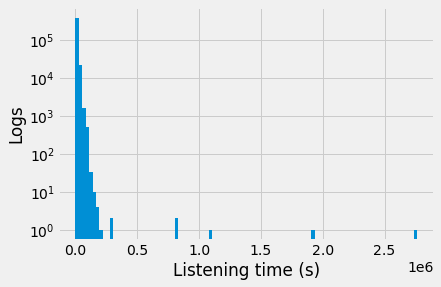

In [172]:
plt.semilogy();
logs[logs.total_secs > 0].total_secs.hist(bins=100);
plt.xlabel('Listening time (s)');
plt.ylabel('Logs');

In [173]:
print("Between 0 and 1 sec:")
logs[(0 < logs.total_secs) & (logs.total_secs < 1)].total_secs.describe()

Between 0 and 1 sec:


count    134.000000
mean       0.520963
std        0.283591
min        0.001000
25%        0.292250
50%        0.515000
75%        0.758000
max        0.995000
Name: total_secs, dtype: float64

#### Replace missing `total_secs` using linear regression prediction vs `num_25`, `num_50`, `num_75`, `num_985`, `num_100`, `num_unq`

In [174]:
from sklearn.linear_model import LinearRegression

In [198]:
# data used for fitting
Xy = logs.drop(['msno','date'], axis=1).loc[logs.total_secs > 0]
X_fit = Xy.drop('total_secs', axis=1)
y_fit = Xy['total_secs']
del Xy
print(X_fit.shape)
print(y_fit.shape)

# Linear regression
reg = LinearRegression().fit(X_fit, y_fit)
reg.score(X_fit, y_fit)
print("Intercept =",reg.intercept_)
print("Coefficients =",reg.coef_)

(424252, 6)
(424252,)


0.7316509167838503

Intercept = 267.9391893250213
Coefficients = [-61.70357901  11.1033253  125.70570474 196.13285464 165.07945439
  92.15409579]


In [196]:
# values to be replaced by linear regression predictions
Xy = logs.drop(['msno','date'], axis=1).loc[logs.total_secs <= 0]
X_pred = Xy.drop('total_secs', axis=1)
idx = Xy.index
logs.loc[idx,'total_secs'] = reg.predict(X_pred)

In [199]:
#if not Path("data/logs.csv").is_file():
logs.to_csv("data/logs.csv", index=False)

<font color=red><b>Q3 At which point should I merge 3 datafiles?</b></font>

### 2.5 Clean data: fix times, remove useless, replace missing
#### 2.5.1 Fix errors in dates
#### members.registration_init_time

The earliest event is initial registration: members['registration_init_time'] must always be before or same as trans['transaction_date'].

In [200]:
members['registration_init_time'].head()

0   2014-11-04
1   2007-02-11
2   2013-02-08
3   2015-02-01
4   2015-02-12
Name: registration_init_time, dtype: datetime64[ns]

No violations of this rule: indeed, `registration_init_time` is the same or earlier than `transaction_date`. Now compare the former with `membership_expire_date`.

In [201]:
# Check inconsistency in dates
print('Records where `registration_init_time` is later than `membership_expire_date`')
n_violations=0
for i in range(Nt):
    tr = trans.iloc[i]
    member_id = tr['msno']
    members_row = members.loc[members['msno']==member_id, 'registration_init_time']
    if len(members_row) > 0: # some member_id's are in trans.csv, but not in members.csv
        registration_init_time = members_row.squeeze()
        if len(members.loc[members['msno']==member_id, 'registration_init_time'])>1:
            print(i);
            break;
        if (registration_init_time > tr['membership_expire_date']):
            print(i)
            n_violations=n_violations+1
n_violations

Records where `registration_init_time` is later than `membership_expire_date`
1860
17032


2

In both violations, `membership_expire_date = 1970-01-01`:

In [202]:
trans.iloc[1860] # Example of violation: `membership_expire_date = 1970-01-01`
#trans.iloc[17032]

msno                      PwLdVzv98EqPz0uKoeFEKGh05Dsgldov3wlozEtN+SM=
payment_method_id                                                   17
payment_plan_days                                                   60
plan_list_price                                                      0
actual_amount_paid                                                   0
is_auto_renew                                                        0
transaction_date                                   2017-02-01 00:00:00
membership_expire_date                             1970-01-01 00:00:00
is_cancel                                                            0
discount                                                             0
Name: 1860, dtype: object

<font color=red><b>Q4 Should I replace `membership_expire_date` with `transaction_date` or remove these 2 transactions?<br>
    I prefer to replace.</b></font>

In [221]:
#trans.loc[trans['membership_expire_date']=='1970-01-01']
print("Earliest `registration_init_time`:",np.min(members['registration_init_time']).strftime('%Y-%m-%d'))
print("Rows with invalid `membership_expire_date`")
Xy = trans.loc[trans['membership_expire_date'] <= np.min(members['registration_init_time'])]
idx = Xy.index
trans.loc[idx, ['transaction_date','membership_expire_date']]

Earliest `registration_init_time`: 2004-03-27
Rows with invalid `membership_expire_date`


,transaction_date,membership_expire_date
1860,2017-02-01,1970-01-01
17032,2017-02-03,1970-01-01
18535,2015-02-06,1970-01-01


In [222]:
from datetime import date, timedelta

def fix_membership_expire_date(df,idx):
    '''Fix membership_expire_date in dataframe df, row no. idx'''
    tr = df.iloc[i] # row no. idx in df
    med = tr['membership_expire_date'].strftime('%Y-%m-%d') #membership_expire_date
    if (med == '1970-01-01') or (tr['transaction_date'] >= tr['membership_expire_date']): # then fix it
        Date = tr['transaction_date'].date() #Timestamp => datetime.date
        med = Date + timedelta(days=int(tr.payment_plan_days)) # transaction date + payment plan days
        med = pd.Timestamp(med)
        df.loc[i,'membership_expire_date'] = med
    return med

In [223]:
for i in idx:
    fix_membership_expire_date(trans,i)

Timestamp('2017-04-02 00:00:00')

Timestamp('2017-06-03 00:00:00')

Timestamp('2015-03-08 00:00:00')

Now indeed `registration_init_time` <= `membership_expire_date`.

#### trans.transaction_date <= trans.membership_expire_date

In [224]:
# Count and fix violations
n_violations=0
for i in range(Nt):
    tr = trans.iloc[i]
    if (tr['transaction_date'] >= tr['membership_expire_date']):
        print(i)
        n_violations=n_violations+1
        fix_membership_expire_date(trans,i) # membership_expire_date = transaction_date + payment_plan_days
n_violations

110


Timestamp('2015-09-19 00:00:00')

136


Timestamp('2017-02-20 00:00:00')

159


Timestamp('2016-06-04 00:00:00')

175


Timestamp('2015-12-08 00:00:00')

232


Timestamp('2016-05-25 00:00:00')

262


Timestamp('2015-12-24 00:00:00')

349


Timestamp('2016-12-01 00:00:00')

352


Timestamp('2016-03-24 00:00:00')

396


Timestamp('2016-08-17 00:00:00')

437


Timestamp('2016-03-23 00:00:00')

467


Timestamp('2015-02-09 00:00:00')

473


Timestamp('2016-08-29 00:00:00')

480


Timestamp('2016-06-27 00:00:00')

501


Timestamp('2016-01-24 00:00:00')

511


Timestamp('2016-08-31 00:00:00')

542


Timestamp('2017-01-14 00:00:00')

659


Timestamp('2016-10-16 00:00:00')

743


Timestamp('2015-01-31 00:00:00')

807


Timestamp('2017-02-13 00:00:00')

817


Timestamp('2015-02-22 00:00:00')

850


Timestamp('2016-02-01 00:00:00')

857


Timestamp('2017-03-17 00:00:00')

901


Timestamp('2016-10-06 00:00:00')

955


Timestamp('2015-02-21 00:00:00')

957


Timestamp('2016-01-03 00:00:00')

1049


Timestamp('2016-06-01 00:00:00')

1057


Timestamp('2015-12-02 00:00:00')

1070


Timestamp('2016-01-28 00:00:00')

1096


Timestamp('2017-01-19 00:00:00')

1108


Timestamp('2017-01-03 00:00:00')

1112


Timestamp('2017-01-02 00:00:00')

1180


Timestamp('2016-04-05 00:00:00')

1202


Timestamp('2016-03-26 00:00:00')

1324


Timestamp('2016-01-27 00:00:00')

1357


Timestamp('2017-02-13 00:00:00')

1449


Timestamp('2017-02-11 00:00:00')

1493


Timestamp('2017-02-21 00:00:00')

1506


Timestamp('2015-04-01 00:00:00')

1541


Timestamp('2017-02-28 00:00:00')

1567


Timestamp('2016-06-24 00:00:00')

1659


Timestamp('2015-11-28 00:00:00')

1682


Timestamp('2016-12-28 00:00:00')

1686


Timestamp('2016-03-26 00:00:00')

1687


Timestamp('2017-03-27 00:00:00')

1740


Timestamp('2016-01-27 00:00:00')

1768


Timestamp('2015-07-30 00:00:00')

1846


Timestamp('2015-12-19 00:00:00')

1868


Timestamp('2015-10-03 00:00:00')

1902


Timestamp('2016-03-26 00:00:00')

1973


Timestamp('2015-12-10 00:00:00')

2035


Timestamp('2016-05-08 00:00:00')

2082


Timestamp('2015-10-03 00:00:00')

2108


Timestamp('2016-05-03 00:00:00')

2225


Timestamp('2017-02-10 00:00:00')

2271


Timestamp('2016-01-16 00:00:00')

2300


Timestamp('2015-09-09 00:00:00')

2323


Timestamp('2016-08-01 00:00:00')

2354


Timestamp('2016-01-22 00:00:00')

2366


Timestamp('2016-06-24 00:00:00')

2371


Timestamp('2015-06-20 00:00:00')

2380


Timestamp('2016-04-30 00:00:00')

2386


Timestamp('2015-12-15 00:00:00')

2400


Timestamp('2015-05-07 00:00:00')

2416


Timestamp('2015-04-19 00:00:00')

2429


Timestamp('2015-08-21 00:00:00')

2481


Timestamp('2016-02-05 00:00:00')

2515


Timestamp('2015-12-18 00:00:00')

2558


Timestamp('2016-02-12 00:00:00')

2595


Timestamp('2015-04-18 00:00:00')

2630


Timestamp('2016-02-04 00:00:00')

2680


Timestamp('2016-08-10 00:00:00')

2699


Timestamp('2017-01-07 00:00:00')

2706


Timestamp('2016-01-27 00:00:00')

2712


Timestamp('2015-03-28 00:00:00')

2742


Timestamp('2015-06-18 00:00:00')

2746


Timestamp('2015-11-12 00:00:00')

2844


Timestamp('2016-11-04 00:00:00')

2852


Timestamp('2016-07-21 00:00:00')

2879


Timestamp('2016-02-11 00:00:00')

2907


Timestamp('2016-05-11 00:00:00')

2909


Timestamp('2016-12-29 00:00:00')

2967


Timestamp('2016-11-10 00:00:00')

2996


Timestamp('2016-10-16 00:00:00')

3001


Timestamp('2015-06-17 00:00:00')

3071


Timestamp('2016-01-28 00:00:00')

3115


Timestamp('2016-12-18 00:00:00')

3117


Timestamp('2016-09-04 00:00:00')

3125


Timestamp('2015-12-08 00:00:00')

3215


Timestamp('2016-04-12 00:00:00')

3232


Timestamp('2016-09-21 00:00:00')

3265


Timestamp('2016-01-29 00:00:00')

3300


Timestamp('2016-08-19 00:00:00')

3323


Timestamp('2016-08-08 00:00:00')

3385


Timestamp('2015-02-10 00:00:00')

3419


Timestamp('2015-11-19 00:00:00')

3421


Timestamp('2015-03-05 00:00:00')

3422


Timestamp('2015-12-02 00:00:00')

3428


Timestamp('2016-06-09 00:00:00')

3500


Timestamp('2016-03-26 00:00:00')

3509


Timestamp('2017-03-08 00:00:00')

3525


Timestamp('2016-11-23 00:00:00')

3664


Timestamp('2016-08-14 00:00:00')

3672


Timestamp('2016-03-26 00:00:00')

3679


Timestamp('2015-12-04 00:00:00')

3719


Timestamp('2016-02-02 00:00:00')

3755


Timestamp('2015-05-06 00:00:00')

3797


Timestamp('2017-03-26 00:00:00')

3806


Timestamp('2016-08-15 00:00:00')

3811


Timestamp('2015-05-06 00:00:00')

3882


Timestamp('2015-05-04 00:00:00')

3889


Timestamp('2016-05-09 00:00:00')

3973


Timestamp('2016-06-18 00:00:00')

4025


Timestamp('2015-03-18 00:00:00')

4044


Timestamp('2016-10-29 00:00:00')

4065


Timestamp('2015-12-06 00:00:00')

4124


Timestamp('2016-02-01 00:00:00')

4217


Timestamp('2016-08-21 00:00:00')

4299


Timestamp('2017-02-21 00:00:00')

4318


Timestamp('2015-02-26 00:00:00')

4329


Timestamp('2016-03-10 00:00:00')

4376


Timestamp('2016-02-14 00:00:00')

4387


Timestamp('2015-11-27 00:00:00')

4408


Timestamp('2016-01-23 00:00:00')

4530


Timestamp('2015-07-28 00:00:00')

4572


Timestamp('2015-11-01 00:00:00')

4605


Timestamp('2015-04-02 00:00:00')

4615


Timestamp('2015-12-01 00:00:00')

4621


Timestamp('2016-07-21 00:00:00')

4656


Timestamp('2015-03-07 00:00:00')

4752


Timestamp('2016-04-13 00:00:00')

4886


Timestamp('2016-08-03 00:00:00')

4898


Timestamp('2016-06-28 00:00:00')

4957


Timestamp('2016-05-09 00:00:00')

4970


Timestamp('2016-02-03 00:00:00')

4973


Timestamp('2016-03-03 00:00:00')

5104


Timestamp('2016-03-26 00:00:00')

5160


Timestamp('2016-10-16 00:00:00')

5192


Timestamp('2016-09-04 00:00:00')

5229


Timestamp('2016-04-16 00:00:00')

5390


Timestamp('2016-08-06 00:00:00')

5396


Timestamp('2015-10-05 00:00:00')

5420


Timestamp('2015-11-03 00:00:00')

5445


Timestamp('2016-01-02 00:00:00')

5461


Timestamp('2015-04-09 00:00:00')

5506


Timestamp('2015-12-15 00:00:00')

5543


Timestamp('2016-04-29 00:00:00')

5571


Timestamp('2016-01-16 00:00:00')

5582


Timestamp('2015-04-10 00:00:00')

5586


Timestamp('2015-03-05 00:00:00')

5599


Timestamp('2017-03-30 00:00:00')

5667


Timestamp('2015-05-11 00:00:00')

5739


Timestamp('2016-03-10 00:00:00')

5782


Timestamp('2016-07-22 00:00:00')

5788


Timestamp('2016-03-26 00:00:00')

5821


Timestamp('2016-01-12 00:00:00')

5826


Timestamp('2016-03-05 00:00:00')

5867


Timestamp('2016-09-17 00:00:00')

5882


Timestamp('2016-01-30 00:00:00')

5907


Timestamp('2017-01-18 00:00:00')

5983


Timestamp('2016-01-13 00:00:00')

6017


Timestamp('2016-02-25 00:00:00')

6055


Timestamp('2016-08-14 00:00:00')

6057


Timestamp('2016-02-06 00:00:00')

6149


Timestamp('2016-03-27 00:00:00')

6156


Timestamp('2016-03-17 00:00:00')

6166


Timestamp('2015-04-28 00:00:00')

6180


Timestamp('2016-01-16 00:00:00')

6229


Timestamp('2016-07-11 00:00:00')

6419


Timestamp('2015-02-04 00:00:00')

6426


Timestamp('2016-02-08 00:00:00')

6466


Timestamp('2016-05-15 00:00:00')

6483


Timestamp('2016-12-11 00:00:00')

6486


Timestamp('2016-05-22 00:00:00')

6522


Timestamp('2016-03-26 00:00:00')

6556


Timestamp('2015-05-07 00:00:00')

6615


Timestamp('2016-01-28 00:00:00')

6617


Timestamp('2016-01-19 00:00:00')

6628


Timestamp('2015-03-21 00:00:00')

6637


Timestamp('2015-05-14 00:00:00')

6714


Timestamp('2016-03-26 00:00:00')

6815


Timestamp('2016-11-27 00:00:00')

6823


Timestamp('2016-06-16 00:00:00')

6827


Timestamp('2016-01-29 00:00:00')

6850


Timestamp('2016-09-22 00:00:00')

6857


Timestamp('2016-09-17 00:00:00')

6861


Timestamp('2016-12-09 00:00:00')

6872


Timestamp('2015-11-21 00:00:00')

6875


Timestamp('2015-04-25 00:00:00')

6941


Timestamp('2016-01-22 00:00:00')

7003


Timestamp('2015-11-28 00:00:00')

7019


Timestamp('2015-03-28 00:00:00')

7147


Timestamp('2016-10-12 00:00:00')

7155


Timestamp('2016-01-06 00:00:00')

7202


Timestamp('2015-08-22 00:00:00')

7218


Timestamp('2016-12-06 00:00:00')

7285


Timestamp('2016-05-15 00:00:00')

7286


Timestamp('2015-05-08 00:00:00')

7322


Timestamp('2016-02-04 00:00:00')

7429


Timestamp('2017-01-11 00:00:00')

7442


Timestamp('2016-12-11 00:00:00')

7486


Timestamp('2016-03-10 00:00:00')

7542


Timestamp('2016-02-04 00:00:00')

7559


Timestamp('2015-11-29 00:00:00')

7561


Timestamp('2016-11-07 00:00:00')

7716


Timestamp('2017-01-10 00:00:00')

7718


Timestamp('2015-06-17 00:00:00')

7765


Timestamp('2016-09-29 00:00:00')

7771


Timestamp('2015-12-30 00:00:00')

7868


Timestamp('2015-04-30 00:00:00')

7890


Timestamp('2016-08-10 00:00:00')

7931


Timestamp('2016-09-04 00:00:00')

7991


Timestamp('2016-03-26 00:00:00')

8017


Timestamp('2015-07-22 00:00:00')

8035


Timestamp('2016-01-28 00:00:00')

8047


Timestamp('2016-06-17 00:00:00')

8053


Timestamp('2016-03-21 00:00:00')

8063


Timestamp('2015-12-14 00:00:00')

8064


Timestamp('2016-01-10 00:00:00')

8133


Timestamp('2017-02-28 00:00:00')

8148


Timestamp('2015-02-27 00:00:00')

8149


Timestamp('2017-03-12 00:00:00')

8155


Timestamp('2016-08-22 00:00:00')

8192


Timestamp('2017-02-03 00:00:00')

8298


Timestamp('2016-02-17 00:00:00')

8327


Timestamp('2015-12-13 00:00:00')

8397


Timestamp('2016-03-26 00:00:00')

8462


Timestamp('2015-07-12 00:00:00')

8484


Timestamp('2016-07-13 00:00:00')

8496


Timestamp('2015-11-13 00:00:00')

8537


Timestamp('2016-02-16 00:00:00')

8541


Timestamp('2016-05-06 00:00:00')

8635


Timestamp('2016-04-13 00:00:00')

8679


Timestamp('2016-03-05 00:00:00')

8690


Timestamp('2015-07-21 00:00:00')

8699


Timestamp('2016-01-21 00:00:00')

8827


Timestamp('2016-03-26 00:00:00')

8865


Timestamp('2016-01-27 00:00:00')

8871


Timestamp('2015-09-25 00:00:00')

8913


Timestamp('2016-11-16 00:00:00')

8944


Timestamp('2016-03-26 00:00:00')

8947


Timestamp('2015-12-15 00:00:00')

8955


Timestamp('2016-01-21 00:00:00')

8960


Timestamp('2016-03-06 00:00:00')

8988


Timestamp('2015-04-06 00:00:00')

9021


Timestamp('2016-02-24 00:00:00')

9096


Timestamp('2016-12-20 00:00:00')

9136


Timestamp('2017-01-25 00:00:00')

9169


Timestamp('2016-01-01 00:00:00')

9170


Timestamp('2016-03-26 00:00:00')

9174


Timestamp('2015-10-26 00:00:00')

9248


Timestamp('2017-03-10 00:00:00')

9313


Timestamp('2016-01-21 00:00:00')

9333


Timestamp('2016-01-03 00:00:00')

9365


Timestamp('2016-04-24 00:00:00')

9404


Timestamp('2016-04-03 00:00:00')

9466


Timestamp('2016-01-28 00:00:00')

9489


Timestamp('2015-05-22 00:00:00')

9552


Timestamp('2016-01-22 00:00:00')

9590


Timestamp('2016-01-23 00:00:00')

9591


Timestamp('2016-09-14 00:00:00')

9642


Timestamp('2015-05-10 00:00:00')

9658


Timestamp('2016-03-27 00:00:00')

9671


Timestamp('2015-09-24 00:00:00')

9678


Timestamp('2016-06-17 00:00:00')

9684


Timestamp('2016-01-24 00:00:00')

9714


Timestamp('2016-03-02 00:00:00')

9765


Timestamp('2016-03-26 00:00:00')

9773


Timestamp('2015-07-19 00:00:00')

9822


Timestamp('2015-12-06 00:00:00')

9857


Timestamp('2016-03-29 00:00:00')

9954


Timestamp('2016-09-15 00:00:00')

9976


Timestamp('2016-02-04 00:00:00')

9978


Timestamp('2015-12-18 00:00:00')

10013


Timestamp('2015-05-14 00:00:00')

10016


Timestamp('2016-03-06 00:00:00')

10027


Timestamp('2016-06-01 00:00:00')

10078


Timestamp('2016-02-29 00:00:00')

10088


Timestamp('2015-11-02 00:00:00')

10148


Timestamp('2016-04-30 00:00:00')

10163


Timestamp('2016-02-05 00:00:00')

10220


Timestamp('2016-02-23 00:00:00')

10241


Timestamp('2016-02-05 00:00:00')

10344


Timestamp('2015-10-25 00:00:00')

10373


Timestamp('2017-01-12 00:00:00')

10394


Timestamp('2015-02-04 00:00:00')

10465


Timestamp('2017-03-03 00:00:00')

10542


Timestamp('2016-11-15 00:00:00')

10591


Timestamp('2015-05-13 00:00:00')

10749


Timestamp('2016-02-19 00:00:00')

10776


Timestamp('2017-03-06 00:00:00')

10786


Timestamp('2016-03-30 00:00:00')

10800


Timestamp('2016-01-16 00:00:00')

10804


Timestamp('2016-10-06 00:00:00')

10812


Timestamp('2015-02-15 00:00:00')

10824


Timestamp('2016-03-26 00:00:00')

10843


Timestamp('2015-03-05 00:00:00')

10857


Timestamp('2016-02-06 00:00:00')

11009


Timestamp('2016-05-20 00:00:00')

11038


Timestamp('2016-12-15 00:00:00')

11136


Timestamp('2015-01-31 00:00:00')

11151


Timestamp('2015-02-11 00:00:00')

11220


Timestamp('2015-12-21 00:00:00')

11240


Timestamp('2015-10-02 00:00:00')

11307


Timestamp('2015-04-28 00:00:00')

11321


Timestamp('2015-09-24 00:00:00')

11326


Timestamp('2015-05-13 00:00:00')

11339


Timestamp('2016-03-03 00:00:00')

11353


Timestamp('2016-02-03 00:00:00')

11385


Timestamp('2016-02-09 00:00:00')

11390


Timestamp('2016-12-22 00:00:00')

11419


Timestamp('2015-05-09 00:00:00')

11444


Timestamp('2016-04-03 00:00:00')

11446


Timestamp('2015-12-03 00:00:00')

11459


Timestamp('2016-11-16 00:00:00')

11462


Timestamp('2015-11-23 00:00:00')

11474


Timestamp('2017-03-08 00:00:00')

11480


Timestamp('2017-02-07 00:00:00')

11590


Timestamp('2017-02-09 00:00:00')

11598


Timestamp('2016-03-19 00:00:00')

11601


Timestamp('2015-10-02 00:00:00')

11646


Timestamp('2015-06-26 00:00:00')

11671


Timestamp('2016-02-04 00:00:00')

11678


Timestamp('2016-08-14 00:00:00')

11722


Timestamp('2015-07-14 00:00:00')

11751


Timestamp('2016-02-10 00:00:00')

11765


Timestamp('2016-01-15 00:00:00')

11769


Timestamp('2016-01-23 00:00:00')

11819


Timestamp('2015-07-27 00:00:00')

11859


Timestamp('2016-05-03 00:00:00')

11981


Timestamp('2015-12-09 00:00:00')

12048


Timestamp('2016-03-02 00:00:00')

12073


Timestamp('2016-03-10 00:00:00')

12109


Timestamp('2015-08-28 00:00:00')

12125


Timestamp('2016-03-30 00:00:00')

12224


Timestamp('2015-03-01 00:00:00')

12257


Timestamp('2016-01-27 00:00:00')

12258


Timestamp('2015-02-05 00:00:00')

12308


Timestamp('2016-03-28 00:00:00')

12327


Timestamp('2015-09-06 00:00:00')

12344


Timestamp('2015-12-04 00:00:00')

12383


Timestamp('2015-10-06 00:00:00')

12589


Timestamp('2017-01-13 00:00:00')

12593


Timestamp('2016-06-08 00:00:00')

12682


Timestamp('2015-09-26 00:00:00')

12685


Timestamp('2016-03-13 00:00:00')

12719


Timestamp('2015-05-23 00:00:00')

12753


Timestamp('2016-02-07 00:00:00')

12763


Timestamp('2017-02-22 00:00:00')

12786


Timestamp('2016-03-26 00:00:00')

12798


Timestamp('2016-03-26 00:00:00')

12876


Timestamp('2015-03-07 00:00:00')

12924


Timestamp('2016-05-17 00:00:00')

12930


Timestamp('2016-12-21 00:00:00')

12970


Timestamp('2016-03-26 00:00:00')

13033


Timestamp('2015-12-17 00:00:00')

13067


Timestamp('2017-01-24 00:00:00')

13079


Timestamp('2016-12-29 00:00:00')

13104


Timestamp('2015-04-11 00:00:00')

13166


Timestamp('2017-02-21 00:00:00')

13191


Timestamp('2015-07-22 00:00:00')

13211


Timestamp('2016-02-11 00:00:00')

13214


Timestamp('2016-01-04 00:00:00')

13221


Timestamp('2015-11-09 00:00:00')

13222


Timestamp('2017-03-02 00:00:00')

13283


Timestamp('2016-04-26 00:00:00')

13296


Timestamp('2015-03-10 00:00:00')

13376


Timestamp('2016-05-15 00:00:00')

13487


Timestamp('2016-01-14 00:00:00')

13559


Timestamp('2016-07-24 00:00:00')

13585


Timestamp('2016-11-30 00:00:00')

13653


Timestamp('2016-07-15 00:00:00')

13714


Timestamp('2016-04-28 00:00:00')

13747


Timestamp('2017-01-10 00:00:00')

13793


Timestamp('2016-03-15 00:00:00')

13797


Timestamp('2016-10-17 00:00:00')

13882


Timestamp('2017-02-19 00:00:00')

13898


Timestamp('2015-02-11 00:00:00')

13909


Timestamp('2016-05-24 00:00:00')

13927


Timestamp('2016-05-11 00:00:00')

13964


Timestamp('2015-12-07 00:00:00')

13968


Timestamp('2016-02-19 00:00:00')

13984


Timestamp('2016-01-25 00:00:00')

14006


Timestamp('2016-01-26 00:00:00')

14059


Timestamp('2016-08-01 00:00:00')

14095


Timestamp('2016-01-24 00:00:00')

14141


Timestamp('2015-12-01 00:00:00')

14150


Timestamp('2016-04-01 00:00:00')

14151


Timestamp('2015-07-17 00:00:00')

14154


Timestamp('2017-02-02 00:00:00')

14196


Timestamp('2015-11-29 00:00:00')

14203


Timestamp('2016-01-13 00:00:00')

14224


Timestamp('2016-01-18 00:00:00')

14235


Timestamp('2017-02-03 00:00:00')

14300


Timestamp('2016-06-13 00:00:00')

14301


Timestamp('2015-10-17 00:00:00')

14352


Timestamp('2015-12-09 00:00:00')

14396


Timestamp('2016-05-02 00:00:00')

14413


Timestamp('2016-04-23 00:00:00')

14416


Timestamp('2016-08-09 00:00:00')

14420


Timestamp('2016-02-12 00:00:00')

14480


Timestamp('2017-03-22 00:00:00')

14483


Timestamp('2015-12-15 00:00:00')

14502


Timestamp('2016-07-14 00:00:00')

14551


Timestamp('2016-01-03 00:00:00')

14565


Timestamp('2015-10-31 00:00:00')

14616


Timestamp('2015-04-27 00:00:00')

14639


Timestamp('2015-05-09 00:00:00')

14641


Timestamp('2016-06-15 00:00:00')

14655


Timestamp('2016-05-24 00:00:00')

14691


Timestamp('2016-01-24 00:00:00')

14839


Timestamp('2016-05-18 00:00:00')

14844


Timestamp('2016-07-16 00:00:00')

14847


Timestamp('2016-12-31 00:00:00')

14872


Timestamp('2015-06-25 00:00:00')

14913


Timestamp('2016-01-21 00:00:00')

14932


Timestamp('2016-03-12 00:00:00')

14983


Timestamp('2015-12-05 00:00:00')

14988


Timestamp('2015-10-25 00:00:00')

15035


Timestamp('2016-02-09 00:00:00')

15040


Timestamp('2016-02-23 00:00:00')

15080


Timestamp('2015-12-22 00:00:00')

15153


Timestamp('2016-01-23 00:00:00')

15163


Timestamp('2015-08-28 00:00:00')

15193


Timestamp('2015-12-23 00:00:00')

15240


Timestamp('2016-07-21 00:00:00')

15312


Timestamp('2015-12-18 00:00:00')

15328


Timestamp('2015-03-22 00:00:00')

15346


Timestamp('2015-09-11 00:00:00')

15442


Timestamp('2015-11-14 00:00:00')

15458


Timestamp('2016-11-19 00:00:00')

15489


Timestamp('2015-07-02 00:00:00')

15572


Timestamp('2016-11-07 00:00:00')

15573


Timestamp('2015-09-12 00:00:00')

15649


Timestamp('2016-01-28 00:00:00')

15718


Timestamp('2016-01-19 00:00:00')

15735


Timestamp('2015-03-29 00:00:00')

15754


Timestamp('2016-08-23 00:00:00')

15778


Timestamp('2016-08-10 00:00:00')

15843


Timestamp('2017-01-23 00:00:00')

15875


Timestamp('2017-03-08 00:00:00')

15905


Timestamp('2016-01-01 00:00:00')

15950


Timestamp('2016-08-05 00:00:00')

15959


Timestamp('2015-11-21 00:00:00')

15968


Timestamp('2017-03-02 00:00:00')

16053


Timestamp('2016-03-22 00:00:00')

16086


Timestamp('2016-01-27 00:00:00')

16200


Timestamp('2017-02-17 00:00:00')

16226


Timestamp('2015-12-16 00:00:00')

16283


Timestamp('2015-12-23 00:00:00')

16305


Timestamp('2015-06-27 00:00:00')

16344


Timestamp('2015-04-12 00:00:00')

16353


Timestamp('2015-11-04 00:00:00')

16369


Timestamp('2016-03-28 00:00:00')

16381


Timestamp('2016-05-17 00:00:00')

16466


Timestamp('2015-12-26 00:00:00')

16470


Timestamp('2016-09-05 00:00:00')

16476


Timestamp('2015-07-08 00:00:00')

16538


Timestamp('2015-09-13 00:00:00')

16553


Timestamp('2016-03-16 00:00:00')

16644


Timestamp('2016-06-01 00:00:00')

16667


Timestamp('2017-03-04 00:00:00')

16747


Timestamp('2016-10-20 00:00:00')

16774


Timestamp('2015-11-15 00:00:00')

16778


Timestamp('2016-12-11 00:00:00')

16867


Timestamp('2016-05-07 00:00:00')

16871


Timestamp('2015-03-13 00:00:00')

16919


Timestamp('2015-12-31 00:00:00')

16935


Timestamp('2015-11-09 00:00:00')

17057


Timestamp('2016-02-06 00:00:00')

17074


Timestamp('2016-04-13 00:00:00')

17162


Timestamp('2016-02-17 00:00:00')

17179


Timestamp('2015-09-11 00:00:00')

17187


Timestamp('2016-01-08 00:00:00')

17215


Timestamp('2017-02-07 00:00:00')

17265


Timestamp('2016-04-15 00:00:00')

17312


Timestamp('2015-07-29 00:00:00')

17356


Timestamp('2015-04-12 00:00:00')

17359


Timestamp('2016-06-08 00:00:00')

17383


Timestamp('2016-07-17 00:00:00')

17435


Timestamp('2016-03-26 00:00:00')

17452


Timestamp('2015-08-07 00:00:00')

17509


Timestamp('2015-08-09 00:00:00')

17556


Timestamp('2015-11-23 00:00:00')

17649


Timestamp('2016-05-23 00:00:00')

17722


Timestamp('2016-03-26 00:00:00')

17738


Timestamp('2016-07-05 00:00:00')

17761


Timestamp('2015-05-01 00:00:00')

17803


Timestamp('2016-05-30 00:00:00')

17825


Timestamp('2015-12-14 00:00:00')

17847


Timestamp('2017-01-03 00:00:00')

17852


Timestamp('2016-08-30 00:00:00')

17890


Timestamp('2016-05-20 00:00:00')

17896


Timestamp('2017-03-29 00:00:00')

17909


Timestamp('2015-04-03 00:00:00')

17972


Timestamp('2015-12-19 00:00:00')

17990


Timestamp('2015-04-28 00:00:00')

18001


Timestamp('2015-08-22 00:00:00')

18062


Timestamp('2015-05-13 00:00:00')

18090


Timestamp('2016-03-26 00:00:00')

18152


Timestamp('2016-07-13 00:00:00')

18154


Timestamp('2015-09-24 00:00:00')

18172


Timestamp('2015-12-31 00:00:00')

18237


Timestamp('2016-06-24 00:00:00')

18335


Timestamp('2015-12-17 00:00:00')

18338


Timestamp('2017-03-20 00:00:00')

18375


Timestamp('2017-02-28 00:00:00')

18390


Timestamp('2016-04-04 00:00:00')

18408


Timestamp('2016-04-13 00:00:00')

18668


Timestamp('2016-02-02 00:00:00')

18718


Timestamp('2017-01-10 00:00:00')

18735


Timestamp('2016-08-19 00:00:00')

18766


Timestamp('2015-07-19 00:00:00')

18774


Timestamp('2016-03-16 00:00:00')

18809


Timestamp('2016-11-04 00:00:00')

18860


Timestamp('2016-02-18 00:00:00')

18926


Timestamp('2015-07-12 00:00:00')

18969


Timestamp('2016-03-07 00:00:00')

18977


Timestamp('2015-08-10 00:00:00')

18983


Timestamp('2016-01-28 00:00:00')

19018


Timestamp('2016-01-08 00:00:00')

19058


Timestamp('2015-05-05 00:00:00')

19082


Timestamp('2016-03-26 00:00:00')

19172


Timestamp('2016-02-23 00:00:00')

19190


Timestamp('2016-03-26 00:00:00')

19248


Timestamp('2016-03-26 00:00:00')

19322


Timestamp('2016-09-03 00:00:00')

19368


Timestamp('2015-03-06 00:00:00')

19386


Timestamp('2015-08-29 00:00:00')

19477


Timestamp('2016-10-15 00:00:00')

19481


Timestamp('2016-05-29 00:00:00')

19528


Timestamp('2015-12-24 00:00:00')

19537


Timestamp('2015-02-11 00:00:00')

19560


Timestamp('2016-01-21 00:00:00')

19594


Timestamp('2016-02-01 00:00:00')

19608


Timestamp('2015-03-26 00:00:00')

19637


Timestamp('2015-12-06 00:00:00')

19659


Timestamp('2017-02-12 00:00:00')

19699


Timestamp('2015-12-12 00:00:00')

19703


Timestamp('2016-01-26 00:00:00')

19704


Timestamp('2017-03-12 00:00:00')

19759


Timestamp('2015-11-01 00:00:00')

19772


Timestamp('2016-11-21 00:00:00')

19895


Timestamp('2016-01-06 00:00:00')

19905


Timestamp('2016-02-07 00:00:00')

19931


Timestamp('2016-01-20 00:00:00')

19950


Timestamp('2016-02-14 00:00:00')

19983


Timestamp('2017-02-25 00:00:00')

19985


Timestamp('2015-12-22 00:00:00')

20019


Timestamp('2016-11-17 00:00:00')

20054


Timestamp('2016-04-06 00:00:00')

20064


Timestamp('2015-12-22 00:00:00')

20254


Timestamp('2015-05-04 00:00:00')

20279


Timestamp('2016-06-28 00:00:00')

20320


Timestamp('2016-08-02 00:00:00')

20367


Timestamp('2016-01-13 00:00:00')

20412


Timestamp('2015-12-17 00:00:00')

20414


Timestamp('2015-02-06 00:00:00')

20427


Timestamp('2015-12-25 00:00:00')

20455


Timestamp('2015-05-19 00:00:00')

20505


Timestamp('2015-02-05 00:00:00')

20547


Timestamp('2016-11-02 00:00:00')

20704


Timestamp('2016-03-21 00:00:00')

20729


Timestamp('2015-11-10 00:00:00')

20758


Timestamp('2015-12-11 00:00:00')

20817


Timestamp('2015-11-21 00:00:00')

20820


Timestamp('2016-02-15 00:00:00')

20925


Timestamp('2016-12-19 00:00:00')

20974


Timestamp('2015-09-10 00:00:00')

21026


Timestamp('2016-01-27 00:00:00')

21038


Timestamp('2015-11-05 00:00:00')

21057


Timestamp('2016-12-14 00:00:00')

21187


Timestamp('2015-12-10 00:00:00')

21198


Timestamp('2015-08-27 00:00:00')

21272


Timestamp('2016-11-19 00:00:00')

21418


Timestamp('2016-02-25 00:00:00')

21421


Timestamp('2016-03-26 00:00:00')

21441


Timestamp('2016-02-24 00:00:00')

21469


Timestamp('2016-01-14 00:00:00')

21491


Timestamp('2016-03-19 00:00:00')

21503


Timestamp('2017-02-15 00:00:00')

21565


Timestamp('2017-04-28 00:00:00')

21585


Timestamp('2017-04-21 00:00:00')

21617


Timestamp('2017-04-30 00:00:00')

21621


Timestamp('2017-04-14 00:00:00')

21712


Timestamp('2017-04-26 00:00:00')

21714


Timestamp('2017-04-07 00:00:00')

21752


Timestamp('2017-04-21 00:00:00')

21786


Timestamp('2017-04-01 00:00:00')

21823


Timestamp('2017-04-04 00:00:00')

21829


Timestamp('2017-04-17 00:00:00')

21940


Timestamp('2017-04-29 00:00:00')

21961


Timestamp('2017-04-19 00:00:00')

21973


Timestamp('2017-04-18 00:00:00')

22056


Timestamp('2017-04-15 00:00:00')

22121


Timestamp('2017-04-29 00:00:00')

22128


Timestamp('2017-04-24 00:00:00')

22238


Timestamp('2017-04-21 00:00:00')

22273


Timestamp('2017-04-17 00:00:00')

22420


Timestamp('2017-04-15 00:00:00')

22444


Timestamp('2017-04-03 00:00:00')

22484


Timestamp('2017-04-26 00:00:00')

22558


Timestamp('2017-04-27 00:00:00')

22706


Timestamp('2017-04-09 00:00:00')

22754


Timestamp('2017-04-26 00:00:00')

22755


Timestamp('2017-04-27 00:00:00')

22796


Timestamp('2017-04-20 00:00:00')

22893


Timestamp('2017-04-24 00:00:00')

22918


Timestamp('2017-04-30 00:00:00')

608

There are 608 violations of `trans.transaction_date < trans.membership_expire_date`.

In [225]:
# Count remaining violations
n_violations=0
for i in range(Nt):
    tr = trans.iloc[i]
    if (tr['transaction_date'] >= tr['membership_expire_date']):
        n_violations=n_violations+1
        #fix_membership_expire_date(trans,i)
        print(i, tr.is_cancel, tr.membership_expire_date - tr.transaction_date)
print("Remaining violations:",n_violations)

3811 1 0 days 00:00:00
6637 1 0 days 00:00:00
6875 1 0 days 00:00:00
7286 1 0 days 00:00:00
7868 1 0 days 00:00:00
9642 1 0 days 00:00:00
10013 1 0 days 00:00:00
11307 0 0 days 00:00:00
11419 1 0 days 00:00:00
14639 1 0 days 00:00:00
17990 1 0 days 00:00:00
18062 1 0 days 00:00:00
19058 1 0 days 00:00:00
20254 1 0 days 00:00:00
Remaining violations: 14


In all 14 cases, `membership_expire_date` coincides with `transaction_date` due to `payment_plan_days==0`, which amost always is accompanied by `is_cancel==1` (except for row 11307, for which immediate expiration is still due to `payment_plan_days==0`, and there is no future transactions for this member. Therefore, `is_cancel` should probably be 1 here.)

In [226]:
trans.iloc[11307]

msno                      4X5qK8pnV2YMJJBahyDoXPyj0g4PcV3CD2V6/3n/L8I=
payment_method_id                                                   24
payment_plan_days                                                    0
plan_list_price                                                      0
actual_amount_paid                                                 149
is_auto_renew                                                        1
transaction_date                                   2015-04-28 00:00:00
membership_expire_date                             2015-04-28 00:00:00
is_cancel                                                            0
discount                                                          -149
Name: 11307, dtype: object

In [96]:
# Save `trans` with fixed times
if not Path("./data/transactions.csv").is_file():
    trans.to_csv("./data/transactions.csv")


#### 2.5.2 Merge `members` and `trans`
There are many members without transaction information, which makes it impossible to get churn labels. To remove data for such members, we merge `members.csv` and `transactions.csv` by retaining only members present in `transactions.csv`.

In [228]:
mt = members.merge(trans, how='right', on='msno')
mt.shape

(22940, 15)

`members.csv` is no longer needed.

In [229]:
mt = mt.sort_values(by=['registration_init_time','msno','transaction_date']) # chronological sorting
mt.head(100)

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount
18506,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,410,1788,1788,0,2015-06-16,2016-07-30,0,0
6085,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-08-01,2016-08-31,0,0
16905,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-09-13,2016-10-13,0,0
21590,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,415,1599,1599,0,2016-10-23,2017-12-12,0,0
13735,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-03-31,2015-04-30,0,-149
7492,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-06-30,2015-07-31,0,-149
11406,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-07-31,2015-08-31,0,-149
639,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-08-31,2015-09-30,0,-149
4325,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-09-30,2015-10-31,0,-149
17631,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-10-31,2015-11-30,0,-149


In [230]:
mt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22940 entries, 18506 to 21900
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    22940 non-null  object        
 1   city                    19944 non-null  float64       
 2   bd                      19944 non-null  float64       
 3   gender                  19944 non-null  object        
 4   registered_via          19944 non-null  float64       
 5   registration_init_time  19944 non-null  datetime64[ns]
 6   payment_method_id       22940 non-null  int64         
 7   payment_plan_days       22940 non-null  int64         
 8   plan_list_price         22940 non-null  int64         
 9   actual_amount_paid      22940 non-null  int64         
 10  is_auto_renew           22940 non-null  int64         
 11  transaction_date        22940 non-null  datetime64[ns]
 12  membership_expire_date  22940 non-null  da

However, 466 members in `trans` are not in `members`, as is revealed by null values of `registration_init_time`,

In [231]:
nu( mt.loc[mt['registration_init_time'].isnull(), 'msno'] )

466

which leads to missing values for the membership features in 2996 corresponding `logs` records in the merged dataframe:

In [232]:
mt.tail(2)

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount
6412,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,NaN,NaN,NaN,NaN,NaT,41,30,99,99,1,2017-02-19,2017-03-19,0,0
21900,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,NaN,NaN,NaN,NaN,NaT,41,30,99,99,1,2017-03-19,2017-04-19,0,0


We need to replace the missing values, arising from member ID's in `transactions.csv` that are absent in `members.csv`.

Since the minimum value of `city` is 1,

In [233]:
np.min(members.city)

1

we can use 0 to encode missing city. The minimum value of age is 0,

In [234]:
np.min(members.bd)

0

which indicates the missing value, so let's use 0 for the missing age. For gender, we use 'unknown'. Minimal `registered_via` is 1,

In [235]:
np.min(members.registered_via.unique())

1

so let's use 0 for missing values.

To fix missing `registration_init_time` values, note that it should be no later than the `earliest transaction_date` for a given member. Otherwise, we could take the mean `registration_init_time` of '2014-12-03',

In [236]:
registration_init_time_mean = np.mean(members.registration_init_time) # mean initial registration time
registration_init_time_mean = pd.Timestamp(registration_init_time_mean.date()) # extract date
registration_init_time_mean

Timestamp('2014-12-03 00:00:00')

since it is earlier than all relevant `transaction_date` values,

In [237]:
mt_null_transaction_dates = mt.loc[mt['registration_init_time'].isnull(), ['transaction_date']]
mt_null_transaction_dates.shape

(2996, 1)

In [238]:
print("No. of records with `transaction_date` before mean `registration_init_time`:")
np.sum(mt_null_transaction_dates <= registration_init_time_mean).iloc[0]

No. of records with `transaction_date` before mean `registration_init_time`:


0

However, it seems more reasonable to subtract the average interval between initial registration and first transaction from the first transaction date. Let's find number of days between `registration_init_time` and `first_transaction_date`.

#### first_transaction_date, reg_to_trans_days
Let's create a dataframe containing the number of days from initial registration to first transaction for all members. 

In [239]:
first_transaction_date = pd.DataFrame(columns=['msno', 'reg_to_trans_days', 'first_transaction_date'])
for member_id in mt['msno'].unique():
    member_records = mt.loc[mt['msno'] == member_id, ['registration_init_time','transaction_date']]
    registration_init_time = member_records['registration_init_time'].iloc[0]
    #print('registration_init_time:',registration_init_time.strftime('%Y-%m-%d'))
    earliest_transaction_date = np.min(member_records['transaction_date'])
    #print('earliest_transaction_date:',earliest_transaction_date.strftime('%Y-%m-%d'))
    reg_to_trans_days = (earliest_transaction_date - registration_init_time).days
    # add record
    first_transaction_date.loc[len(first_transaction_date.index)] = [member_id, reg_to_trans_days, earliest_transaction_date]
first_transaction_date.head()

,msno,reg_to_trans_days,first_transaction_date
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,4098,2015-06-16
1,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,4021,2015-03-31
2,9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=,3942,2015-01-11
3,/G/XFknHm94YVoCefhCyvnB9mAFM0rUSMqSNA/n+jTg=,4010,2015-03-31
4,BvmNMrNw/X4PB8ueWGZ0JswZoUAGGpMZET03F+rkmTI=,4248,2016-01-04


In [240]:
first_transaction_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2434 entries, 0 to 2433
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    2434 non-null   object        
 1   reg_to_trans_days       1968 non-null   object        
 2   first_transaction_date  2434 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 76.1+ KB


Where `registration_init_time` was missing, the `reg_to_trans_days` is also missing:

In [241]:
first_transaction_date.tail(2)

,msno,reg_to_trans_days,first_transaction_date
2432,zje425fKTQ7EAtsSAKFrK9BX33hb7rOBi7ktnIdX7yU=,NaN,2016-08-01
2433,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,NaN,2016-12-20


In [242]:
reg_to_trans_days_mean = round(np.mean(first_transaction_date['reg_to_trans_days']))
print('Mean interval between initial registration and first transaction:',reg_to_trans_days_mean,'days')

Mean interval between initial registration and first transaction: 726 days


We can replace the missing `reg_to_trans_days` by `reg_to_trans_days_mean`:

In [243]:
first_transaction_date = first_transaction_date.fillna(value={'reg_to_trans_days':reg_to_trans_days_mean})
first_transaction_date.tail(2)

,msno,reg_to_trans_days,first_transaction_date
2432,zje425fKTQ7EAtsSAKFrK9BX33hb7rOBi7ktnIdX7yU=,726,2016-08-01
2433,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,726,2016-12-20


In [244]:
# Replace all missing values in `mt`
registration_init_time_fixed = list([])
for i in range(mt.shape[0]):
    mt_record = mt.iloc[i]
    if mt_record.notnull()['registration_init_time']: # not missing
        registration_init_time_fixed.append(mt_record['registration_init_time'])
    else:
        earliest_transaction_date = first_transaction_date.loc[first_transaction_date['msno'] ==\
                                            mt_record['msno']]['first_transaction_date'].iloc[0]
        registration_init_time = earliest_transaction_date - pd.Timedelta(reg_to_trans_days_mean*1e9*3600*24)
        registration_init_time_fixed.append(registration_init_time)
mt['registration_init_time'] = registration_init_time_fixed
mt = mt.fillna(value={'city':0, 'bd':0, 'gender':'unknown', 'registered_via':0})
mt.tail()

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount
7765,zje425fKTQ7EAtsSAKFrK9BX33hb7rOBi7ktnIdX7yU=,0.0,0.0,unknown,0.0,2014-08-06,41,30,149,0,1,2016-08-30,2016-09-29,1,149
472,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,0.0,0.0,unknown,0.0,2014-12-25,41,30,99,99,1,2016-12-20,2017-01-19,0,0
4054,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,0.0,0.0,unknown,0.0,2014-12-25,41,30,99,99,1,2017-01-19,2017-02-19,0,0
6412,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,0.0,0.0,unknown,0.0,2014-12-25,41,30,99,99,1,2017-02-19,2017-03-19,0,0
21900,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,0.0,0.0,unknown,0.0,2014-12-25,41,30,99,99,1,2017-03-19,2017-04-19,0,0


In [245]:
mt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22940 entries, 18506 to 21900
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    22940 non-null  object        
 1   city                    22940 non-null  float64       
 2   bd                      22940 non-null  float64       
 3   gender                  22940 non-null  object        
 4   registered_via          22940 non-null  float64       
 5   registration_init_time  22940 non-null  datetime64[ns]
 6   payment_method_id       22940 non-null  int64         
 7   payment_plan_days       22940 non-null  int64         
 8   plan_list_price         22940 non-null  int64         
 9   actual_amount_paid      22940 non-null  int64         
 10  is_auto_renew           22940 non-null  int64         
 11  transaction_date        22940 non-null  datetime64[ns]
 12  membership_expire_date  22940 non-null  da

No missing values anymore.

In [115]:
mt.reset_index(drop=True, inplace=True)
mt.head(2)

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,410,1788,1788,0,2015-06-16,2016-07-30,0,0
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-08-01,2016-08-31,0,0


Add auxiliary features generated before

In [246]:
mt = pd.merge(mt, first_transaction_date, on = 'msno', how='inner')
print(mt.shape)
mt.head()

(22940, 17)


,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount,reg_to_trans_days,first_transaction_date
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,410,1788,1788,0,2015-06-16,2016-07-30,0,0,4098,2015-06-16
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-08-01,2016-08-31,0,0,4098,2015-06-16
2,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,38,30,149,149,0,2016-09-13,2016-10-13,0,0,4098,2015-06-16
3,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13.0,28.0,female,9.0,2004-03-27,32,415,1599,1599,0,2016-10-23,2017-12-12,0,0,4098,2015-06-16
4,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15.0,0.0,female,9.0,2004-03-27,34,0,0,149,1,2015-03-31,2015-04-30,0,-149,4021,2015-03-31


In [247]:
for col in ['city','bd','registered_via']:
    mt.loc[:,col] = mt[col].astype('int') # convert data type back to integer. Floating-point was enforced due to missing values.
#mt.dtypes # verify

#### 2.5.3 logs.csv

Let's check out member ID's in `logs.csv`. Some of the members are not present in `transactions.csv`, since the number of differend ID's in `logs.csv` is greater:

In [248]:
nu(logs.msno) > nu(mt.msno)

True

Let's disregard the data for the members not present in `mt`.

In [249]:
logs_short = logs.merge(pd.DataFrame(mt['msno'].unique(), columns=['msno']), on='msno', how='inner')
print(f"{logs.shape[0] - logs_short.shape[0]} rows of `logs.csv` are removed.")
logs_short = logs_short.sort_values(by=['msno','date']) # sort by member and date
print(logs_short.shape)
logs_short.head()

13824 rows of `logs.csv` are removed.
(410428, 9)


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2016-01-14,19,6,6,1,42,61,11779.952
1,+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2016-01-15,11,3,8,3,26,46,8502.504
2,+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2016-01-16,20,4,2,3,26,48,7743.173
3,+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2016-01-17,33,10,3,1,5,50,3124.538
4,+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2016-01-18,0,0,0,3,1,4,967.850


`logs.csv` is not needed anymore,- replaced by `logs_short.csv`.

In [251]:
Nml = nu(logs_short['msno'])
print(f'{Nml} members in `logs_short`')
print(logs_short.shape)

1913 members in `logs_short`
(410428, 9)


In [122]:
# Save filtered logs
#logs_short.drop(columns='Unnamed: 0', inplace=True)
if not Path("./data/logs_short.csv").is_file():
    logs_short.to_csv("./data/logs_short.csv", index=False)

### 2.6 Generating churn labels using transaction history
The criterion for churn is no new transactions within next 30 days. Let us generate the `is_churn` indicator (0 - no churn, 1 - churn, 2 - unknown due to a lack of data) for each transaction in `mt`. This will allow to easily apply temporal cut-off to disregard future transactions.

In [253]:
latest_date = np.max(mt.transaction_date)
print(f"Latest recorded transaction: {latest_date.strftime('%Y-%m-%d')}")

Latest recorded transaction: 2017-03-31


In [254]:
is_churn = list([])
for i in range(len(mt)):
    tr = mt.iloc[i] # current transaction
    #print(f"{i}\n{tr}\n")
    if i < len(mt)-1: # not the last row
        # Calculate days till next transaction. Relying on member ID and transaction date sorting!
        tr_next = mt.iloc[i+1]
        if tr_next['msno'] == tr['msno']: # same member
            mem_expir = pd.Timestamp(tr['membership_expire_date'])
            next_date = pd.Timestamp(tr_next['transaction_date'])
            days_to_next_trans = (next_date - mem_expir).days
            if days_to_next_trans > 30:
                is_churn.append(1)
            else:
                is_churn.append(0)
        else: # next member
            deadline = mem_expir + pd.Timedelta(30*1e9*3600*24)
            if deadline > latest_date: # unknown churn status = 2
                is_churn.append(2)
            else:
                is_churn.append(1)
    else: # last row
        is_churn.append(1)
    #if i==1: break
print("Not churn: 0, churn: 1, unknown: 2")
print("No. of churn:", is_churn.count(1))
print("Proportion of churn:", round(is_churn.count(1)/Nt,3))
print("Proportion of unknown:", round(is_churn.count(2)/Nt,3))

Not churn: 0, churn: 1, unknown: 2
No. of churn: 1749
Proportion of churn: 0.076
Proportion of unknown: 0.056


Add a column of `is_churn` to `mt`.

In [255]:
mt['is_churn'] = is_churn
mt.head(7)

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount,reg_to_trans_days,first_transaction_date,is_churn
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,2004-03-27,32,410,1788,1788,0,2015-06-16,2016-07-30,0,0,4098,2015-06-16,0
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,2004-03-27,38,30,149,149,0,2016-08-01,2016-08-31,0,0,4098,2015-06-16,0
2,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,2004-03-27,38,30,149,149,0,2016-09-13,2016-10-13,0,0,4098,2015-06-16,0
3,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,2004-03-27,32,415,1599,1599,0,2016-10-23,2017-12-12,0,0,4098,2015-06-16,1
4,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15,0,female,9,2004-03-27,34,0,0,149,1,2015-03-31,2015-04-30,0,-149,4021,2015-03-31,1
5,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15,0,female,9,2004-03-27,34,0,0,149,1,2015-06-30,2015-07-31,0,-149,4021,2015-03-31,0
6,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15,0,female,9,2004-03-27,34,0,0,149,1,2015-07-31,2015-08-31,0,-149,4021,2015-03-31,0


Let's look at a transaction history of one of the members.

In [256]:
row=0
member_id = mt.iloc[row].msno
member_transactions = mt.loc[mt.msno == member_id]
if(len(member_transactions) > 0): # this member has at least 1 transaction
    member_transactions
else:
    print("0 transactions")

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount,reg_to_trans_days,first_transaction_date,is_churn
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,2004-03-27,32,410,1788,1788,0,2015-06-16,2016-07-30,0,0,4098,2015-06-16,0
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,2004-03-27,38,30,149,149,0,2016-08-01,2016-08-31,0,0,4098,2015-06-16,0
2,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,2004-03-27,38,30,149,149,0,2016-09-13,2016-10-13,0,0,4098,2015-06-16,0
3,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,2004-03-27,32,415,1599,1599,0,2016-10-23,2017-12-12,0,0,4098,2015-06-16,1


In [128]:
if not Path("./data/mt.csv").is_file():
    mt.to_csv("./data/mt.csv", index=False) # membership and transaction info

## 3. Feature Engineering and Filtering
### 3.1 Add useful features
Let us now add some useful features, such as the season and day of the week for registration and last transaction, as well as remove columns which become redundant.
#### Extract features from `mt`

In [299]:
try: mt.head() # Test if a variable is defined
except NameError:
    import os
    os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')
    import pandas as pd
    import numpy as np
    from pathlib import Path
    mt = pd.read_csv('data/mt.csv', parse_dates=['registration_init_time','transaction_date','membership_expire_date',\
                                             'first_transaction_date'], infer_datetime_format = True, index_col=None)
mt.columns

Index(['msno', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'actual_amount_paid', 'is_auto_renew',
       'transaction_date', 'membership_expire_date', 'is_cancel', 'discount',
       'reg_to_trans_days', 'first_transaction_date', 'is_churn'],
      dtype='object')

In [300]:
def feature_eng(df):
    df['registration_Month'] = df['registration_init_time'].astype(str).map(lambda x: x.split('-')[1]).astype('uint8')
    df['registration_winter'] = df['registration_Month'].map(lambda x: x in [12, 1, 2]).astype('uint8')
    df['registration_spring'] = df['registration_Month'].map(lambda x: x in [3, 4, 5]).astype('uint8')
    df['registration_summer'] = df['registration_Month'].map(lambda x: x in [6, 7, 8]).astype('uint8')
    df['registration_autumn'] = df['registration_Month'].map(lambda x: x in [9, 10, 11]).astype('uint8')
    df['registration_DayofMonth'] = df['registration_init_time'].astype(str).map(lambda x: x.split('-')[-1]).astype('uint8')
    df['registration_beginOfMonth'] = (df['registration_DayofMonth'] < 10).astype('uint8')
    df['registration_middleOfMonth'] = ((df['registration_DayofMonth'] >= 10)&(df['registration_DayofMonth'] < 20)).astype('uint8')
    df['registration_endOfMonth'] = (df['registration_DayofMonth'] >= 20).astype('uint8')
    df['registration_DayOfWeek'] = df['registration_init_time'].dt.dayofweek.astype('uint8')
    df['registration_holiday'] = (df['registration_DayOfWeek'] >= 5).astype('uint8') 
    df['registration_weekday'] = (df['registration_DayOfWeek'] < 5).astype('uint8')

    df['firsttransaction_Month'] = df['first_transaction_date'].astype(str).map(lambda x: x.split('-')[1]).astype('uint8')
    df['firsttransaction_winter'] = df['firsttransaction_Month'].map(lambda x: x in [12, 1, 2]).astype('uint8')
    df['firsttransaction_spring'] = df['firsttransaction_Month'].map(lambda x: x in [3, 4, 5]).astype('uint8')
    df['firsttransaction_summer'] = df['firsttransaction_Month'].map(lambda x: x in [6, 7, 8]).astype('uint8')
    df['firsttransaction_autumn'] = df['firsttransaction_Month'].map(lambda x: x in [9, 10, 11]).astype('uint8')
    df['firsttransaction_DayofMonth'] = df['first_transaction_date'].astype(str).map(lambda x: x.split('-')[-1]).astype('uint8')
    df['firsttransaction_beginOfMonth'] = (df['firsttransaction_DayofMonth'] < 10).astype('uint8')
    df['firsttransaction_middleOfMonth'] = ((df['firsttransaction_DayofMonth'] >= 10)&(df['firsttransaction_DayofMonth'] < 20)).astype('uint8')
    df['firsttransaction_endOfMonth'] = (df['firsttransaction_DayofMonth'] >= 20).astype('uint8')
    df['firsttransaction_DayOfWeek'] = df['first_transaction_date'].dt.dayofweek.astype('uint8')
    df['firsttransaction_holiday'] = (df['firsttransaction_DayOfWeek'] >= 5).astype('uint8') 
    df['firsttransaction_weekday'] = (df['firsttransaction_DayOfWeek'] < 5).astype('uint8')
    
    df['transaction_Month'] = df['transaction_date'].astype(str).map(lambda x: x.split('-')[1]).astype('uint8')
    df['transaction_winter'] = df['transaction_Month'].map(lambda x: x in [12, 1, 2]).astype('uint8')
    df['transaction_spring'] = df['transaction_Month'].map(lambda x: x in [3, 4, 5]).astype('uint8')
    df['transaction_summer'] = df['transaction_Month'].map(lambda x: x in [6, 7, 8]).astype('uint8')
    df['transaction_autumn'] = df['transaction_Month'].map(lambda x: x in [9, 10, 11]).astype('uint8')
    df['transaction_DayofMonth'] = df['transaction_date'].astype(str).map(lambda x: x.split('-')[-1]).astype('uint8')
    df['transaction_beginOfMonth'] = (df['transaction_DayofMonth'] < 10).astype('uint8')
    df['transaction_middleOfMonth'] = ((df['transaction_DayofMonth'] >= 10)&(df['transaction_DayofMonth'] < 20)).astype('uint8')
    df['transaction_endOfMonth'] = (df['transaction_DayofMonth'] >= 20).astype('uint8')
    df['transaction_DayOfWeek'] = df['transaction_date'].dt.dayofweek.astype('uint8')
    df['transaction_holiday'] = (df['transaction_DayOfWeek'] >= 5).astype('uint8') 
    df['transaction_weekday'] = (df['transaction_DayOfWeek'] < 5).astype('uint8')
    
    df.drop(['registration_init_time', 'plan_list_price'], axis=1, inplace=True)

In [301]:
feature_eng(mt)
mt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22940 entries, 0 to 22939
Data columns (total 52 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   msno                            22940 non-null  object        
 1   city                            22940 non-null  int64         
 2   bd                              22940 non-null  int64         
 3   gender                          22940 non-null  object        
 4   registered_via                  22940 non-null  int64         
 5   payment_method_id               22940 non-null  int64         
 6   payment_plan_days               22940 non-null  int64         
 7   actual_amount_paid              22940 non-null  int64         
 8   is_auto_renew                   22940 non-null  int64         
 9   transaction_date                22940 non-null  datetime64[ns]
 10  membership_expire_date          22940 non-null  datetime64[ns]
 11  is

In [302]:
mt.head()

,msno,city,bd,gender,registered_via,payment_method_id,payment_plan_days,actual_amount_paid,is_auto_renew,transaction_date,...,transaction_spring,transaction_summer,transaction_autumn,transaction_DayofMonth,transaction_beginOfMonth,transaction_middleOfMonth,transaction_endOfMonth,transaction_DayOfWeek,transaction_holiday,transaction_weekday
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,32,410,1788,0,2015-06-16,...,0,1,0,16,0,1,0,1,0,1
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,38,30,149,0,2016-08-01,...,0,1,0,1,1,0,0,0,0,1
2,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,38,30,149,0,2016-09-13,...,0,0,1,13,0,1,0,1,0,1
3,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,32,415,1599,0,2016-10-23,...,0,0,1,23,0,0,1,6,1,0
4,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15,0,female,9,34,0,149,1,2015-03-31,...,1,0,0,31,0,0,1,1,0,1


In [ ]:
# Save data
if not Path("./data/mtf.csv").is_file():
    mt.to_csv("./data/mtf.csv", index=False)

In [304]:
try: mt # If restarting, read `mt`
except NameError:
    print("Reading membership and transactions")
    mt = pd.read_csv("./data/mtf.csv", parse_dates=['transaction_date','membership_expire_date',\
                                             'first_transaction_date'], infer_datetime_format = True, index_col=None)

,msno,city,bd,gender,registered_via,payment_method_id,payment_plan_days,actual_amount_paid,is_auto_renew,transaction_date,...,transaction_spring,transaction_summer,transaction_autumn,transaction_DayofMonth,transaction_beginOfMonth,transaction_middleOfMonth,transaction_endOfMonth,transaction_DayOfWeek,transaction_holiday,transaction_weekday
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,32,410,1788,0,2015-06-16,...,0,1,0,16,0,1,0,1,0,1
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,38,30,149,0,2016-08-01,...,0,1,0,1,1,0,0,0,0,1
2,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,38,30,149,0,2016-09-13,...,0,0,1,13,0,1,0,1,0,1
3,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,32,415,1599,0,2016-10-23,...,0,0,1,23,0,0,1,6,1,0
4,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15,0,female,9,34,0,149,1,2015-03-31,...,1,0,0,31,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22935,zje425fKTQ7EAtsSAKFrK9BX33hb7rOBi7ktnIdX7yU=,0,0,unknown,0,41,30,0,1,2016-08-30,...,0,1,0,30,0,0,1,1,0,1
22936,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,0,0,unknown,0,41,30,99,1,2016-12-20,...,0,0,0,20,0,0,1,1,0,1
22937,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,0,0,unknown,0,41,30,99,1,2017-01-19,...,0,0,0,19,0,1,0,3,0,1
22938,zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=,0,0,unknown,0,41,30,99,1,2017-02-19,...,0,0,0,19,0,1,0,6,1,0


#### Extract features from `logs`

In [312]:
try: logs
except NameError:
    print("Reading music listening logs")
    logs = pd.read_csv("data/logs_short.csv", parse_dates=['date'])
    #logs.drop('Unnamed: 0', axis=1)
logs.head()

Reading music listening logs


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2016-01-14,19,6,6,1,42,61,11779.952
1,+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2016-01-15,11,3,8,3,26,46,8502.504
2,+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2016-01-16,20,4,2,3,26,48,7743.173
3,+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2016-01-17,33,10,3,1,5,50,3124.538
4,+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2016-01-18,0,0,0,3,1,4,967.850


In [313]:
print("Members in `logs`:",nu(logs['msno']))
print("Members in `mt`:",nu(mt['msno']))
if nu(logs['msno']) < nu(mt['msno']):
    print("Not all members in `mt` have entries in `logs`")

Members in `logs`: 1913
Members in `mt`: 2434
Not all members in `mt` have entries in `logs`


In [315]:
# Look at one member:
member = mt['msno'][2000]
display(mt.loc[mt['msno'] == member, 'transaction_date'])
display(logs.loc[logs['msno'] == member])

1982   2015-01-08
1983   2015-02-08
1984   2015-03-08
1985   2015-04-09
1986   2015-05-09
1987   2015-06-09
1988   2015-07-09
1989   2015-08-09
1990   2015-09-09
1991   2015-10-09
1992   2015-11-09
1993   2015-12-09
1994   2016-01-09
1995   2016-02-09
1996   2016-03-09
1997   2016-04-09
1998   2016-05-09
1999   2016-06-07
2000   2016-06-11
2001   2016-07-11
2002   2016-08-11
2003   2016-09-11
2004   2016-10-11
2005   2016-10-29
Name: transaction_date, dtype: datetime64[ns]

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
120834,GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw=,2015-01-01,2,1,0,1,120,101,24236.939
120835,GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw=,2015-01-02,0,2,2,2,111,108,20825.678
120836,GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw=,2015-01-03,2,0,2,5,104,99,22729.220
120837,GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw=,2015-01-04,2,1,0,1,116,96,22579.370
120838,GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw=,2015-01-05,3,1,1,3,93,86,19560.100
...,...,...,...,...,...,...,...,...,...
121463,GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw=,2016-10-24,3,0,0,3,50,49,14894.791
121464,GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw=,2016-10-25,0,2,3,1,61,60,14353.302
121465,GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw=,2016-10-26,4,1,1,1,34,38,10696.761
121466,GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw=,2016-10-27,2,1,0,0,16,19,4054.047


Let's see which period of time is covered in the logs.

In [316]:
td = mt.loc[mt['msno'] == member, 'transaction_date']
print("Earliest transaction:", np.min(td).strftime('%Y-%m-%d'))
print("Latest transaction:", np.max(td).strftime('%Y-%m-%d'))
ld = logs.loc[logs['msno'] == member, 'date']
print("Earliest log date:", np.min(ld).strftime('%Y-%m-%d'))
print("Latest log date:", np.max(ld).strftime('%Y-%m-%d'))

Earliest transaction: 2015-01-08
Latest transaction: 2016-10-29
Earliest log date: 2015-01-01
Latest log date: 2016-10-28


In [546]:
def within_days_inpast(which_date, from_date, days_min, days_max):
    '''Determine if `which_date` is `days_min` - `days_max` days earlier than `from_date`.
    Data types: which_date, from_date = pandas._libs.tslibs.timestamps.Timestamp
    days_min, days_max = int'''
    diff = (from_date - which_date).days
    if days_min <= diff and diff <= days_max:
        return True
    else:
        return False

logs_ave7 = np.array([], dtype='float') # Average music listening for the last week
logs_ave30 = np.array([], dtype='float') # Average music listening for the last month
logs_ave90 = np.array([], dtype='float') # Average music listening for the last 3 months
for i in range(len(mt)): # for all transactions
    mt_rec = mt.loc[i] # current transaction
    member = mt_rec['msno']
    from_date = mt_rec['transaction_date'] # transaction date
    logs_recs = logs.loc[logs['msno'] == member] # all logs for this member
    if len(logs_recs) > 0: # if this member has some logs
        #display(from_date.strftime('%Y-%m-%d'))
        #display(logs_recs)
        # Determine indexes of relevant logs
        logs_idx7 = list([]); logs_idx30 = list([]); logs_idx90 = list([]);
        for j in range(len(logs_recs)): # for each log record for this member
            logs_rec_date = logs_recs.iloc[j]['date'] # current log record
            logs_idx7.append( within_days_inpast(logs_rec_date, from_date, 0, 7) )
            logs_idx30.append( within_days_inpast(logs_rec_date, from_date, 0, 30) )
            logs_idx90.append( within_days_inpast(logs_rec_date, from_date, 0, 90) )
        if np.sum(logs_idx7) > 0:
            logs_recs7 = logs_recs.loc[logs_idx7]
            ave7 = np.mean(logs_recs7.drop(['msno','date'], axis=1))
        else:
            ave7 = np.array([0]*7)
        if np.sum(logs_idx30) > 0:
            logs_recs30 = logs_recs.loc[logs_idx30]
            ave30 = np.mean(logs_recs30.drop(['msno','date'], axis=1))
        else:
            ave30 = np.array([0]*7)
        if np.sum(logs_idx90) > 0:
            logs_recs90 = logs_recs.loc[logs_idx90]
            ave90 = np.mean(logs_recs90.drop(['msno','date'], axis=1))
        else:
            ave90 = np.array([0]*7)
    else:
         ave7 = np.array([0]*7)
         ave30 = np.array([0]*7)
         ave90 = np.array([0]*7)
    logs_ave7 = np.append(logs_ave7, ave7, axis=0)
    logs_ave30 = np.append(logs_ave30, ave30, axis=0)
    logs_ave90 = np.append(logs_ave90, ave90, axis=0)
logs_ave7 = logs_ave7.reshape(-1,7)
logs_ave30 = logs_ave30.reshape(-1,7)
logs_ave90 = logs_ave90.reshape(-1,7)
logs_ave7 = pd.DataFrame(logs_ave7, columns=['num_25_av7', 'num_50_av7', 'num_75_av7', 'num_985_av7', 'num_100_av7', 'num_unq_av7', 'total_secs_av7'])
logs_ave30 = pd.DataFrame(logs_ave30, columns=['num_25_av30', 'num_50_av30', 'num_75_av30', 'num_985_av30', 'num_100_av30', 'num_unq_av30', 'total_secs_av30'])
logs_ave90 = pd.DataFrame(logs_ave90, columns=['num_25_av90', 'num_50_av90', 'num_75_av90', 'num_985_av90', 'num_100_av90', 'num_unq_av90', 'total_secs_av90'])


In [556]:
logs_ave7.head()

,num_25_av7,num_50_av7,num_75_av7,num_985_av7,num_100_av7,num_unq_av7,total_secs_av7
0,4.500000,1.625000,1.25,1.000000,41.25,44.375,10881.631125
1,1.166667,0.166667,0.50,0.666667,13.50,14.000,3569.604167
2,9.000000,1.000000,0.00,0.000000,46.00,46.000,11968.998000
3,0.000000,0.000000,0.00,0.000000,4.00,4.000,1078.778000
4,2.000000,0.500000,0.00,0.000000,15.00,14.000,3299.807000


In [558]:
# Merge membership and transactions with averaged logs_ave7, logs_ave30, logs_ave90
mtl = pd.concat((mt, logs_ave7, logs_ave30, logs_ave90), axis=1)
mtl.shape

(22940, 73)

In [562]:
mtl.head()

,msno,city,bd,gender,registered_via,payment_method_id,payment_plan_days,actual_amount_paid,is_auto_renew,transaction_date,...,num_100_av30,num_unq_av30,total_secs_av30,num_25_av90,num_50_av90,num_75_av90,num_985_av90,num_100_av90,num_unq_av90,total_secs_av90
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,32,410,1788,0,2015-06-16,...,34.935484,37.000000,9098.696839,4.433333,1.533333,0.866667,0.977778,35.533333,37.900000,9407.898000
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,38,30,149,0,2016-08-01,...,17.307692,18.153846,4585.356769,1.480519,0.402597,0.207792,0.298701,17.883117,18.350649,4707.333312
2,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,38,30,149,0,2016-09-13,...,14.294118,15.235294,3854.114059,1.661972,0.450704,0.281690,0.281690,17.267606,18.169014,4580.477282
3,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,32,415,1599,0,2016-10-23,...,13.166667,13.750000,3371.039833,1.796296,0.370370,0.259259,0.185185,15.759259,16.648148,4181.034481
4,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15,0,female,9,34,0,149,1,2015-03-31,...,6.800000,32.800000,3725.669000,9.000000,11.500000,5.375000,0.500000,10.875000,33.000000,4558.128250


In [560]:
mtl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22940 entries, 0 to 22939
Data columns (total 73 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   msno                            22940 non-null  object        
 1   city                            22940 non-null  int64         
 2   bd                              22940 non-null  int64         
 3   gender                          22940 non-null  object        
 4   registered_via                  22940 non-null  int64         
 5   payment_method_id               22940 non-null  int64         
 6   payment_plan_days               22940 non-null  int64         
 7   actual_amount_paid              22940 non-null  int64         
 8   is_auto_renew                   22940 non-null  int64         
 9   transaction_date                22940 non-null  datetime64[ns]
 10  membership_expire_date          22940 non-null  datetime64[ns]
 11  is

In [564]:
# Save membership, transactions, and logs
if not Path("./data/mtl.csv").is_file():
    mtl.to_csv("./data/mtl.csv", index=False)

### 3.2 Data Filtering and Preprocessing before ML
#### 3.2.1 Import data

In [575]:
try: mtl.head() # Test if a variable is defined
except NameError:
    import os
    os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')
    import pandas as pd
    import numpy as np
    #from pathlib import Path
    mtl = pd.read_csv('data/mtl.csv', parse_dates=['transaction_date','membership_expire_date','first_transaction_date'], infer_datetime_format = True, index_col=None)
    print(mtl.shape)
    mtl.head()

(22940, 73)


,msno,city,bd,gender,registered_via,payment_method_id,payment_plan_days,actual_amount_paid,is_auto_renew,transaction_date,...,num_100_av30,num_unq_av30,total_secs_av30,num_25_av90,num_50_av90,num_75_av90,num_985_av90,num_100_av90,num_unq_av90,total_secs_av90
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,32,410,1788,0,2015-06-16,...,34.935484,37.000000,9098.696839,4.433333,1.533333,0.866667,0.977778,35.533333,37.900000,9407.898000
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,38,30,149,0,2016-08-01,...,17.307692,18.153846,4585.356769,1.480519,0.402597,0.207792,0.298701,17.883117,18.350649,4707.333312
2,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,38,30,149,0,2016-09-13,...,14.294118,15.235294,3854.114059,1.661972,0.450704,0.281690,0.281690,17.267606,18.169014,4580.477282
3,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,32,415,1599,0,2016-10-23,...,13.166667,13.750000,3371.039833,1.796296,0.370370,0.259259,0.185185,15.759259,16.648148,4181.034481
4,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15,0,female,9,34,0,149,1,2015-03-31,...,6.800000,32.800000,3725.669000,9.000000,11.500000,5.375000,0.500000,10.875000,33.000000,4558.128250


#### 3.2.2 Cut-off date
Since the prediction is made at a specific time (usually the end of a month), we need to disregard all future data before the model training and testing.

In [576]:
#cutoff_date = latest_date
cutoff_date = pd.Timestamp('2016-10-22')
print("Applying cutoff time", cutoff_date.strftime('%Y-%m-%d'))
mtl_cut = mtl.loc[mtl.transaction_date <= cutoff_date]
print("No. of records:", len(mtl_cut))
member_list = mtl_cut['msno'].unique() # list of all member id's
print("No. of members:", len(member_list))
#mtl.head()

Applying cutoff time 2016-10-22
No. of records: 17298
No. of members: 2085


Let's look at the truncated transaction history of one of the members.

In [582]:
row=0
member = mtl_cut.iloc[row].msno
member_transactions = mtl_cut.loc[mtl.msno == member]
if(len(member_transactions) > 0): # this member has at least 1 transaction
    member_transactions
else:
    print("0 transactions")

,msno,city,bd,gender,registered_via,payment_method_id,payment_plan_days,actual_amount_paid,is_auto_renew,transaction_date,...,num_100_av30,num_unq_av30,total_secs_av30,num_25_av90,num_50_av90,num_75_av90,num_985_av90,num_100_av90,num_unq_av90,total_secs_av90
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,32,410,1788,0,2015-06-16,...,34.935484,37.000000,9098.696839,4.433333,1.533333,0.866667,0.977778,35.533333,37.900000,9407.898000
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,38,30,149,0,2016-08-01,...,17.307692,18.153846,4585.356769,1.480519,0.402597,0.207792,0.298701,17.883117,18.350649,4707.333312
2,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,38,30,149,0,2016-09-13,...,14.294118,15.235294,3854.114059,1.661972,0.450704,0.281690,0.281690,17.267606,18.169014,4580.477282


In [591]:
csv = "data/mtl_" + cutoff_date.strftime('%Y-%m-%d').replace('-','') + '.csv'
print("Save membership, transactions, and logs with date cut-off to", csv)
if not Path(csv).is_file():
    mtl_cut.to_csv(csv, index=False)

Save membership, transactions, and logs with date cut-off to data/mtl_20161022.csv


In [780]:
#del mtl_cut
# If restarting
try: mtl_cut.head() # Test if a variable is defined
except NameError:
    import os
    os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')
    import pandas as pd
    import numpy as np
    mtl_cut = pd.read_csv('data/mtl_20161022.csv', parse_dates=['transaction_date','membership_expire_date','first_transaction_date'], infer_datetime_format = True, index_col=None)
    print(mtl_cut.shape)
    mtl_cut.head()

(17298, 73)


,msno,city,bd,gender,registered_via,payment_method_id,payment_plan_days,actual_amount_paid,is_auto_renew,transaction_date,...,num_100_av30,num_unq_av30,total_secs_av30,num_25_av90,num_50_av90,num_75_av90,num_985_av90,num_100_av90,num_unq_av90,total_secs_av90
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,32,410,1788,0,2015-06-16,...,34.935484,37.000000,9098.696839,4.433333,1.533333,0.866667,0.977778,35.533333,37.900000,9407.898000
1,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,38,30,149,0,2016-08-01,...,17.307692,18.153846,4585.356769,1.480519,0.402597,0.207792,0.298701,17.883117,18.350649,4707.333312
2,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,38,30,149,0,2016-09-13,...,14.294118,15.235294,3854.114059,1.661972,0.450704,0.281690,0.281690,17.267606,18.169014,4580.477282
3,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15,0,female,9,34,0,149,1,2015-03-31,...,6.800000,32.800000,3725.669000,9.000000,11.500000,5.375000,0.500000,10.875000,33.000000,4558.128250
4,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15,0,female,9,34,0,149,1,2015-06-30,...,7.285714,20.428571,2933.404714,3.714286,6.428571,1.714286,0.428571,15.214286,23.571429,4809.172929


#### 3.2.3 Select only first `n_trans` transactions for each member (optional)
The dependence of the number of features on the number of transactions presents a difficulty in preparing data for ML, which we solve here by keeping the number of transactions fixed across all customers. We disregard all members with less than `n_trans` transactions, and take the first `n_trans` transactions for each remaining member. This is equivalent to grouping by the number of transactions and trying to predict churn for a customer who had exactly `n_trans` transactions.

In [753]:
n_trans=1
mtl_cutn= mtl_cut.head(0)
member_list = mtl_cut['msno'].unique()
for member in member_list:
    member_transactions = mtl_cut.loc[mtl_cut['msno'] == member]
    if len(member_transactions) >= n_trans:
        tr = member_transactions.head(n_trans)
        #mt_cut1.loc[len(mt_cut1.index)] = [tr['msno'],tr['city'].iloc[0],0,0,0,0,0,0,0,0,0,0,0,0,0]n
        mtl_cutn = mtl_cutn.append(tr, ignore_index = True)
print(mtl_cutn.shape)
mtl_cutn.head()

(2085, 73)


,msno,city,bd,gender,registered_via,payment_method_id,payment_plan_days,actual_amount_paid,is_auto_renew,transaction_date,...,num_100_av30,num_unq_av30,total_secs_av30,num_25_av90,num_50_av90,num_75_av90,num_985_av90,num_100_av90,num_unq_av90,total_secs_av90
0,0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=,13,28,female,9,32,410,1788,0,2015-06-16,...,34.935484,37.000000,9098.696839,4.433333,1.533333,0.866667,0.977778,35.533333,37.900000,9407.898000
1,9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=,15,0,female,9,34,0,149,1,2015-03-31,...,6.800000,32.800000,3725.669000,9.000000,11.500000,5.375000,0.500000,10.875000,33.000000,4558.128250
2,9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=,22,34,male,9,37,31,149,1,2015-01-11,...,34.000000,102.200000,8616.824500,90.300000,1.300000,1.000000,1.700000,34.000000,102.200000,8616.824500
3,/G/XFknHm94YVoCefhCyvnB9mAFM0rUSMqSNA/n+jTg=,13,34,male,9,34,0,149,1,2015-03-31,...,100.578947,94.578947,26418.789316,1.636364,0.522727,0.477273,0.636364,80.295455,72.636364,20832.054477
4,BvmNMrNw/X4PB8ueWGZ0JswZoUAGGpMZET03F+rkmTI=,4,34,male,9,32,410,1788,0,2016-01-04,...,50.800000,37.266667,13445.338267,10.810811,1.054054,0.864865,0.756757,35.324324,30.108108,9420.999486


#### One row per member
Now let's introduce features for one or more fixed number of transactions per member. Consider 2 transactions per member. All members with only 1 transaction are disregarded.

In [754]:
print("List of column names, common for all transactions:")
columns_common = np.setdiff1d(mtl_cutn.columns, trans.columns) # exclude all columns names of transactions
columns_common = np.setdiff1d(columns_common, ['is_churn', 'reg_to_trans_days',
    'transaction_spring', 'transaction_summer', 'transaction_autumn', 'transaction_winter',
    'transaction_Month', 'transaction_beginOfMonth', 'transaction_middleOfMonth', 'transaction_endOfMonth',
    'transaction_DayOfWeek', 'transaction_weekday', 'transaction_holiday', 'transaction_DayofMonth'])
columns_common = list(columns_common)
print(columns_common)

columns=mtl_cutn.columns.to_list()
idx_common = list([])
for c in columns_common:
    ind = columns.index(c)
    idx_common.append(ind)
print("Index of common columns:",idx_common)

columns_individ = list([])
for c in columns:
    if c not in columns_common:
        columns_individ.append(c)
columns_individ.remove('is_churn') # label will be the last column
print("Individual columns per transaction:", columns_individ)

idx_individ = list([])
for c in columns_individ:
    ind = columns.index(c)
    idx_individ.append(ind)
print("Index of individual columns:",idx_individ)

idx_label = columns.index('is_churn')
print("Index of label column:",idx_label)

print("Reshape features to have one row per member")
# Column names for all features that are common in all transactions
columns_reord = columns_common
for i in range(1,n_trans+1):
    for c in columns_individ:
        columns_reord.append(c+str(i))
columns_reord.append('is_churn')
print(columns_reord)

List of column names, common for all transactions:
['bd', 'city', 'first_transaction_date', 'firsttransaction_DayOfWeek', 'firsttransaction_DayofMonth', 'firsttransaction_Month', 'firsttransaction_autumn', 'firsttransaction_beginOfMonth', 'firsttransaction_endOfMonth', 'firsttransaction_holiday', 'firsttransaction_middleOfMonth', 'firsttransaction_spring', 'firsttransaction_summer', 'firsttransaction_weekday', 'firsttransaction_winter', 'gender', 'num_100_av30', 'num_100_av7', 'num_100_av90', 'num_25_av30', 'num_25_av7', 'num_25_av90', 'num_50_av30', 'num_50_av7', 'num_50_av90', 'num_75_av30', 'num_75_av7', 'num_75_av90', 'num_985_av30', 'num_985_av7', 'num_985_av90', 'num_unq_av30', 'num_unq_av7', 'num_unq_av90', 'registered_via', 'registration_DayOfWeek', 'registration_DayofMonth', 'registration_Month', 'registration_autumn', 'registration_beginOfMonth', 'registration_endOfMonth', 'registration_holiday', 'registration_middleOfMonth', 'registration_spring', 'registration_summer', 'reg

In [755]:
# Add variable number of columns based on the value of `n_trans`
mtl_cutn_1row = pd.DataFrame(columns=columns_reord)
for i in range(mtl_cutn.shape[0]//n_trans): # members
    tr_all = mtl_cutn.iloc[i * n_trans, idx_common] # common columns for all transactions
    for t in range(n_trans):
        tr_all = np.concatenate((tr_all, mtl_cutn.iloc[i * n_trans + t, idx_individ]), axis=0) # features that are individual per transaction
    tr_all = np.concatenate((tr_all, mtl_cutn.iloc[(i+1) * n_trans - 1, [idx_label]]), axis=0) # is_churn
    tr_all = pd.DataFrame(tr_all, index=columns_reord).transpose()
    mtl_cutn_1row = mtl_cutn_1row.append(tr_all)
mtl_cutn_1row.head()

,bd,city,first_transaction_date,firsttransaction_DayOfWeek,firsttransaction_DayofMonth,firsttransaction_Month,firsttransaction_autumn,firsttransaction_beginOfMonth,firsttransaction_endOfMonth,firsttransaction_holiday,...,transaction_summer1,transaction_autumn1,transaction_DayofMonth1,transaction_beginOfMonth1,transaction_middleOfMonth1,transaction_endOfMonth1,transaction_DayOfWeek1,transaction_holiday1,transaction_weekday1,is_churn
0,28,13,2015-06-16,1,16,6,0,0,0,0,...,1,0,16,0,1,0,1,0,1,0
0,0,15,2015-03-31,1,31,3,0,0,1,0,...,0,0,31,0,0,1,1,0,1,1
0,34,22,2015-01-11,6,11,1,0,0,0,1,...,0,0,11,0,1,0,6,1,0,0
0,34,13,2015-03-31,1,31,3,0,0,1,0,...,0,0,31,0,0,1,1,0,1,1
0,34,4,2016-01-04,0,4,1,0,1,0,0,...,0,0,4,1,0,0,0,0,1,0


In [757]:
mtl_cutn_1row.info() # all data types are either datetime or became object

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2085 entries, 0 to 0
Data columns (total 73 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   bd                              2085 non-null   object        
 1   city                            2085 non-null   object        
 2   first_transaction_date          2085 non-null   datetime64[ns]
 3   firsttransaction_DayOfWeek      2085 non-null   object        
 4   firsttransaction_DayofMonth     2085 non-null   object        
 5   firsttransaction_Month          2085 non-null   object        
 6   firsttransaction_autumn         2085 non-null   object        
 7   firsttransaction_beginOfMonth   2085 non-null   object        
 8   firsttransaction_endOfMonth     2085 non-null   object        
 9   firsttransaction_holiday        2085 non-null   object        
 10  firsttransaction_middleOfMonth  2085 non-null   object        
 11  firsttr

In [758]:
csv = "data/mtl_" + cutoff_date.strftime('%Y-%m-%d').replace('-','') + '_' + str(n_trans) + 'tr.csv'
print("Save membership, transactions, and logs with date and n_trans cut-offs to", csv)
if not Path(csv).is_file():
    mtl_cutn_1row.to_csv(csv, index=False)

Save membership, transactions, and logs with date and n_trans cut-offs to data/mtl_20161022_1tr.csv


In [759]:
#del mtl_cutn_1row
# If restarting and using `n_trans` cut-off
try: mtl_cutn_1row.head() # Test if a variable is defined
except NameError:
    import os
    os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')
    import pandas as pd
    import numpy as np
    csv = "data/mtl_" + cutoff_date.strftime('%Y-%m-%d').replace('-','') + '_' + str(n_trans) + 'tr.csv'
    mtl_cut = pd.read_csv(csv, index_col=None)
    print(mtl_cut.shape)
    mtl_cut.head()

(2085, 73)


,bd,city,first_transaction_date,firsttransaction_DayOfWeek,firsttransaction_DayofMonth,firsttransaction_Month,firsttransaction_autumn,firsttransaction_beginOfMonth,firsttransaction_endOfMonth,firsttransaction_holiday,...,transaction_summer1,transaction_autumn1,transaction_DayofMonth1,transaction_beginOfMonth1,transaction_middleOfMonth1,transaction_endOfMonth1,transaction_DayOfWeek1,transaction_holiday1,transaction_weekday1,is_churn
0,28,13,2015-06-16,1,16,6,0,0,0,0,...,1,0,16,0,1,0,1,0,1,0
1,0,15,2015-03-31,1,31,3,0,0,1,0,...,0,0,31,0,0,1,1,0,1,1
2,34,22,2015-01-11,6,11,1,0,0,0,1,...,0,0,11,0,1,0,6,1,0,0
3,34,13,2015-03-31,1,31,3,0,0,1,0,...,0,0,31,0,0,1,1,0,1,1
4,34,4,2016-01-04,0,4,1,0,1,0,0,...,0,0,4,1,0,0,0,0,1,0


In [765]:
#del mtl_cut
# If restarting and NOT using `n_trans` cut-off
try: mtl_cut.head() # Test if a variable is defined
except NameError:
    import os
    os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')
    import pandas as pd
    import numpy as np
    csv = "data/mtl_" + cutoff_date.strftime('%Y-%m-%d').replace('-','') + '.csv'
    print("Reading",csv)
    mtl_cut = pd.read_csv(csv, index_col=None)
    mtl_cut.drop(['msno','transaction_date','membership_expire_date','first_transaction_date'],axis=1, inplace=True)
    print(mtl_cut.shape)
    mtl_cut.head()

Reading data/mtl_20161022.csv
(17298, 69)


,city,bd,gender,registered_via,payment_method_id,payment_plan_days,actual_amount_paid,is_auto_renew,is_cancel,discount,...,num_100_av30,num_unq_av30,total_secs_av30,num_25_av90,num_50_av90,num_75_av90,num_985_av90,num_100_av90,num_unq_av90,total_secs_av90
0,13,28,female,9,32,410,1788,0,0,0,...,34.935484,37.000000,9098.696839,4.433333,1.533333,0.866667,0.977778,35.533333,37.900000,9407.898000
1,13,28,female,9,38,30,149,0,0,0,...,17.307692,18.153846,4585.356769,1.480519,0.402597,0.207792,0.298701,17.883117,18.350649,4707.333312
2,13,28,female,9,38,30,149,0,0,0,...,14.294118,15.235294,3854.114059,1.661972,0.450704,0.281690,0.281690,17.267606,18.169014,4580.477282
3,15,0,female,9,34,0,149,1,0,-149,...,6.800000,32.800000,3725.669000,9.000000,11.500000,5.375000,0.500000,10.875000,33.000000,4558.128250
4,15,0,female,9,34,0,149,1,0,-149,...,7.285714,20.428571,2933.404714,3.714286,6.428571,1.714286,0.428571,15.214286,23.571429,4809.172929


In [766]:
mtl_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17298 entries, 0 to 17297
Data columns (total 69 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   city                            17298 non-null  int64  
 1   bd                              17298 non-null  int64  
 2   gender                          17298 non-null  object 
 3   registered_via                  17298 non-null  int64  
 4   payment_method_id               17298 non-null  int64  
 5   payment_plan_days               17298 non-null  int64  
 6   actual_amount_paid              17298 non-null  int64  
 7   is_auto_renew                   17298 non-null  int64  
 8   is_cancel                       17298 non-null  int64  
 9   discount                        17298 non-null  int64  
 10  reg_to_trans_days               17298 non-null  int64  
 11  is_churn                        17298 non-null  int64  
 12  registration_Month              

#### Drop some columns
We drop useless member ID `msno` and all dates.

In [781]:
mtl_cut.drop(['msno','transaction_date','membership_expire_date','first_transaction_date'],axis=1, inplace=True)

In [782]:
print(mtl_cut.shape)
mtl_cut.info()

(17298, 69)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17298 entries, 0 to 17297
Data columns (total 69 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   city                            17298 non-null  int64  
 1   bd                              17298 non-null  int64  
 2   gender                          17298 non-null  object 
 3   registered_via                  17298 non-null  int64  
 4   payment_method_id               17298 non-null  int64  
 5   payment_plan_days               17298 non-null  int64  
 6   actual_amount_paid              17298 non-null  int64  
 7   is_auto_renew                   17298 non-null  int64  
 8   is_cancel                       17298 non-null  int64  
 9   discount                        17298 non-null  int64  
 10  reg_to_trans_days               17298 non-null  int64  
 11  is_churn                        17298 non-null  int64  
 12  registration_Month  

#### 3.2.4 Drop unknown `is_churn`

In [783]:
mtl_cut = mtl_cut.loc[mtl_cut['is_churn'] != 2] # drop unknown churn
mtl_cut.head()

,city,bd,gender,registered_via,payment_method_id,payment_plan_days,actual_amount_paid,is_auto_renew,is_cancel,discount,...,num_100_av30,num_unq_av30,total_secs_av30,num_25_av90,num_50_av90,num_75_av90,num_985_av90,num_100_av90,num_unq_av90,total_secs_av90
0,13,28,female,9,32,410,1788,0,0,0,...,34.935484,37.000000,9098.696839,4.433333,1.533333,0.866667,0.977778,35.533333,37.900000,9407.898000
1,13,28,female,9,38,30,149,0,0,0,...,17.307692,18.153846,4585.356769,1.480519,0.402597,0.207792,0.298701,17.883117,18.350649,4707.333312
2,13,28,female,9,38,30,149,0,0,0,...,14.294118,15.235294,3854.114059,1.661972,0.450704,0.281690,0.281690,17.267606,18.169014,4580.477282
3,15,0,female,9,34,0,149,1,0,-149,...,6.800000,32.800000,3725.669000,9.000000,11.500000,5.375000,0.500000,10.875000,33.000000,4558.128250
4,15,0,female,9,34,0,149,1,0,-149,...,7.285714,20.428571,2933.404714,3.714286,6.428571,1.714286,0.428571,15.214286,23.571429,4809.172929


#### 3.2.5 Fix data types
All categorical data are converted from numbers to 0/1 dummy variables.

In [794]:
# Fix data types
for c in mtl_cut.columns:
    uv = mtl_cut[c].unique()
    if( len(uv)==2 and uv[0]*uv[1]==0 and uv[0]+uv[1]==1 ): # if binary 0/1 column
        mtl_cut[c] = mtl_cut[c].astype('uint8') # convert it to unsigned int
    elif(str(mtl_cut[c].unique()[0]).find('.') >= 0): # if 1st value is floating-point. Warning: 1st value does not always contain '.'!
        mtl_cut[c] = mtl_cut[c].astype('float')
    else:
        mtl_cut[c] = mtl_cut[c].astype('object')
mtl_cut['reg_to_trans_days'] = mtl_cut['reg_to_trans_days'].astype('int')
mtl_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17124 entries, 0 to 17297
Data columns (total 69 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   city                            17124 non-null  object 
 1   bd                              17124 non-null  object 
 2   gender                          17124 non-null  object 
 3   registered_via                  17124 non-null  object 
 4   payment_method_id               17124 non-null  object 
 5   payment_plan_days               17124 non-null  object 
 6   actual_amount_paid              17124 non-null  object 
 7   is_auto_renew                   17124 non-null  uint8  
 8   is_cancel                       17124 non-null  uint8  
 9   discount                        17124 non-null  object 
 10  reg_to_trans_days               17124 non-null  int32  
 11  is_churn                        17124 non-null  uint8  
 12  registration_Month              

In [786]:
mtl_cut.iloc[:,1].unique() # inspect values of a column

array([28, 0, 34, 41, 36, 27, 33, 31, 53, 38, 29, 30, 26, 32, 35, 22, 58,
       50, 49, 44, 42, 25, 47, 48, 39, 37, 23, 43, 20, 56, 40, 51, 46, 21,
       97, 24, 55, 52, 18, 19, 54, 17, 60, 59, 16, 15, 45, 70, 827],
      dtype=object)

#### 3.2.6 One-hot encoding
All categorical data are converted from numbers to 0/1 dummy variables. We do not encode binary columns that we converted to 'unit8' type and floating-point data. Only 'object' type columns are encoded.

In [816]:
df = pd.get_dummies(mtl_cut, drop_first=False, columns=mtl_cut.select_dtypes(include='object').columns) # do not hot-encode labels, mt_cutn_1row.columns.drop('is_churn')
print("No. of predictors:", df.shape[1]-1)
print("No. of records:", df.shape[0])
print(df.shape)
df.head()

No. of predictors: 371
No. of records: 17124
(17124, 372)


,is_auto_renew,is_cancel,reg_to_trans_days,is_churn,registration_winter,registration_spring,registration_summer,registration_autumn,registration_beginOfMonth,registration_middleOfMonth,...,transaction_DayofMonth_29,transaction_DayofMonth_30,transaction_DayofMonth_31,transaction_DayOfWeek_0,transaction_DayOfWeek_1,transaction_DayOfWeek_2,transaction_DayOfWeek_3,transaction_DayOfWeek_4,transaction_DayOfWeek_5,transaction_DayOfWeek_6
0,0,0,4098,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,4098,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,4098,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,4021,1,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,1,0,4021,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [817]:
print(df.columns)

Index(['is_auto_renew', 'is_cancel', 'reg_to_trans_days', 'is_churn',
       'registration_winter', 'registration_spring', 'registration_summer',
       'registration_autumn', 'registration_beginOfMonth',
       'registration_middleOfMonth',
       ...
       'transaction_DayofMonth_29', 'transaction_DayofMonth_30',
       'transaction_DayofMonth_31', 'transaction_DayOfWeek_0',
       'transaction_DayOfWeek_1', 'transaction_DayOfWeek_2',
       'transaction_DayOfWeek_3', 'transaction_DayOfWeek_4',
       'transaction_DayOfWeek_5', 'transaction_DayOfWeek_6'],
      dtype='object', length=372)


In [818]:
# Save ML-ready data
csv = "./data/df_20161022_onehot.csv" #csv = "data/df_20161022_1.gender_onehot.featuresmt.csv"
if not Path(csv).is_file():
    df.to_csv(csv, index=False)

## 4. Modeling
### 4.1 Dummy Regression

In [819]:
import os
os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

In [820]:
csv = "./data/df_20161022_onehot.csv" #csv = "data/df_20161022_1.gender_onehot.featuresmt.csv"
df = pd.read_csv(csv)
X = df.drop('is_churn', axis=1) # drop unknown churn
y = df[['is_churn']]
y = np.ravel(y)
df.head()

,is_auto_renew,is_cancel,reg_to_trans_days,is_churn,registration_winter,registration_spring,registration_summer,registration_autumn,registration_beginOfMonth,registration_middleOfMonth,...,transaction_DayofMonth_29,transaction_DayofMonth_30,transaction_DayofMonth_31,transaction_DayOfWeek_0,transaction_DayOfWeek_1,transaction_DayOfWeek_2,transaction_DayOfWeek_3,transaction_DayOfWeek_4,transaction_DayOfWeek_5,transaction_DayOfWeek_6
0,0,0,4098,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,4098,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,4098,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,4021,1,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,1,0,4021,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


Taking 70% for training set and 30% for test set.

In [822]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Train samples:",y_train.shape[0])
print("Test samples:",y_test.shape[0])

Train samples: 11986
Test samples: 5138


In [823]:
dummy = DummyClassifier(strategy = 'most_frequent', random_state=0).fit(X_train, y_train);
print("Benchmark accuracy =",dummy.score(X_test, y_test))

Benchmark accuracy = 0.920591669910471


This is the same as the proportion of no churn in the test set:

In [824]:
print("Proportion of 0:", 1-np.sum(y_test)/len(y_test))

Proportion of 0: 0.920591669910471


### 4.2 Logistic regression
https://realpython.com/logistic-regression-python/

Logistic regression model is based on a sigmoid function that has values very close to either 0 or 1 across most of its domain.
$$\sigma(x) = \frac{1}{1+exp(-x)}$$
The interpretation is that the probability that the output for a given 𝐱 is equal to 1 is
$$p(x) = \sigma(f(x)),$$
where $f(x)$ is a linear function logit
$$f(x) = b_{0}+b_{1}x_{1}+...+b_{r}x_{r}$$
and $b_{i}$ are the estimators of the regression coefficients, which are also called the predicted weights or just coefficients. For each observation 𝑖 = 1, …, 𝑛, the predicted output is 1 if 𝑝(𝐱ᵢ) > 0.5 and 0 otherwise. The threshold doesn’t have to be 0.5, but it usually is.
$$ln(\frac{p(𝐱)}{1-p(𝐱)})=f(𝐱)$$
It implies that 𝑝(𝐱) = 0.5 when 𝑓(𝐱) = 0 and that the predicted output is 1 if 𝑓(𝐱) > 0 and 0 otherwise.

In [830]:
import os
os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import  accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 600)

#### Import `df`

In [840]:
#df = pd.read_csv('data/df.csv')
#df = pd.read_csv('data/df_20161022_1.csv')
#df = pd.read_csv('data/df_20161022_1.all_onehot.csv')
#df = pd.read_csv('data/df_20161022_1.gender_onehot.featuresmt.csv')
csv = "data/df_20161022_onehot.csv" #csv = "data/df_20161022_1.gender_onehot.featuresmt.csv"
df = pd.read_csv(csv)
drop_cols = False
if drop_cols:
    df = df.drop(['registration_Month','registration_winter','registration_spring','registration_summer',
              'registration_autumn','registration_DayofMonth','registration_beginOfMonth','registration_middleOfMonth',
             'registration_endOfMonth','registration_DayOfWeek','registration_holiday','registration_weekday',
             'firsttransaction_Month','firsttransaction_winter','firsttransaction_spring','firsttransaction_summer',
             'firsttransaction_autumn','firsttransaction_DayofMonth','firsttransaction_beginOfMonth',
             'firsttransaction_middleOfMonth','firsttransaction_endOfMonth','firsttransaction_DayOfWeek','firsttransaction_holiday',
             'firsttransaction_weekday','reg_to_trans_days1','transaction_Month1','transaction_winter1','transaction_spring1',
             'transaction_summer1','transaction_autumn1','transaction_DayofMonth1','transaction_beginOfMonth1','transaction_middleOfMonth1',
             'transaction_endOfMonth1','transaction_DayOfWeek1','transaction_holiday1','transaction_weekday1']
             ,axis=1)
print("No. of descriptors:",df.shape[1]-1)
print("No. of records:",df.shape[0])
display(df.head())
pd.set_option('display.max_seq_items', None)
print(df.columns)

No. of descriptors: 371
No. of records: 17124


,is_auto_renew,is_cancel,reg_to_trans_days,is_churn,registration_winter,registration_spring,registration_summer,registration_autumn,registration_beginOfMonth,registration_middleOfMonth,...,transaction_DayofMonth_29,transaction_DayofMonth_30,transaction_DayofMonth_31,transaction_DayOfWeek_0,transaction_DayOfWeek_1,transaction_DayOfWeek_2,transaction_DayOfWeek_3,transaction_DayOfWeek_4,transaction_DayOfWeek_5,transaction_DayOfWeek_6
0,0,0,4098,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,4098,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,4098,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,4021,1,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,1,0,4021,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


Index(['is_auto_renew', 'is_cancel', 'reg_to_trans_days', 'is_churn',
       'registration_winter', 'registration_spring', 'registration_summer',
       'registration_autumn', 'registration_beginOfMonth',
       'registration_middleOfMonth', 'registration_endOfMonth',
       'registration_holiday', 'registration_weekday',
       'firsttransaction_winter', 'firsttransaction_spring',
       'firsttransaction_summer', 'firsttransaction_autumn',
       'firsttransaction_beginOfMonth', 'firsttransaction_middleOfMonth',
       'firsttransaction_endOfMonth', 'firsttransaction_holiday',
       'firsttransaction_weekday', 'transaction_winter', 'transaction_spring',
       'transaction_summer', 'transaction_autumn', 'transaction_beginOfMonth',
       'transaction_middleOfMonth', 'transaction_endOfMonth',
       'transaction_holiday', 'transaction_weekday', 'num_25_av7',
       'num_50_av7', 'num_75_av7', 'num_985_av7', 'num_100_av7', 'num_unq_av7',
       'total_secs_av7', 'num_25_av30', 'num_50

#### Explanatory and response variables

In [826]:
X = df.drop('is_churn', axis=1) # drop unknown churn
y = df[['is_churn']]
y = np.ravel(y)
#print(y[:5])

#### Quality Metrics

In [948]:
def confusion_matrix_plot(y_actual, y_predicted):
    '''Plot Binary Confusion Matrix for actual and predicted labels'''
    #from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_actual, y_predicted)
    tn = cm[0,0] # true negative count
    fp = cm[0,1] # false positive count
    fn = cm[1,0] # false negative count
    tp = cm[1,1] # true positive count
    print("[[TN, FP], [FN, TP]] =\n",cm) # print confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red') # counts
    plt.show();
    return tn,fp,fn,tp

def metrics(X, y_actual, model, tn,fp,fn,tp):
    '''Quality Metrics'''
    dr = 5 # rounding digits
    y_score = model.predict_proba(X)[:,1] # probabilities of prediction=1
    roc_auc = roc_auc_score(y_actual, y_score)
    #print(f"roc_auc_score = {round(roc_auc,dr)}: Area under ROC curve.")

    y_predicted = model.predict(X)
    accuracy = accuracy_score(y_actual, y_predicted)
    #print(f"Accuracy = {round(accuracy,dr)}: (TN+TP)/(TN+TP+FN+FP): Accuracy: percentage of total items classified correctly")
    # accuracy_nosplit = log_reg_nosplit.score(X, y)
    
    tnr = tn/(tn + fp) # tnr = 1-fpr
    #print(f"TNR = {round(tnr,dr)}: Specificity, selectivity or true negative rate (TNR), proportion of the negative class 0 got correctly classified.")
    fpr = fp/(tn + fp) # fpr = 1-tnr
    #print(f"FPR = {round(fpr,de)} Fall-out or false positive rate (FPR), or Type I Error: proportion of the negative class 0 got incorrectly classified.")

    fnr = fn/(fn + tp) # fnr = 1-tpr
    #print(f"FNR = {round(fnr,dr)}: Type II Error, miss rate or false negative rate (FNR): Proportion of the positive class 1 got incorrectly classified.")
    tpr = tp/(tp + fn) # tpr = 1-fnr
    #print(f"TPR = {round(tpr,dr)}: TP/(TP+FN): Sensitivity, recall, hit rate, or true positive rate (TPR): proportion of the positive class 1 got correctly classified.")
    #print('Recall =', recall_score(y_actual, y_predicted))
    
    precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
    #print(f"Precision = {round(precision,dr)}: TP/PP = TP/(TP+FP)")
    #print(f"Precision = {round(precision_score(y_actual, y_predicted),dr)}")
    
    f1 = 2*tp/(2*tp+fp+fn)
    #print(f"F1 score = {round(f1,dr)}: F1 score: harmonic mean of precision and recall.")
    #print(f"F1 score = {round(f1_score(y_actual, y_predicted),dr)}: F1 score: harmonic mean of precision and recall.")
    
    MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    #print(f"MCC = {round(MCC,dr)}: Matthews correlation coefficient: accounts for all 4 confusion matrix categories.")
    
    print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
    print("%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))

def scores_all(X_test, y_test, model):
    '''Quality Metrics: roc_auc, accuracy, tnr, tpr, precision, f1, MCC'''
    y_score = model.predict_proba(X_test)[:,1] # predicted probabilities of y=1
    y_pred = model.predict(X_test) # predicted labels 0,1
    cm = confusion_matrix(y_test, y_pred)
    tn = cm[0,0] # true negative count
    fp = cm[0,1] # false positive count
    fn = cm[1,0] # false negative count
    tp = cm[1,1] # true positive count
    
    roc_auc = roc_auc_score(y_test, y_score)
    #print(f"roc_auc_score = {round(roc_auc,dr)}: Area under ROC curve.")

    y_predicted = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_predicted)
    #print(f"Accuracy = {round(accuracy,dr)}: (TN+TP)/(TN+TP+FN+FP): Accuracy: percentage of total items classified correctly")
    # accuracy_nosplit = log_reg_nosplit.score(X, y)
    
    tnr = tn/(tn + fp) # tnr = 1-fpr
    #print(f"TNR = {round(tnr,dr)}: Specificity, selectivity or true negative rate (TNR), proportion of the negative class 0 got correctly classified.")
    fpr = fp/(tn + fp) # fpr = 1-tnr
    #print(f"FPR = {round(fpr,de)} Fall-out or false positive rate (FPR), or Type I Error: proportion of the negative class 0 got incorrectly classified.")

    fnr = fn/(fn + tp) # fnr = 1-tpr
    #print(f"FNR = {round(fnr,dr)}: Type II Error, miss rate or false negative rate (FNR): Proportion of the positive class 1 got incorrectly classified.")
    tpr = tp/(tp + fn) # tpr = 1-fnr
    #print(f"TPR = {round(tpr,dr)}: TP/(TP+FN): Sensitivity, recall, hit rate, or true positive rate (TPR): proportion of the positive class 1 got correctly classified.")
    #print('Recall =', recall_score(y_actual, y_predicted))
    
    precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
    #print(f"Precision = {round(precision,dr)}: TP/PP = TP/(TP+FP)")
    #print(f"Precision = {round(precision_score(y_actual, y_predicted),dr)}")
    
    f1 = 2*tp/(2*tp+fp+fn)
    #print(f"F1 score = {round(f1,dr)}: F1 score: harmonic mean of precision and recall.")
    #print(f"F1 score = {round(f1_score(y_actual, y_predicted),dr)}: F1 score: harmonic mean of precision and recall.")
    
    MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    #print(f"MCC = {round(MCC,dr)}: Matthews correlation coefficient: accounts for all 4 confusion matrix categories.")
    
    #print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
    #print("%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
    return roc_auc, accuracy, tnr, tpr, precision, f1, MCC;

#### 3.2.1 Training without splitting
Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. However, Logistic Regression still does not achieve a perfect AUC and accuracy of 1. Let us use the resulting quality metric as a benchmark when making train-test split and cross-validation later.

In [848]:
# Create and train the Logistic Regression model
lr_nosplit = LogisticRegression(solver='sag', max_iter=10000, random_state=0).fit(X,y)
# Available solvers : {'lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'}

[[TN, FP], [FN, TP]] =
 [[15770     0]
 [ 1354     0]]


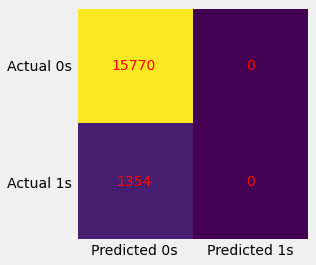

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.56851	0.92093	1.00000	0.00000	nan	0.00000	nan
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     15770
           1       0.00      0.00      0.00      1354

    accuracy                           0.92     17124
   macro avg       0.46      0.50      0.48     17124
weighted avg       0.85      0.92      0.88     17124



C:\Programs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [849]:
y_predicted = lr_nosplit.predict(X) # Predicted labels
# Evaluate the Model
tn,fp,fn,tp = confusion_matrix_plot(y, y_predicted)
metrics(X, y, lr_nosplit, tn,fp,fn,tp)
accuracy_nosplit = accuracy_score(y, y_predicted)
print(classification_report(y, y_predicted))

In [834]:
print("Distinct values that y takes:",lr_nosplit.classes_)
# probability of y=0 (1st column) and y=1 (2nd column)
print("Prediction Probabilities (top):\n", lr_nosplit.predict_proba(X)[:3])
print("Regression Coefficients:\n")
b0_nosplit = lr_nosplit.intercept_[0]
print("Intercept b0 =", b0_nosplit)
b_nosplit = lr_nosplit.coef_
print("Coefficients b =", b_nosplit)

Distinct values that y takes: [0 1]
Prediction Probabilities (top):
 [[0.58245878 0.41754122]
 [0.81523517 0.18476483]
 [0.72247876 0.27752124]]
Regression Coefficients:

Intercept b0 = -0.16278904097511854
Coefficients b = [[-1.76120529e+00  4.73984746e+00  2.85848808e-05  1.04497857e-01
  -8.31222509e-02 -2.24769995e-01  4.26116623e-02 -1.26960344e-01
   7.94175374e-02 -1.13239920e-01 -9.60585739e-02 -6.47241521e-02
  -3.59602495e-01  4.25657591e-02  2.08782429e-01 -5.25284188e-02
   1.75878250e-01 -3.43082073e-01  6.42109717e-03 -4.47574554e-02
  -1.16025270e-01  2.72835788e-01  1.51989241e-01 -4.01763299e-01
  -1.83844457e-01 -1.44294913e-01 -3.72007535e-02  2.07129404e-02
  -9.72198213e-02 -6.35629046e-02 -3.68378383e-02  6.84811185e-02
  -1.61752520e-01 -7.75454167e-02 -5.54075476e-03  8.93769666e-03
   2.27064576e-06  4.02335293e-02  4.90339681e-03  1.79462147e-01
   1.14492628e-01  4.33404927e-03 -2.65829178e-02 -9.92258403e-07
  -1.25861269e-02 -1.01191144e-01  3.90306890e-02 

##### Sweeping max_iter and solver

In [ ]:
# Initialize score dataframe
csv_auc = 'data/LR.score.solver_maxiter.csv'
#csv_auc = 'data/LR_std.score.solver_maxiter.csv'
if os.path.exists(csv_auc):
    auc = pd.read_csv(csv_auc)
else:
    auc = pd.DataFrame(columns=['solver','max_iter','roc_auc','accuracy','tnr','tpr','precision','f1','mcc'])
display(auc.head())
display(auc.tail())

# Grid sweeping of hyperparameters
for max_iter in np.arange(1,200+1):
    for solver in ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']:
        # Create and train the Logistic Regression model
        lr_nosplit = LogisticRegression(solver=solver, max_iter=max_iter, random_state=0).fit(X,y)
        roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X, y, lr_nosplit);
        auc = auc.append({'solver':solver,'max_iter':max_iter,'roc_auc':roc_auc,'accuracy':accuracy,
                          'tnr':tnr,'tpr':tpr,'precision':precision,'f1':f1,'mcc':mcc}, ignore_index=True)
        auc.to_csv(csv_auc, index=False)
auc.sort_values(['solver','max_iter'], inplace=True)
auc.to_csv(csv_auc, index=False)

In [ ]:
auc.tail(1)

In [ ]:
print("Currently optimal hyperparameters and performance:")
auc_max = -np.inf
for solver in ['newton-cg','liblinear','lbfgs','sag','saga']:
    ds = auc.loc[auc['solver']==solver]
    idx_opt = np.argmax(ds['roc_auc'])
    auc_opt = ds.iloc[idx_opt]['roc_auc']
    if auc_opt > auc_max:
        auc_max = auc_opt
        idx_max = idx_opt
        print(ds.iloc[idx_opt])

In [ ]:
# Results
-----------------------------------------
Standardized:
Optimal hyperparameters and performance:
solver          lbfgs
max_iter          129
roc_auc      0.952113
accuracy     0.949253
tnr          0.986049
tpr          0.520679
precision    0.762162
f1           0.618692
mcc          0.604903
-----------------------------------------
Non-scaled:
?

In [ ]:
auc.loc[ (auc['solver']=='sag') & (auc['max_iter'] >= 10), ['solver','max_iter','roc_auc'] ] # watch a record

#### Unscaled input
Maximum <b>ROC AUC = 0.951586</b> is achieved using <b>'newton-cg'</b> solver at <b>max_iter = 100</b>. But the convergence of AUC (to 5 decimal digits) has not occurs after 100 iterations for any of the solvers. Next in accuracy is the solver 'liblinear' with a considerably lower AUC = 0.880722 after 100 iterations. This is even worse than 0.92059 in dummy regressor. After 80 iterations, solver 'lbfgs' is close to convergence to an unacceptably low score, with maximal AUC = 0.739352 @ 81 iterations. For solver 'sag', maximal AUC = 0.582385 @ 1 iteration, and the performance slowly degrades with increasing number of iterations. The same is true for 'saga' solver, for which maximal AUC = 0.584229 @ 1 iteration. <b>Solver 'newton-cg' is recommended as the most accurate one.</b>

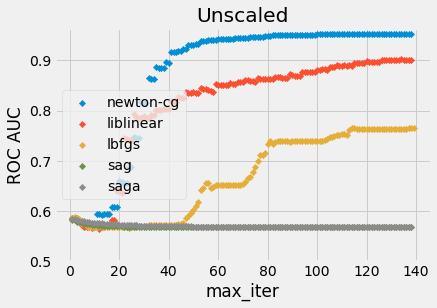

In [952]:
auc = pd.read_csv('data/LR.score.solver_maxiter.csv')
plt.xlabel('max_iter');
plt.ylabel('ROC AUC');
auc_lbfgs = auc.loc[auc['solver'] == 'lbfgs']
auc_newton = auc.loc[auc['solver'] == 'newton-cg']
auc_liblinear = auc.loc[auc['solver'] == 'liblinear']
auc_sag = auc.loc[auc['solver'] == 'sag']
auc_saga = auc.loc[auc['solver'] == 'saga']
for ds in [auc_newton, auc_liblinear, auc_lbfgs, auc_sag, auc_saga]:
    plt.scatter(ds['max_iter'], ds['roc_auc'], s=20, marker = 'D');
plt.ylim([0.5,0.965]) # relative to dummy regressor #0.920591669910471,0.953
plt.ylabel('ROC AUC')
plt.xlabel('max_iter')
plt.legend(['newton-cg','liblinear','lbfgs','sag','saga']);
plt.title("Unscaled");

#### Standardized input

Maximum <b>ROC AUC = 0.952085</b> is achieved using <b>'newton-cg'</b> solver at <b>max_iter = 17</b>. But the convergence of AUC (to 5 decimal digits) occurs after max_iter = 21. Solver 'liblinear' also converges after 21 iterations to a slightly lower AUC = 0.952076. After 100 iterations, solver 'lbfgs' is close to convergence (AUC = 0.952011), but solvers 'sag' (AUC = 0.945207) and 'saga' (AUC = 0.940271) would require many more iterations to converge and thus are not recommended as time-consuming. <b>Solver 'newton-cg' is recommended as both the most accurate and quickly converging.</b>

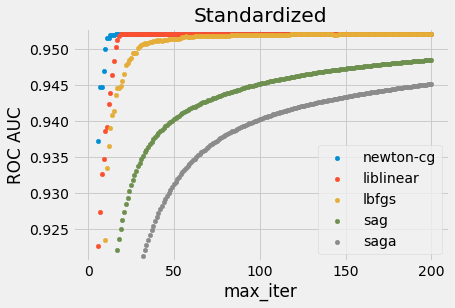

In [953]:
auc = pd.read_csv('data/LR_std.score.solver_maxiter.csv')
plt.xlabel('max_iter');
plt.ylabel('ROC AUC');
auc_lbfgs = auc.loc[auc['solver'] == 'lbfgs']
auc_newton = auc.loc[auc['solver'] == 'newton-cg']
auc_liblinear = auc.loc[auc['solver'] == 'liblinear']
auc_sag = auc.loc[auc['solver'] == 'sag']
auc_saga = auc.loc[auc['solver'] == 'saga']
for ds in [auc_newton, auc_liblinear, auc_lbfgs, auc_sag, auc_saga]:
    plt.scatter(ds['max_iter'], ds['roc_auc'], s=20);
#plt.ylim([0.5,0.96])
plt.ylim([0.920591669910471,0.953]) # relative to dummy regressor
plt.ylabel('ROC AUC')
plt.xlabel('max_iter')
plt.legend(['newton-cg','liblinear','lbfgs','sag','saga']);
plt.title("Standardized");

In [ ]:
#Standardized X
y_predicted = lr_nosplit.predict(X) # Predicted labels
# Evaluate the Model
tn,fp,fn,tp = confusion_matrix_plot(y, y_predicted)
metrics(X, y, lr_nosplit, tn,fp,fn,tp)
accuracy_nosplit = accuracy_score(y, y_predicted)
print(classification_report(y, y_predicted))

In [ ]:
# Standardized: coefficients become completely different
print("Distinct values that y takes:",lr_nosplit.classes_)
# probability of y=0 (1st column) and y=1 (2nd column)
print("Prediction Probabilities (top):\n", lr_nosplit.predict_proba(X)[:3])
print("Regression Coefficients:\n")
b0_nosplit = lr_nosplit.intercept_[0]
print("Intercept b0 =", b0_nosplit)
b_nosplit = lr_nosplit.coef_
print("Coefficients b =", b_nosplit)

#### 3.2.2 Training with splitting
Taking 70% for training set and 30% for test set.

In [851]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Train samples:",y_train.shape[0])
print("Test samples:",y_test.shape[0])

Train samples: 11986
Test samples: 5138


In [857]:
# Create and train the Logistic Regression model
#solver : {'lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'}
lr_split = LogisticRegression(solver='newton-cg', random_state=0, max_iter=10000).fit(X_train, y_train); # Create and train model using training set

[[TN, FP], [FN, TP]] =
 [[4646   84]
 [ 218  190]]


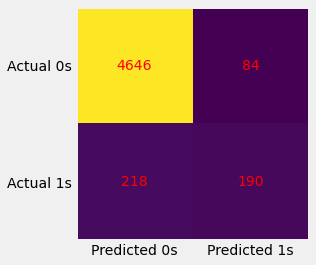

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.92660	0.94122	0.98224	0.46569	0.69343	0.55718	0.53901
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4730
           1       0.69      0.47      0.56       408

    accuracy                           0.94      5138
   macro avg       0.82      0.72      0.76      5138
weighted avg       0.93      0.94      0.94      5138



In [858]:
y_pred_split = lr_split.predict(X_test) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred_split)
metrics(X_test, y_test, lr_split, tn,fp,fn,tp)
print(classification_report(y_test, y_pred_split))

In [838]:
print("Distinct values that y takes:",lr_split.classes_)
# probability of y=0 (1st column) and y=1 (2nd column)
print("Prediction Probabilities (top):\n", lr_split.predict_proba(X_test)[:3])
print("Regression Coefficients:\n")
b0_split = lr_split.intercept_[0]
print("Intercept b0 =", b0_split)
b_split = lr_split.coef_
print("Coefficients b =", b_split)

Distinct values that y takes: [0 1]
Prediction Probabilities (top):
 [[8.70091555e-01 1.29908445e-01]
 [9.99999977e-01 2.29913319e-08]
 [7.79819697e-01 2.20180303e-01]]
Regression Coefficients:

Intercept b0 = -0.0009946886882485633
Coefficients b = [[-1.20451708e-03  2.54270940e-04 -1.11503171e-03 -3.39015882e-04
  -1.72390241e-04 -2.47373828e-04 -2.35908231e-04 -2.91507004e-04
  -3.06673936e-04 -3.96507241e-04 -2.74353147e-04 -7.20335034e-04
  -6.57900915e-04 -2.94031322e-05 -1.30008730e-04 -1.77375404e-04
  -3.03986358e-04 -3.83031096e-04 -3.07670727e-04 -3.37727547e-04
  -6.56960635e-04 -1.63926950e-04 -2.14733397e-04 -3.21599531e-04
  -2.94428304e-04 -3.09758370e-04 -3.67171631e-04 -3.17758180e-04
  -3.14168024e-04 -6.80520157e-04 -1.31827127e-03 -2.53091198e-04
  -1.66851726e-04 -1.80885861e-04  4.65826877e-04 -2.26066007e-03
  -1.29895629e-05 -1.17578361e-03 -2.78893786e-04 -1.61787514e-04
  -1.75072917e-04  4.77922636e-04 -2.07715617e-03 -8.72705567e-05
  -1.55897583e-03 -3.795

#### Comparison to no split
Quality of the model does not depend on the solver in both cases of no split and 30% test set. Compared to no splitting, many of the model coefficients differ by more than 20%,

In [859]:
print("Intercept relative error:",b0_split/b0_nosplit-1)
print("Coefficient relative error:",b_split/b_nosplit-1)

Intercept relative error: -0.9938897073028362
Coefficient relative error: [[ -0.99931608  -0.99994635 -40.00774384  -1.00324424  -0.99792606
   -0.99889944  -1.00553624  -0.99770395  -1.00386154  -0.99649852
   -0.9971439   -0.98887069  -0.99817048  -1.00069077  -1.0006227
   -0.99662325  -1.00172839  -0.99888356  -1.0479156   -0.99245427
   -0.99433778  -1.00060083  -1.00141282  -0.99919953  -0.99839849
   -0.9978533   -0.99012999  -1.01534105  -0.99676848  -0.98929375
   -0.96421421  -1.00369578  -0.99896848  -0.99766736  -1.08407282
   -1.25293542  -6.72064702  -1.02922397  -1.05687767  -1.00090151
   -1.00152912  -0.88972838  -0.92186124  86.95144138  -0.87613538
   -0.99624902  -1.0053279   -1.20089497  -0.55871998  -1.33250484
   23.45163131  -0.99637458  -1.01586316  -1.00008529  -1.00000786
   -1.0000406   -0.99992145  -0.99994677  -1.00007535  -0.99982165
   -0.99972744  -1.00015294  -0.99988792  -0.99996647  -1.00000711
   -1.00331384  -0.99979328  -0.99984821  -0.99981555  -

#### Observations

The optimal solver is 'newton-cg' (both with and without splitting). AUC for the 30% test set is 0.92660, which is 2.7% lower than 0.95208 when training the model on the entire set of records. Accuracy decreases by 0.8%, TNR - by 0.4%, TPR - by 10.3%, precision - by 9.2%, F1 score - by 9.8%, and MCC - by 10.8%.

In [860]:
roc_auc_nosplit = 0.95208
roc_auc_split = 0.92660
print("Relative difference in ROC AUC =", roc_auc_split/roc_auc_nosplit-1)

Relative difference in ROC AUC = -0.02676245693639201


The change in the proportion of positive values 1 of the label `is_churn` in the test dataset compared to the full dataset is only 0.43%,

In [861]:
print("Proportion of `is_churn==1` in the full set:", np.sum(y)/len(y))

Proportion of `is_churn==1` in the full set: 0.07907031067507592


In [862]:
print("Proportion of `is_churn==1` in the test set:", np.sum(y_test)/len(y_test))

Proportion of `is_churn==1` in the test set: 0.079408330089529


so this is not the reason for the considerable reduction in the model quality.

#### 3.2.3 Optimization of the regularization hyperparameter C
Let's try to adjust the regularization strength C.

In [954]:
def opt_C_rocauc(Cmin,Cmax,Cstep, solver='lbfgs'):#Cmax+Cstep
    #solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
    global rocauc
    '''Optimize regularization parameter C by maximizing accuracy in Logistic Regression for Train-Test split.'''
    rocauc = pd.DataFrame({'C':[],'ROC AUC':[]})
    rocauc_opt = 0
    for C in np.arange(Cmin, Cmax, Cstep):
        lr_C = LogisticRegression(C=C, solver=solver, random_state=0, max_iter=10000).fit(X_train, y_train)
        #pred = lr_C.predict(X_test) # predicted values
        metric = roc_auc_score(y_test, lr_C.predict_proba(X_test)[:, 1]) # ROC AUC score
        rocauc = rocauc.append({'C':C,'ROC AUC':metric}, ignore_index=True)
        if rocauc_opt < metric:
            rocauc_opt = metric
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest ROC AUC =',rocauc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(rocauc['C'],rocauc['ROC AUC']);
    plt.xlabel('C');
    plt.ylabel('ROC AUC');

def opt_C_accuracy(Cmin,Cmax,Cstep, solver='lbfgs'):
    '''Optimize regularization parameter C by maximizing accuracy in Logistic Regression for Train-Test split.'''
    global accuracy
    accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
    acc_opt = 0
    for C in np.arange(Cmin, Cmax+Cstep, Cstep):
        lr_C = LogisticRegression(C=C, solver=solver, random_state=0, max_iter=10000).fit(X_train, y_train)
        pred = lr_C.predict(X_test) # predicted values
        acc = lr_C.score(X_test, y_test) # proportion of correct predictions
        accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
        if acc_opt < acc:
            acc_opt = acc
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest accuracy =',acc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(accuracy['C'],accuracy['Accuracy']);
    plt.xlabel('C');
    plt.ylabel('Accuracy');

In [897]:
opt_C_rocauc(5,100,1, solver='sag') # Grid search
#solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}

KeyboardInterrupt: 

In [899]:
del Rocauc
# Save scores
try: Rocauc
except NameError: # if variable does not exist, initialize it
    Rocauc=rocauc
else: # if variable exists, append to it
    Rocauc=pd.concat([Rocauc, rocauc], axis=0)
Rocauc

,C,ROC AUC
0,5.0,0.564903
1,6.0,0.564902
2,7.0,0.564902
3,8.0,0.564902
4,9.0,0.564902
5,10.0,0.564902
6,11.0,0.564902
7,12.0,0.564902
8,13.0,0.564902
9,14.0,0.564902


In [900]:
Rocauc.to_csv("data/LR_C.sag.1.csv")

In [ ]:
Rocauc.loc[(Rocauc['C'] < 1.002) & (Rocauc['C'] > 0.998)] # Locate optimal ROC-AUC values

Optimal C = 0.22
Max AUC = 0.928351314098578


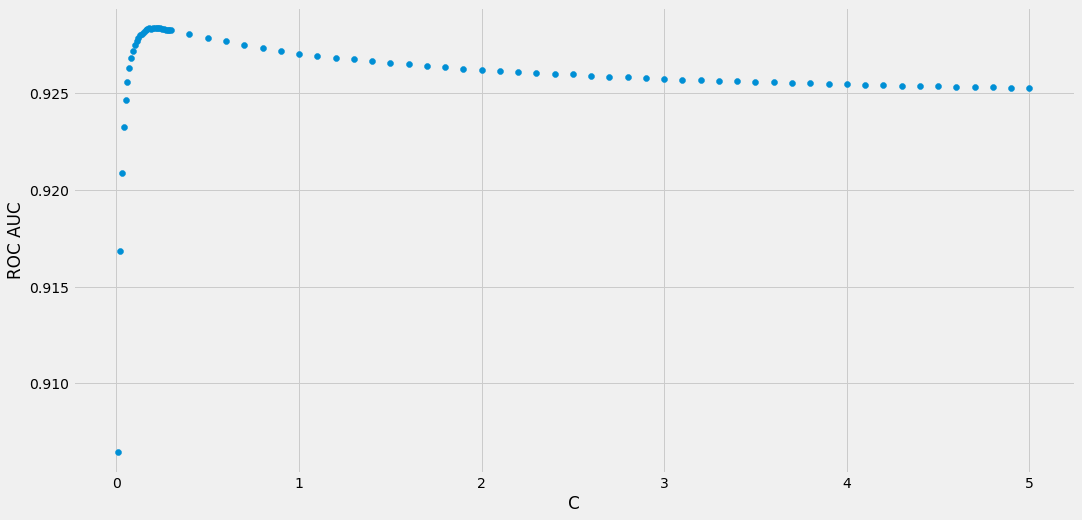

In [962]:
Rocauc = pd.read_csv("data/LR_std_C.lbfgs.csv")
idx_opt = np.argmax(Rocauc['ROC AUC'])
C_opt = Rocauc['C'].iloc[idx_opt]
auc_max = Rocauc['ROC AUC'].iloc[idx_opt]
print("Optimal C =", C_opt)
print("Max AUC =", auc_max)

fig, axs = plt.subplots(figsize = (16,8))
plt.xlabel('C');
plt.ylabel('ROC AUC');
plt.scatter(Rocauc['C'], Rocauc['ROC AUC']);

Optimal C = 0.1
Highest ROC AUC = 0.5649


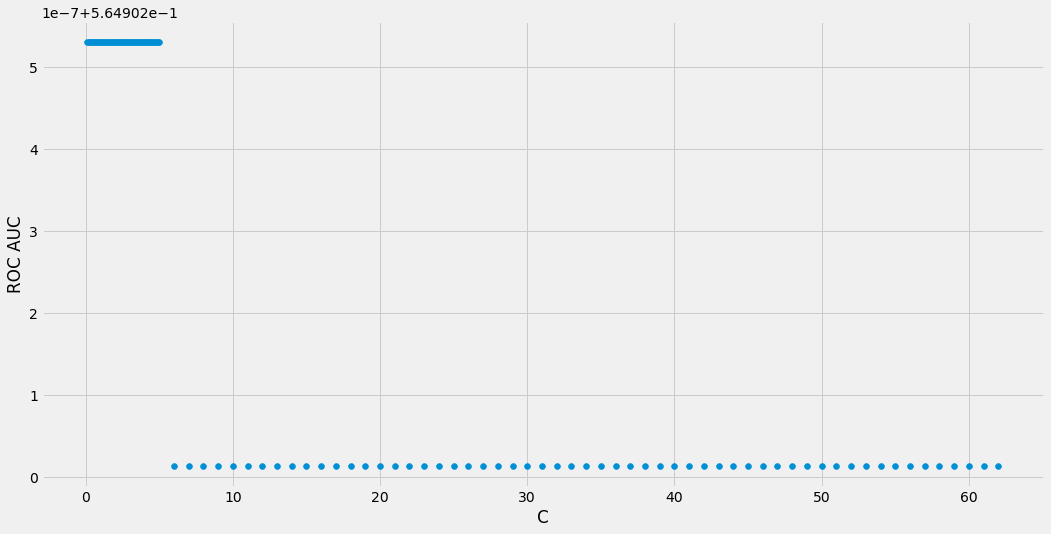

In [902]:
Rocauc = pd.read_csv('data/LR_C.sag.csv') #read
idx_opt = np.argmax(Rocauc['ROC AUC'])
C_opt = round(Rocauc['C'].iloc[idx_opt],4)
print('Optimal C =', C_opt)
rocauc_opt = round(Rocauc['ROC AUC'].iloc[idx_opt],5)
print('Highest ROC AUC =',rocauc_opt)

fig, axs = plt.subplots(figsize = (16,8))
plt.scatter(Rocauc['C'],Rocauc['ROC AUC']);
plt.xlabel('C');
plt.ylabel('ROC AUC');

In [ ]:
#Non-scaled
print('Optimized C in Logistic Regression with 30% test split:')
C_opt = 1
#solver : {'lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'}
lr_C = LogisticRegression(C=C_opt, solver='sag', random_state=0, max_iter=10000).fit(X_train, y_train) # Create and train model using training set
pred_C = lr_C.predict(X_test) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y_test, pred_C)
metrics(X_test, y_test, lr_C, tn,fp,fn,tp)
print(classification_report(y_test, pred_C))

Optimized C in Logistic Regression with 30% test split:


Optimization of the regularization parameter 'C' has lead to only a slight improvement in ROC-AUC score (by 0.749% from 0.9212 to 0.9281), while the accuracy and other performance metrics stayed almost same for $C \in [0.392, 1.756]$.

#### Sweeping max_iter and solver

In [956]:
csv

'data/df_20161022_onehot.csv'

In [ ]:
# Initialize score dataframe
scores_csv = 'data/LR_test30.score.solver_maxiter.csv'
#scores_csv = 'data/LR_std_test30.score.solver_maxiter.csv'
if os.path.exists(scores_csv):
    auc = pd.read_csv(scores_csv)
else:
    auc = pd.DataFrame(columns=['solver','max_iter', 'roc_auc','accuracy','tnr','tpr','precision','f1','mcc'])
display(auc.head())
display(auc.tail())

# Grid sweeping of hyperparameters
for max_iter in np.arange(201,300+1):#1,300+1
    for solver in ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']:
        # Create and train the Logistic Regression model
        lr_split = LogisticRegression(solver=solver, max_iter=max_iter, random_state=0).fit(X_train, y_train);
        roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X_test, y_test, lr_split);
        auc = auc.append({'solver':solver,'max_iter':max_iter,'roc_auc':roc_auc,'accuracy':accuracy,
                          'tnr':tnr,'tpr':tpr,'precision':precision,'f1':f1,'mcc':mcc}, ignore_index=True)
        auc.to_csv(scores_csv, index=False)
auc.sort_values(['solver','max_iter'], inplace=True)
auc.to_csv(scores_csv, index=False)

In [960]:
auc.tail()

,solver,max_iter,roc_auc,accuracy,tnr,tpr,precision,f1,mcc
594,saga,119,0.564831,0.920592,1.0,0.0,NaN,0.0,NaN
599,saga,120,0.564832,0.920592,1.0,0.0,NaN,0.0,NaN
604,saga,121,0.564831,0.920592,1.0,0.0,NaN,0.0,NaN
609,saga,122,0.564833,0.920592,1.0,0.0,NaN,0.0,NaN
614,saga,123,0.564835,0.920592,1.0,0.0,NaN,0.0,NaN


#### 3.2.4 Cross-Validation
A more reliable way of validating the model and optimizing its parameters is by cross-validation.

https://scikit-learn.org/stable/modules/cross_validation.html

In [904]:
from sklearn.model_selection import cross_val_score
print("Example of cross-validation:")
lr_cv = LogisticRegression(random_state=0, max_iter=10000) #solver='liblinear'
#solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
scores = cross_val_score(lr_cv, X, y, cv=10) #X_train, y_train
print('Cross-Validation Accuracy Scores', scores)
scores.min(), scores.mean(), scores.max()

Example of cross-validation:


C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-Validation Accuracy Scores [0.92586106 0.92936369 0.92994746 0.92877992 0.92172897 0.93107477
 0.92114486 0.9375     0.96728972 0.97079439]


(0.9211448598130841, 0.9363484841045114, 0.9707943925233645)

In [913]:
def optCV_C_rocauc(Cmin,Cmax,Cstep, solver='lbfgs'):
    '''Optimize regularization parameter C by maximizing accuracy in Logistic Regression with 10-fold Cross-Validation.'''
    global rocauc
    rocauc = pd.DataFrame({'C':[],'ROC AUC':[]})
    rocauc_opt = 0
    for C in np.arange(Cmin, Cmax+Cstep, Cstep):
        lr_cv = LogisticRegression(C=C, solver=solver, random_state=0, max_iter=8000).fit(X_train, y_train)
        metric = np.mean(cross_val_score(lr_cv, X, y, scoring='roc_auc', cv=10)) # accuracies of cv cross-validations
        rocauc = rocauc.append({'C':C,'ROC AUC':metric}, ignore_index=True)
        if rocauc_opt < metric:
            rocauc_opt = metric
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest ROC AUC =',rocauc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(rocauc['C'],rocauc['ROC AUC']);
    plt.xlabel('C');
    plt.ylabel('ROC AUC');
    #display(rocauc)

def optCV_C_accuracy(Cmin,Cmax,Cstep, solver='lbfgs'):
    '''Optimize regularization parameter C in Logistic Regression with 10-fold Cross-Validation'''
    global accuracy
    accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
    acc_opt = 0
    for C in np.arange(Cmin, Cmax+Cstep, Cstep):
        log_reg_cv = LogisticRegression(C=C, solver=solver, max_iter=8000, random_state=0) #liblinear
        scores = cross_val_score(log_reg_cv, X, y, cv=10) # accuracies of cv cross-validations
        acc = scores.mean()
        accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
        if acc_opt < acc:
            acc_opt = acc
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest accuracy =',acc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(accuracy['C'],accuracy['Accuracy']);
    plt.xlabel('C');
    plt.ylabel('Accuracy');
    #display(accuracy)

## RESTART

In [ ]:
## RESTART
import os
os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import  accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 600)



csv = "data/df_20161022_onehot.csv" #csv = "data/df_20161022_1.gender_onehot.featuresmt.csv"
df = pd.read_csv(csv)
drop_cols = False
if drop_cols:
    df = df.drop(['registration_Month','registration_winter','registration_spring','registration_summer',
              'registration_autumn','registration_DayofMonth','registration_beginOfMonth','registration_middleOfMonth',
             'registration_endOfMonth','registration_DayOfWeek','registration_holiday','registration_weekday',
             'firsttransaction_Month','firsttransaction_winter','firsttransaction_spring','firsttransaction_summer',
             'firsttransaction_autumn','firsttransaction_DayofMonth','firsttransaction_beginOfMonth',
             'firsttransaction_middleOfMonth','firsttransaction_endOfMonth','firsttransaction_DayOfWeek','firsttransaction_holiday',
             'firsttransaction_weekday','reg_to_trans_days1','transaction_Month1','transaction_winter1','transaction_spring1',
             'transaction_summer1','transaction_autumn1','transaction_DayofMonth1','transaction_beginOfMonth1','transaction_middleOfMonth1',
             'transaction_endOfMonth1','transaction_DayOfWeek1','transaction_holiday1','transaction_weekday1']
             ,axis=1)
print("No. of descriptors:",df.shape[1]-1)
print("No. of records:",df.shape[0])
display(df.head())
pd.set_option('display.max_seq_items', None)
print(df.columns)

X = df.drop('is_churn', axis=1) # drop unknown churn
y = df[['is_churn']]
y = np.ravel(y)

def confusion_matrix_plot(y_actual, y_predicted):
    '''Plot Binary Confusion Matrix for actual and predicted labels'''
    #from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_actual, y_predicted)
    tn = cm[0,0] # true negative count
    fp = cm[0,1] # false positive count
    fn = cm[1,0] # false negative count
    tp = cm[1,1] # true positive count
    print("[[TN, FP], [FN, TP]] =\n",cm) # print confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red') # counts
    plt.show();
    return tn,fp,fn,tp

def metrics(X, y_actual, model, tn,fp,fn,tp):
    '''Quality Metrics'''
    dr = 5 # rounding digits
    y_score = model.predict_proba(X)[:,1] # probabilities of prediction=1
    roc_auc = roc_auc_score(y_actual, y_score)
    #print(f"roc_auc_score = {round(roc_auc,dr)}: Area under ROC curve.")

    y_predicted = model.predict(X)
    accuracy = accuracy_score(y_actual, y_predicted)
    #print(f"Accuracy = {round(accuracy,dr)}: (TN+TP)/(TN+TP+FN+FP): Accuracy: percentage of total items classified correctly")
    # accuracy_nosplit = log_reg_nosplit.score(X, y)
    
    tnr = tn/(tn + fp) # tnr = 1-fpr
    #print(f"TNR = {round(tnr,dr)}: Specificity, selectivity or true negative rate (TNR), proportion of the negative class 0 got correctly classified.")
    fpr = fp/(tn + fp) # fpr = 1-tnr
    #print(f"FPR = {round(fpr,de)} Fall-out or false positive rate (FPR), or Type I Error: proportion of the negative class 0 got incorrectly classified.")

    fnr = fn/(fn + tp) # fnr = 1-tpr
    #print(f"FNR = {round(fnr,dr)}: Type II Error, miss rate or false negative rate (FNR): Proportion of the positive class 1 got incorrectly classified.")
    tpr = tp/(tp + fn) # tpr = 1-fnr
    #print(f"TPR = {round(tpr,dr)}: TP/(TP+FN): Sensitivity, recall, hit rate, or true positive rate (TPR): proportion of the positive class 1 got correctly classified.")
    #print('Recall =', recall_score(y_actual, y_predicted))
    
    precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
    #print(f"Precision = {round(precision,dr)}: TP/PP = TP/(TP+FP)")
    #print(f"Precision = {round(precision_score(y_actual, y_predicted),dr)}")
    
    f1 = 2*tp/(2*tp+fp+fn)
    #print(f"F1 score = {round(f1,dr)}: F1 score: harmonic mean of precision and recall.")
    #print(f"F1 score = {round(f1_score(y_actual, y_predicted),dr)}: F1 score: harmonic mean of precision and recall.")
    
    MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    #print(f"MCC = {round(MCC,dr)}: Matthews correlation coefficient: accounts for all 4 confusion matrix categories.")
    
    print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
    print("%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Train samples:",y_train.shape[0])
print("Test samples:",y_test.shape[0])

def opt_C_rocauc(Cmin,Cmax,Cstep, solver='lbfgs'):#Cmax+Cstep
    #solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
    global rocauc
    '''Optimize regularization parameter C by maximizing accuracy in Logistic Regression for Train-Test split.'''
    rocauc = pd.DataFrame({'C':[],'ROC AUC':[]})
    rocauc_opt = 0
    for C in np.arange(Cmin, Cmax, Cstep):
        lr_C = LogisticRegression(C=C, solver=solver, random_state=0, max_iter=10000).fit(X_train, y_train)
        #pred = lr_C.predict(X_test) # predicted values
        metric = roc_auc_score(y_test, lr_C.predict_proba(X_test)[:, 1]) # ROC AUC score
        rocauc = rocauc.append({'C':C,'ROC AUC':metric}, ignore_index=True)
        if rocauc_opt < metric:
            rocauc_opt = metric
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest ROC AUC =',rocauc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(rocauc['C'],rocauc['ROC AUC']);
    plt.xlabel('C');
    plt.ylabel('ROC AUC');

def opt_C_accuracy(Cmin,Cmax,Cstep, solver='lbfgs'):
    '''Optimize regularization parameter C by maximizing accuracy in Logistic Regression for Train-Test split.'''
    global accuracy
    accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
    acc_opt = 0
    for C in np.arange(Cmin, Cmax+Cstep, Cstep):
        lr_C = LogisticRegression(C=C, solver=solver, random_state=0, max_iter=10000).fit(X_train, y_train)
        pred = lr_C.predict(X_test) # predicted values
        acc = lr_C.score(X_test, y_test) # proportion of correct predictions
        accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
        if acc_opt < acc:
            acc_opt = acc
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest accuracy =',acc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(accuracy['C'],accuracy['Accuracy']);
    plt.xlabel('C');
    plt.ylabel('Accuracy');

from sklearn.model_selection import cross_val_score

def optCV_C_rocauc(Cmin,Cmax,Cstep, solver='lbfgs'):
    '''Optimize regularization parameter C by maximizing accuracy in Logistic Regression with 10-fold Cross-Validation.'''
    global rocauc
    rocauc = pd.DataFrame({'C':[],'ROC AUC':[]})
    rocauc_opt = 0
    for C in np.arange(Cmin, Cmax+Cstep, Cstep):
        lr_cv = LogisticRegression(C=C, solver=solver, random_state=0, max_iter=10000).fit(X_train, y_train)
        metric = np.mean(cross_val_score(lr_cv, X, y, scoring='roc_auc', cv=10)) # accuracies of cv cross-validations
        rocauc = rocauc.append({'C':C,'ROC AUC':metric}, ignore_index=True)
        if rocauc_opt < metric:
            rocauc_opt = metric
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest ROC AUC =',rocauc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(rocauc['C'],rocauc['ROC AUC']);
    plt.xlabel('C');
    plt.ylabel('ROC AUC');
    #display(rocauc)

def optCV_C_accuracy(Cmin,Cmax,Cstep, solver='lbfgs'):
    '''Optimize regularization parameter C in Logistic Regression with 10-fold Cross-Validation'''
    global accuracy
    accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
    acc_opt = 0
    for C in np.arange(Cmin, Cmax+Cstep, Cstep):
        log_reg_cv = LogisticRegression(C=C, solver=solver, max_iter=10000, random_state=0) #liblinear
        scores = cross_val_score(log_reg_cv, X, y, cv=10) # accuracies of cv cross-validations
        acc = scores.mean()
        accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
        if acc_opt < acc:
            acc_opt = acc
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest accuracy =',acc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(accuracy['C'],accuracy['Accuracy']);
    plt.xlabel('C');
    plt.ylabel('Accuracy');
    #display(accuracy)


C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

C:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Optimal C = 21.80000000000001
Highest ROC AUC = 0.9153699766385806


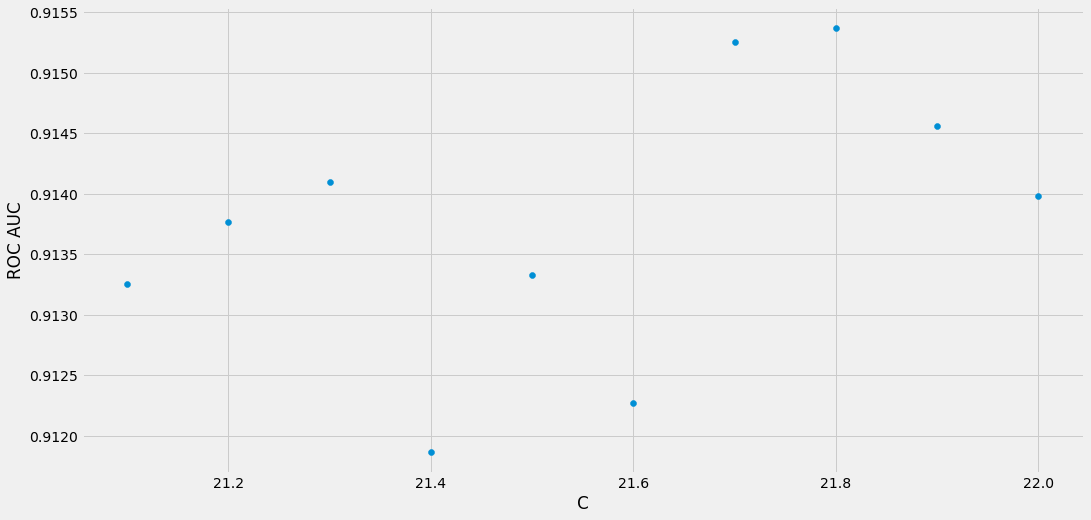

In [946]:
optCV_C_rocauc(21.1, 21.999, 0.1, solver = 'lbfgs')

In [935]:
#Rocauc = pd.read_csv('data/LR_Ccv.csv')
try: Rocauc.tail(1) # Test if a variable is defined
except NameError:
    Rocauc = rocauc
else:
    Rocauc=pd.concat([Rocauc, rocauc], ignore_index=True)
Rocauc

,C,ROC AUC
60,6.0,0.913752


,C,ROC AUC
0,0.10,0.911533
1,0.20,0.910642
2,0.30,0.912966
3,0.40,0.912141
4,0.50,0.913499
5,0.60,0.912993
6,0.70,0.910517
7,0.80,0.911243
8,0.90,0.911106
9,1.00,0.910954


In [936]:
Rocauc

,C,ROC AUC
0,0.10,0.911533
1,0.20,0.910642
2,0.30,0.912966
3,0.40,0.912141
4,0.50,0.913499
5,0.60,0.912993
6,0.70,0.910517
7,0.80,0.911243
8,0.90,0.911106
9,1.00,0.910954


In [937]:
Rocauc.sort_values('C').to_csv('data/LR_Ccv.lbfgs.1.csv') #save

Optimal C = 2.13
Highest ROC AUC = 0.91495


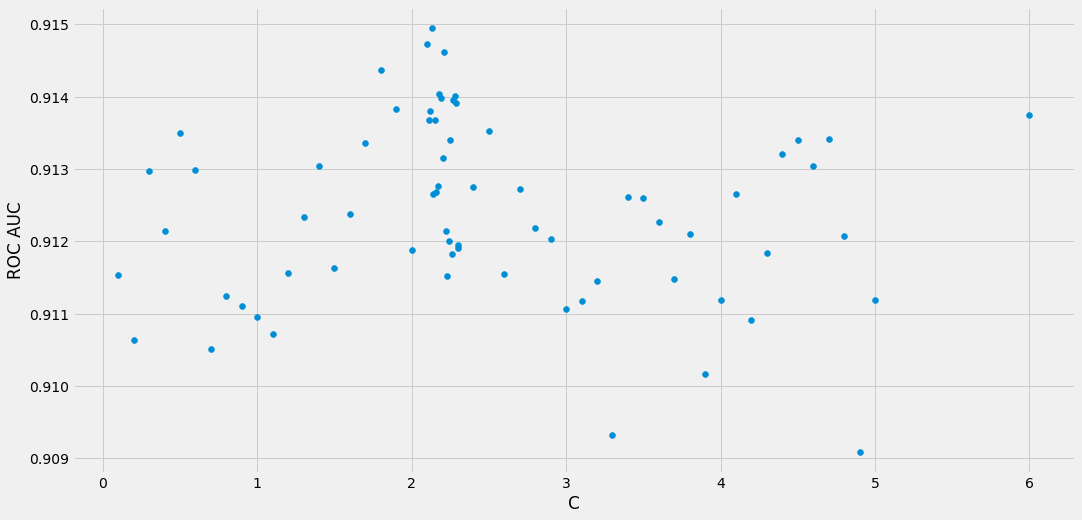

In [938]:
Rocauc = pd.read_csv('data/LR_Ccv.lbfgs.csv') #read
idx_opt = np.argmax(Rocauc['ROC AUC'])
C_opt = round(Rocauc['C'].iloc[idx_opt],4)
print('Optimal C =', C_opt)
rocauc_opt = round(Rocauc['ROC AUC'].iloc[idx_opt],5)
print('Highest ROC AUC =',rocauc_opt)

fig, axs = plt.subplots(figsize = (16,8))
plt.scatter(Rocauc['C'],Rocauc['ROC AUC']);
plt.xlabel('C');
plt.ylabel('ROC AUC');

Optimized C in Logistic Regression with 10-fold Cross-Validation:
[[TN, FP], [FN, TP]] =
 [[1511   83]
 [ 147  171]]


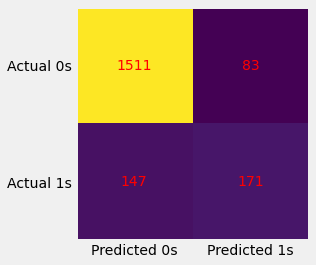

TNR = 0.9479 Specificity, proportion of the negative class 0 got correctly classified.
FNR = 0.4623 or Type II Error: Proportion of the positive class 1 got incorrectly classified.
roc_auc_score = 0.8912
Accuracy = 0.8797: (TN+TP)/(TN+TP+FN+FP): Percentage of total items classified correctly
FPR = 0.0521 Specificity, or Type I Error: proportion of the negative class 0 got incorrectly classified.
TPR = 0.5377: TP/(TP+FN): Recall, sensitivity, proportion of the positive class 1 got correctly classified.
Precision = 0.6732: TP/PP = TP/(TP+FP)
F1 score = 0.5979: harmonic mean of precision and recall.
MCC = 0.5328 Matthews correlation coefficient: accounts for all 4 confusion matrix categories.
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1594
           1       0.67      0.54      0.60       318

    accuracy                           0.88      1912
   macro avg       0.79      0.74      0.76      1912
weighted avg       0.87      

In [48]:
# Scores for the full data set, fitted using training set
print('Optimized C in Logistic Regression with 10-fold Cross-Validation:')
C_opt = 21
lr_cv = LogisticRegression(solver='lbfgs', C=C_opt, random_state=0, max_iter=10000).fit(X_train, y_train) # Create and train model using training set
pred_Ccv = lr_cv.predict(X) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y, pred_Ccv)
metrics(X, y, lr_cv, tn,fp,fn,tp)
print(classification_report(y, pred_Ccv))

In [49]:
# CV average scores
#from sklearn.metrics import SCORERS
#sorted(SCORERS.keys()) # scoring options
roc_auc = np.mean(cross_val_score(lr_cv, X, y, scoring='roc_auc', cv=10)) # accuracies of cv cross-validations
accuracy = np.mean(cross_val_score(lr_cv, X, y, scoring='accuracy', cv=10))
recall = np.mean(cross_val_score(lr_cv, X, y, scoring='recall', cv=10))
precision = np.mean(cross_val_score(lr_cv, X, y, scoring='precision', cv=10))
f1 = np.mean(cross_val_score(lr_cv, X, y, scoring='f1', cv=10))

print("roc_auc\taccuracy\trecall\tprecision\tf1")
print("%.4f | %.4f | %.4f | %.4f | %.4f" % (roc_auc, accuracy, recall, precision, f1))

roc_auc	accuracy	recall	precision	f1
0.8617 | 0.8442 | 0.4529 | 0.5740 | 0.4757


The quality is only slightly lower than in the previous 30% test split optimization of 'C'.

### Quality metrics
F1 score is very sensitive to what is called a positive and a negative class. Since we want to correctly classify the positive class is_churn == 1, a higher TPR and a lower FNR is desirable. We use ROC-AUC score as a main quality metric.

| Transactions | Cut-off date | Mode | solver | C | ROC-AUC | Accuracy | FPR | TPR | Precision | F1 | MCC |
|---:|:-------------|:-----------|:------|:------|:------|:------|:------|:------|:------|:------|:------|
| 1 | 2016-10-22 | No split | - | 1 | 0.9570 | 0.9247 | 0.0182 | 0.6384 | 0.875 | 0.7382 | 0.7072 |
| 1 | 2016-10-22 | 30% Test | - | 1 | 0.9212 | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
| 1 | 2016-10-22 | 30% Test, opt. C | - | 1.55 | 0.9281 | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
|---|-------------|---------|------|--------|--------|--------|--------|--------|--------|
| 1 | 2016-10-22 | CV 10 | lbfgs | 2.81 | 0.9540 | 0.9283 | 0.0169 | 0.6541 | 0.8851 | 0.7523 | 0.7226 |
| 1 | 2016-10-22 | CV 10* | lbfgs | 2.81 | 0.9169 | 0.9111 | - | 0.6194 | 0.8106 | 0.6931 | - |
| 1 | 2016-10-22 | CV 10 | newton-cg | ? | ? | ? | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
| 1 | 2016-10-22 | 30% Test | liblinear | 1 | ? | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
| 1 | 2016-10-22 | 30% Test | sag | 1 | ? | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
| 1 | 2016-10-22 | 30% Test | saga | 1 | ? | 0.9094 | 0.0251 | 0.5833 | 0.8235 | 0.6829 | 0.6447 |
* average over 10 CV folds.

With many boolean and label-encoded features (49 predictor variables, 1912 records, only `gender` was hot-encoded).

| Transactions | Cut-off date | Mode | solver | C | ROC-AUC | Accuracy | FPR | TPR | Precision | F1 | MCC |
|---:|:-------------|:-----------|:------|:------|:------|:------|:------|:------|:------|:------|:------|
| 1 | 2016-10-22 | No split | - | 1 | 0.8975 | 0.8797 | 0.0445 | 0.5000 | 0.6913 | 0.5803 | 0.5213 |
| 1 | 2016-10-22 | 30% Test | - | 1 | 0.8710 | 0.8659 | 0.0628 | 0.5104 | 0.6203 | 0.5600 | 0.4849 |
| 1 | 2016-10-22 | 30% Test, opt. C | - | 3.644 | 0.8723 | 0.8693 | 0.0628 | 0.5312 | 0.6296 | 0.5763 | 0.5022 |
| 1 | 2016-10-22 | CV 10 | - | 1 | 0.8900 | 0.8787 | 0.0477 | 0.5094| 0.6807 | 0.5827 | 0.5208 |
| 1 | 2016-10-22 | CV 10, opt. C | - | 52.0 | 0.8912 | 0.8797 | 0.0521 | 0.5377 | 0.6732 | 0.5979 | 0.5328 |
| 1 | 2016-10-22 | CV 10* | lbfgs | 1 | 0.8617 | 0.8442 | - | 0.4529 | 0.5740 | 0.4757 | - |


#### 3.1.5 ROC - AUC, Optimization of classification threshold
Area Under the Curve (AUC) of Receiver Characteristic Operator (ROC) helps us visualize how well our machine learning classifier is performing and choose the optimal classification threshold probability.

https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

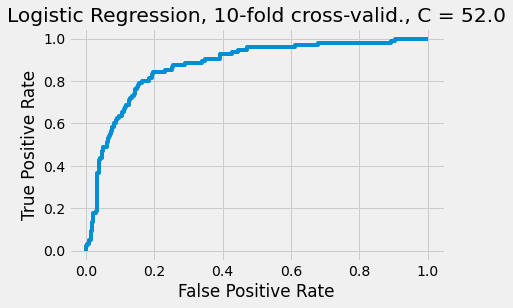

AUC: 0.873


In [51]:
prob_cv = lr_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, prob_cv, pos_label=1, drop_intermediate=False)
plt.plot(fpr, tpr, linestyle='-', label='Logistic')
plt.title(f'Logistic Regression, 10-fold cross-valid., C = {C_opt}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend()
plt.show();
print('AUC: %.3f' % roc_auc_score(y_test, prob_cv))

ROC curve built manually:

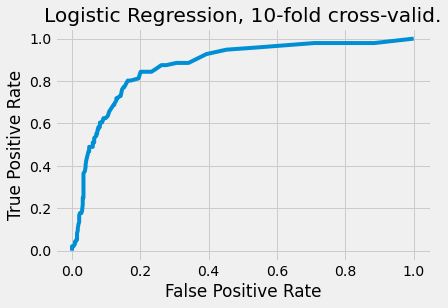

AUC: 0.873


In [58]:
pred_prob = lr_cv.predict_proba(X_test) # probability of y=0 (1st column) and y=1 (2nd column)
prob_step = 0.01
fpr = np.empty(int(1+1/prob_step))
tpr = np.empty(int(1+1/prob_step))
j = 0 # counter of points
thresholds = np.arange(0, 1+prob_step, prob_step)
for prob_thresh in thresholds:
    tn = 0; fn = 0; tp = 0; fp = 0;
    for i in range(pred_prob.shape[0]): # each test case
        if pred_prob[i,1] >= prob_thresh: # classify as 1
            if y_test[i] == 0: # actual 0
                fp = fp+1
            else: # actual 1
                tp = tp+1
        else: # classify as 0
            if y_test[i] == 0: # actual 0
                tn = tn+1
            else: # actual 1
                fn = fn+1
    fpr[j] = fp/(tn + fp) # specificity
    tpr[j] = tp/(tp + fn) # sensitivity
    j = j+1
#print("FPR =",fpr)
#print("TPR =",fpr)
# ROC curve
plt.plot(fpr, tpr, linestyle='-', label='Logistic')
plt.title('Logistic Regression, 10-fold cross-valid.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend()
plt.show()
print('AUC: %.3f' % roc_auc_score(y_test, pred_prob[:,1]))

In [65]:
print("Performance for a given decision threshold")
#from sklearn.metrics import accuracy_score, recall_score, precision_score
THRESHOLD = 0.5
preds = np.where(pred_prob[:,1] > THRESHOLD, 1, 0)
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, pred_prob[:,1])], 
             index=["accuracy", "recall", "precision", "roc_auc_score"], columns=['Score'])

Performance for a given decision threshold


,Score
accuracy,0.864111
recall,0.541667
precision,0.604651
roc_auc_score,0.872537


### Optimize decision threshold

One of the ways to locate the optimal threshold with the optimal balance between false positive and true positive rates is using the Geometric Mean (`roc_auc_score`). Let's use the squared geometric mean, which corresponds to the area to the bottom and right from the point on the ROC curve.

In [61]:
# calculate the squared g-mean for each threshold
gmeans_sq = tpr * (1-fpr)
# locate the index of the largest g-mean
ix = np.argmax(gmeans_sq)
print('Best Threshold = %.4f, G-Mean_sq = %.4f' % (thresholds[ix], gmeans_sq[ix]))
print('FPR = %.4f, TPR = %.4f' % (fpr[ix], tpr[ix]))

Best Threshold = 0.1300, G-Mean_sq = 0.6743
FPR = 0.2008, TPR = 0.8438


In [66]:
#from sklearn.metrics import accuracy_score, recall_score, precision_score
preds = np.where(pred_prob[:,1] > thresholds[ix], 1, 0)
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, pred_prob[:,1])], 
             index=["accuracy", "recall", "precision", "roc_auc_score"], columns=['Score'])

,Score
accuracy,0.806620
recall,0.843750
precision,0.457627
roc_auc_score,0.872537


#### 3.1.6 Optimize solver

In [ ]:
optCV_C_rocauc(0.58, 0.65, 0.01, solver='newton-cg')

In [ ]:
optCV_C_rocauc(0.1, 100, 0.1, solver='newton-cg')

In [ ]:
print('Optimize C using 10-fold cross-validation, lbfgs solver')
log_reg_lbfgs = LogisticRegression(solver='lbfgs')
accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
acc_opt = 0
for C in np.arange(0.1, 100.0, 0.1):
    C = round(C,1)
    log_reg_cv_lbfgs = LogisticRegression(solver='lbfgs', C=C, random_state=0, max_iter=3000)
    scores = cross_val_score(log_reg_cv_lbfgs, X_train, y_train, cv=10) # accuracies of cv cross-validations
    acc = scores.mean()
    accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
    if acc_opt < acc:
        acc_opt = acc
        C_opt = C
    if C % 10 == 0: print("C =",C)
print('Optimal C =',C_opt)
print('Highest accuracy =',acc_opt)
plt.scatter(accuracy['C'],accuracy['Accuracy']);
plt.xlabel('C');
plt.ylabel('Accuracy');

We see a "ship" with the highest accuracy 0.8543 at C = 1.0.

In [ ]:
log_reg_cv_lbfgs = LogisticRegression(solver='lbfgs', C=C_opt, random_state=0, max_iter=3000)
log_reg_cv_lbfgs.fit(X_train,y_train) # train
pred_cv_lbfgs = log_reg_cv_lbfgs.predict_proba(X_test)
fpr_cv_lbfgs, tpr_cv_lbfgs, thresh_cv_lbfgs = roc_curve(y_test, pred_cv_lbfgs[:,1], pos_label=1, drop_intermediate=False)
plt.plot(fpr_cv_lbfgs, tpr_cv_lbfgs, linestyle='-', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
# calculate the squared g-mean for each threshold
gmeans_sq = tpr_cv_lbfgs * (1-fpr_cv_lbfgs)
# locate the index of the largest g-mean
ix = np.argmax(gmeans_sq)
print('Best Threshold=%.2f, G-Mean_sq=%.3f' % (thresh_cv_lbfgs[ix], gmeans_sq[ix]))
print('FPR=%.3f, TPR=%.3f' % (fpr_cv_lbfgs[ix], tpr_cv_lbfgs[ix]))

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
THRESHOLD = 0.19
preds = np.where(log_reg_cv_lbfgs.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

In [ ]:
print(f"Accuracy relative change: {round(accuracy_score(y_test, preds)/0.777003-1,4)}")
print(f"Recall: {round(recall_score(y_test, preds)/0.812500-1,4)}")
print(f"Precision: {round(precision_score(y_test, preds)/0.414894-1,4)}")
print(f"ROC AUC: {round(roc_auc_score(y_test, preds)/0.791187-1,4)}")

## 3. Feature Engineering
### 3.2 One-hot encoding
Let us convert all categorical features into dummy variables using one-hot encoding and compare performance of logistic regression.

In [ ]:
df_onehot = pd.get_dummies(df, drop_first=False, columns=['city','bd','gender','registered_via','payment_method_id','is_auto_renew','is_cancel','discount'])
df_onehot.head()

In [ ]:
x = df_onehot.drop('is_churn', axis=1)
print(f"Samples: {x.shape[0]}, explanatory variables: {x.shape[1]}")
y = df_onehot['is_churn']
#y.head()

In [ ]:
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
print("Train samples:",y_train.shape[0])
print("Test samples:",y_test.shape[0])

In [ ]:
print('Optimize C using cross-validation')
accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
acc_opt = 0
for C in np.arange(0.1, 100.0, 0.1):
    C = round(C,1)
    log_reg_cv = LogisticRegression(solver='liblinear', C=C, random_state=0)
    scores = cross_val_score(log_reg_cv, X_train, y_train, cv=10) # accuracies of cv cross-validations
    acc = scores.mean()
    accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
    if acc_opt < acc:
        acc_opt = acc
        C_opt = C
print('Optimal C =',C_opt)
print('Highest accuracy =',acc_opt)
plt.scatter(accuracy['C'],accuracy['Accuracy']);
plt.xlabel('C');
plt.ylabel('Accuracy');

In [ ]:
log_reg_cv_liblinear_onehot = LogisticRegression(solver='lbfgs', C=C_opt, random_state=0, max_iter=3000)
log_reg_cv_liblinear_onehot.fit(X_train,y_train) # train
pred_cv_liblinear_onehot = log_reg_cv_liblinear_onehot.predict_proba(X_test)
fpr_cv_liblinear_onehot, tpr_cv_liblinear_onehot, thresh_cv_liblinear_onehot = roc_curve(y_test, pred_cv_liblinear_onehot[:,1], pos_label=1, drop_intermediate=False)
plt.plot(fpr_cv_liblinear_onehot, tpr_cv_liblinear_onehot, linestyle='-', color='green', linewidth=2, label='One-hot encoding')
plt.plot(fpr_cv_lbfgs, tpr_cv_lbfgs, linestyle='--', linewidth=2, color='black', label='Numeric')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

ROC curve for one-hot encoding is very close to the case when all features except gender were used in their numeric encoding. In addition, the optimal threshold value has not changed after switching to one-hot encoding.

In [ ]:
# calculate the squared g-mean for each threshold
gmeans_sq = tpr_cv_liblinear_onehot * (1-fpr_cv_liblinear_onehot)
# locate the index of the largest g-mean
ix = np.argmax(gmeans_sq)
print('Best Threshold=%.2f, G-Mean_sq=%.3f' % (thresh_cv_liblinear_onehot[ix], gmeans_sq[ix]))
print('FPR=%.3f, TPR=%.3f' % (fpr[ix], tpr[ix]))

print(f"Relative change in G-Mean_sq: {round(gmeans_sq[ix]/0.627-1,4)}")
print(f"Relative change in FPR: {round(fpr[ix]/0.228-1,4)}")
print(f"Relative change in TPR: {round(tpr[ix]/0.812-1,4)}")

## RESTART

In [ ]:
import os
#os.chdir('C:/Sereda/Lectures/Springboard/16.Feature_Engineering/')
os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')

# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
#import warnings
#warnings.filterwarnings('ignore')

from pathlib import Path

plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 600)

mt = pd.read_csv('data/members_transactions.csv', \
                 parse_dates=['registration_init_time','transaction_date', 'membership_expire_date'], \
                      infer_datetime_format = True, index_col=None)
logs_short = pd.read_csv('data/logs_short.csv', parse_dates=['date'], infer_datetime_format = True)

latest_date = np.max(mt.transaction_date)
print(f"Latest recorded transaction: {latest_date.strftime('%Y-%m-%d')}")
#cutoff_date = latest_date
cutoff_date = pd.Timestamp('2016-10-22')
print("Applying cutoff time", cutoff_date.strftime('%Y-%m-%d'))
mt_cut = mt.loc[mt.transaction_date <= cutoff_date]
print("No. of records:", len(mt_cut))
member_list = mt_cut['msno'].unique() # list of all member id's
print("No. of members:", len(member_list))
mt_cut.head()

### 3.3 More than one transaction per member
Now let's introduce features in cases when a member had more than one transaction. Due to the dependence of the number of features on the number of transactions, we have to keep the number of transactions fixed. Consider 2 transactions per member. All members with only 1 transaction are disregarded.

In [ ]:
# Select only first `n_trans` transaction for each member
n_trans=1
mt_cutn = pd.DataFrame({'msno':[],'city':[],'bd':[],'gender':[],'registered_via':[],'registration_init_time':[],'payment_method_id':[],'payment_plan_days':[],'plan_list_price':[],'actual_amount_paid':[],'is_auto_renew':[],'transaction_date':[],'membership_expire_date':[],'is_cancel':[],'discount':[],'is_churn':[]})
for member_id in member_list:
    member_transactions = mt_cut.loc[mt_cut['msno'] == member_id]
    if len(member_transactions) >= n_trans:
        tr = member_transactions.head(n_trans)
        #mt_cut1.loc[len(mt_cut1.index)] = [tr['msno'],tr['city'].iloc[0],0,0,0,0,0,0,0,0,0,0,0,0,0]n
        mt_cutn = mt_cutn.append(tr, ignore_index = True)
print(mt_cutn.shape)
mt_cutn.head()

In [ ]:
df = mt_cutn.drop(['msno','plan_list_price','registration_init_time','transaction_date','membership_expire_date'],axis=1)
print(df.shape)
df.head()

In [ ]:
print("Reshape features to have one row per member")
# Column names for all features in all transactions
columns = list(['city','bd','gender','registered_via'])
for i in range(1,n_trans+1):
    for col in ['payment_method_id','payment_plan_days','actual_amount_paid','is_auto_renew','is_cancel','discount']:
        columns.append(col+str(i))
columns.append('is_churn')
print(columns)
mt_cutn = pd.DataFrame(columns=columns)
for i in range(df.shape[0]//n_trans): # members
    tr_all = df.iloc[i * n_trans, 0:4] # common columns for all transactions
    for t in range(n_trans):
        tr_all = np.concatenate((tr_all, df.iloc[i * n_trans + t, 4:10]), axis=0)
    tr_all = np.concatenate((tr_all, df.iloc[(i+1) * n_trans - 1, 10:11]), axis=0)
    tr_all = pd.DataFrame(tr_all, index=columns).transpose()
    mt_cutn = mt_cutn.append(tr_all)
mt_cutn.head()

In [ ]:
mt_cutn_onehot = pd.get_dummies(mt_cutn, drop_first=False, columns=mt_cutn.columns.drop('is_churn'))
print("No. of predictors:", mt_cutn_onehot.shape[1]-1)
mt_cutn_onehot.head()

In [ ]:
X = mt_cutn_onehot.loc[mt_cutn_onehot['is_churn'] != 2].drop('is_churn', axis=1) # drop unknown churn
X.head()

In [ ]:
y = mt_cutn_onehot.loc[mt_cutn_onehot['is_churn'] != 2, ['is_churn']]
y = np.ravel(y)
y[:5]